In [1]:
# Libraries and Settings
# Imports
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '' # this line ignore the GPU
import random
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import time

# Paths
PREPROC_ROOT = Path('preprocessed_variants')
RESULTS_DIR = Path('models_results')
MODELS_DIR = Path('models')
RESULTS_DIR.mkdir(parents=True,exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Settings
SEED = 42
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
EPOCHS = 40
IMG_SHAPE_MAP ={50:(50,50), 64:(64,64), 96:(96,96), 128:(128,128), 256:(256,256)}
N_CLASSES = 10

# Tomato Classes
CLASS_NAMES = [
    'Tomato___Bacterial_spot',
    'Tomato___Early_blight',
    'Tomato___healthy',
    'Tomato___Late_blight',
    'Tomato___Leaf_Mold',
    'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot',
    'Tomato___Tomato_mosaic_virus',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
]

# Reproducibility
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seed(SEED)

In [2]:
# Helpers - Base Model
def build_base_model(input_shape=(50,50,3),n_classes = N_CLASSES, use_gap=True,bn=True,dropout=0.4):
    inputs = keras.Input(shape=input_shape)
    x=inputs
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
    if bn: x = layers.BatchNormalization()(x)
    x= layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
    if bn: x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
    if bn: x= layers.BatchNormalization()(x)
    x=layers.MaxPooling2D()(x)
    
    if use_gap:
        x = layers.GlobalAveragePooling2D()(x)
    else:
        x=layers.Flatten()(x)
    
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_classes,activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    return model

In [3]:
# Data loaders
def make_datasets_from_folder(variant_path: Path, image_size=(50,50),batch_size=BATCH_SIZE, seed=SEED):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        variant_path,
        labels='inferred',
        label_mode='int',
        class_names=CLASS_NAMES,
        image_size=image_size,
        batch_size=batch_size,
        shuffle=True,
        validation_split=0.2,
        subset='training',
        seed=seed
    )
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
        variant_path,
        labels='inferred',
        label_mode='int',
        class_names=CLASS_NAMES,
        image_size=image_size,
        batch_size=batch_size,
        shuffle=True,
        validation_split=0.2,
        subset='training',
        seed=seed
    )
    
    # Prefetch and standarize (rescale to [0,1])
    normalization_layer = layers.Rescaling(1./255)
    train_ds=train_ds.map(lambda x,y: (normalization_layer(x),y), num_parallel_calls=AUTO).prefetch(AUTO)
    val_ds = val_ds.map(lambda x,y: (normalization_layer(x),y), num_parallel_calls=AUTO).prefetch(AUTO)
    
    return train_ds,val_ds

# Compute metrics 

def compute_metrics(model,dataset):
    y_true = []
    y_pred = []
    for x_batch, y_batch in dataset:
        preds = model.predict(x_batch)
        preds_labels = np.argmax(preds, axis=1)
        y_true.extend(y_batch.numpy().tolist())
        y_pred.extend(preds_labels.tolist())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    return {'accuracy':acc, 'precision':precision, 'recall':recall, 'f1':f1, 'confusion_matrix':cm}    

In [4]:
# Main Loop on variants
variants_folders = sorted([path for path in PREPROC_ROOT.iterdir() if path.is_dir()])
print(f"Found {len(variants_folders)} variants\n")

results = []

for variant_path in variants_folders:
    variant_name = variant_path.name
    print(f"\nRunning variant: {variant_name}\n")
    
    if 'resolution_' in variant_name:
        try:
            part = variant_name.split('_')[1]
            width=int(part.split('X')[0])
            image_size = (width,width)
        except Exception as e:
            image_size = (50,50)
    else:
        image_size=(50,50)
        
    # Create datasets
    start_time = time.perf_counter()
    train_ds, val_ds = make_datasets_from_folder(variant_path, image_size=image_size, batch_size=BATCH_SIZE, seed=SEED)
    
    # Build model
    set_seed(SEED)
    model = build_base_model(input_shape=(image_size[0],image_size[1],3), n_classes=len(CLASS_NAMES), use_gap=True, bn=True, dropout=0.4)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    
    # Callbacks and checkpoint
    ckpt_path = MODELS_DIR/f"{variant_name}__best.h5"
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
        ModelCheckpoint(str(ckpt_path), monitor='val_loss', save_best_only=True, save_weights_only=False)
    ]
    # Train
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks,verbose=2)
    
    # Compute metrics on val set
    metrics = compute_metrics(model, val_ds)
    end_time = time.perf_counter()
    
    # Record
    record = {
        'variant': variant_name,
        'image_size': f"{image_size[0]}x{image_size[1]}",
        'quality': int(variant_name.split('_')[-1]) if variant_name.split('_')[-1].isdigit() else None,
        'train_epochs': len(history.history['loss']),
        'train_time_seconds': round(end_time - start_time, 2),
        'val_accuracy': metrics['accuracy'],
        'val_precision_macro': metrics['precision'],
        'val_recall_macro': metrics['recall'],
        'val_f1_macro': metrics['f1'],
        'checkpoint_path': str(ckpt_path)
    }
    results.append(record)
    
    # Save history
    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv(RESULTS_DIR / f"history_{variant_name}.csv", index=False)

    # Save confusion matrix as np
    np.save(RESULTS_DIR / f"cm_{variant_name}.npy", metrics['confusion_matrix'])

    # Free memory
    del model
    tf.keras.backend.clear_session()
# Save results summary
results_df = pd.DataFrame(results)
results_df.to_csv(RESULTS_DIR / 'general_comparison.csv', index=False)
print('\nAll variants processed. Results saved to', RESULTS_DIR / 'general_comparison.csv')

Found 25 variants


Running variant: resolution_128X128_quality_110

Found 18159 files belonging to 10 classes.
Using 14528 files for training.
Found 18159 files belonging to 10 classes.
Using 14528 files for training.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


454/454 - 124s - 273ms/step - accuracy: 0.6652 - loss: 1.0064 - val_accuracy: 0.6336 - val_loss: 1.0424 - learning_rate: 0.0010
Epoch 2/40
454/454 - 121s - 266ms/step - accuracy: 0.7903 - loss: 0.6166 - val_accuracy: 0.6035 - val_loss: 1.2869 - learning_rate: 0.0010
Epoch 3/40


454/454 - 120s - 264ms/step - accuracy: 0.8377 - loss: 0.4865 - val_accuracy: 0.8760 - val_loss: 0.3431 - learning_rate: 0.0010
Epoch 4/40
454/454 - 119s - 262ms/step - accuracy: 0.8601 - loss: 0.4180 - val_accuracy: 0.8056 - val_loss: 0.5512 - learning_rate: 0.0010
Epoch 5/40


454/454 - 119s - 262ms/step - accuracy: 0.8819 - loss: 0.3504 - val_accuracy: 0.8881 - val_loss: 0.3216 - learning_rate: 0.0010
Epoch 6/40


454/454 - 120s - 263ms/step - accuracy: 0.8963 - loss: 0.3003 - val_accuracy: 0.8975 - val_loss: 0.2697 - learning_rate: 0.0010
Epoch 7/40
454/454 - 120s - 264ms/step - accuracy: 0.9083 - loss: 0.2800 - val_accuracy: 0.8685 - val_loss: 0.3869 - learning_rate: 0.0010
Epoch 8/40


454/454 - 120s - 265ms/step - accuracy: 0.9173 - loss: 0.2534 - val_accuracy: 0.9624 - val_loss: 0.1201 - learning_rate: 0.0010
Epoch 9/40
454/454 - 119s - 263ms/step - accuracy: 0.9230 - loss: 0.2284 - val_accuracy: 0.8651 - val_loss: 0.4219 - learning_rate: 0.0010
Epoch 10/40
454/454 - 118s - 260ms/step - accuracy: 0.9297 - loss: 0.2082 - val_accuracy: 0.9543 - val_loss: 0.1308 - learning_rate: 0.0010
Epoch 11/40
454/454 - 118s - 260ms/step - accuracy: 0.9336 - loss: 0.1992 - val_accuracy: 0.9458 - val_loss: 0.1484 - learning_rate: 0.0010
Epoch 12/40
454/454 - 118s - 261ms/step - accuracy: 0.9482 - loss: 0.1554 - val_accuracy: 0.9421 - val_loss: 0.1722 - learning_rate: 5.0000e-04
Epoch 13/40


454/454 - 118s - 260ms/step - accuracy: 0.9548 - loss: 0.1406 - val_accuracy: 0.9601 - val_loss: 0.1152 - learning_rate: 5.0000e-04
Epoch 14/40
454/454 - 118s - 261ms/step - accuracy: 0.9559 - loss: 0.1347 - val_accuracy: 0.9444 - val_loss: 0.1584 - learning_rate: 5.0000e-04
Epoch 15/40


454/454 - 119s - 262ms/step - accuracy: 0.9595 - loss: 0.1231 - val_accuracy: 0.9767 - val_loss: 0.0685 - learning_rate: 5.0000e-04
Epoch 16/40
454/454 - 118s - 260ms/step - accuracy: 0.9608 - loss: 0.1149 - val_accuracy: 0.9695 - val_loss: 0.0881 - learning_rate: 5.0000e-04
Epoch 17/40


454/454 - 118s - 261ms/step - accuracy: 0.9630 - loss: 0.1134 - val_accuracy: 0.9784 - val_loss: 0.0646 - learning_rate: 5.0000e-04
Epoch 18/40
454/454 - 119s - 262ms/step - accuracy: 0.9614 - loss: 0.1159 - val_accuracy: 0.8901 - val_loss: 0.3608 - learning_rate: 5.0000e-04
Epoch 19/40


454/454 - 123s - 271ms/step - accuracy: 0.9621 - loss: 0.1103 - val_accuracy: 0.9777 - val_loss: 0.0621 - learning_rate: 5.0000e-04
Epoch 20/40


454/454 - 129s - 284ms/step - accuracy: 0.9634 - loss: 0.1075 - val_accuracy: 0.9821 - val_loss: 0.0500 - learning_rate: 5.0000e-04
Epoch 21/40
454/454 - 130s - 286ms/step - accuracy: 0.9670 - loss: 0.0969 - val_accuracy: 0.9725 - val_loss: 0.0770 - learning_rate: 5.0000e-04
Epoch 22/40
454/454 - 128s - 281ms/step - accuracy: 0.9669 - loss: 0.0975 - val_accuracy: 0.9546 - val_loss: 0.1175 - learning_rate: 5.0000e-04
Epoch 23/40


454/454 - 129s - 283ms/step - accuracy: 0.9685 - loss: 0.0931 - val_accuracy: 0.9905 - val_loss: 0.0328 - learning_rate: 5.0000e-04
Epoch 24/40
454/454 - 130s - 287ms/step - accuracy: 0.9683 - loss: 0.0984 - val_accuracy: 0.9827 - val_loss: 0.0482 - learning_rate: 5.0000e-04
Epoch 25/40
454/454 - 130s - 286ms/step - accuracy: 0.9690 - loss: 0.0939 - val_accuracy: 0.9376 - val_loss: 0.1851 - learning_rate: 5.0000e-04
Epoch 26/40
454/454 - 127s - 279ms/step - accuracy: 0.9704 - loss: 0.0863 - val_accuracy: 0.9894 - val_loss: 0.0337 - learning_rate: 5.0000e-04
Epoch 27/40


454/454 - 121s - 266ms/step - accuracy: 0.9757 - loss: 0.0739 - val_accuracy: 0.9924 - val_loss: 0.0247 - learning_rate: 2.5000e-04
Epoch 28/40


454/454 - 119s - 263ms/step - accuracy: 0.9787 - loss: 0.0672 - val_accuracy: 0.9944 - val_loss: 0.0216 - learning_rate: 2.5000e-04
Epoch 29/40
454/454 - 119s - 262ms/step - accuracy: 0.9778 - loss: 0.0627 - val_accuracy: 0.9926 - val_loss: 0.0217 - learning_rate: 2.5000e-04
Epoch 30/40


454/454 - 119s - 261ms/step - accuracy: 0.9817 - loss: 0.0619 - val_accuracy: 0.9945 - val_loss: 0.0185 - learning_rate: 2.5000e-04
Epoch 31/40
454/454 - 120s - 264ms/step - accuracy: 0.9778 - loss: 0.0629 - val_accuracy: 0.9924 - val_loss: 0.0253 - learning_rate: 2.5000e-04
Epoch 32/40


454/454 - 120s - 265ms/step - accuracy: 0.9785 - loss: 0.0644 - val_accuracy: 0.9944 - val_loss: 0.0172 - learning_rate: 2.5000e-04
Epoch 33/40
454/454 - 120s - 264ms/step - accuracy: 0.9794 - loss: 0.0623 - val_accuracy: 0.9933 - val_loss: 0.0201 - learning_rate: 2.5000e-04
Epoch 34/40


454/454 - 120s - 264ms/step - accuracy: 0.9807 - loss: 0.0561 - val_accuracy: 0.9964 - val_loss: 0.0140 - learning_rate: 2.5000e-04
Epoch 35/40
454/454 - 119s - 262ms/step - accuracy: 0.9820 - loss: 0.0560 - val_accuracy: 0.9948 - val_loss: 0.0187 - learning_rate: 2.5000e-04
Epoch 36/40


454/454 - 120s - 264ms/step - accuracy: 0.9821 - loss: 0.0525 - val_accuracy: 0.9975 - val_loss: 0.0108 - learning_rate: 2.5000e-04
Epoch 37/40
454/454 - 120s - 264ms/step - accuracy: 0.9841 - loss: 0.0491 - val_accuracy: 0.9930 - val_loss: 0.0208 - learning_rate: 2.5000e-04
Epoch 38/40
454/454 - 119s - 261ms/step - accuracy: 0.9832 - loss: 0.0553 - val_accuracy: 0.9964 - val_loss: 0.0125 - learning_rate: 2.5000e-04
Epoch 39/40
454/454 - 119s - 262ms/step - accuracy: 0.9814 - loss: 0.0547 - val_accuracy: 0.9973 - val_loss: 0.0112 - learning_rate: 2.5000e-04
Epoch 40/40


454/454 - 118s - 260ms/step - accuracy: 0.9853 - loss: 0.0430 - val_accuracy: 0.9981 - val_loss: 0.0091 - learning_rate: 1.2500e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57m


Running variant: resolution_128X128_quality_30

Found 18159 files belonging to 10 classes.
Using 14528 files for training.
Found 18159 files belonging to 10 classes.
Using 14528 files for training.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


454/454 - 121s - 266ms/step - accuracy: 0.6556 - loss: 1.0334 - val_accuracy: 0.5128 - val_loss: 1.3486 - learning_rate: 0.0010
Epoch 2/40


454/454 - 119s - 261ms/step - accuracy: 0.7811 - loss: 0.6451 - val_accuracy: 0.6909 - val_loss: 0.9374 - learning_rate: 0.0010
Epoch 3/40


454/454 - 120s - 263ms/step - accuracy: 0.8223 - loss: 0.5313 - val_accuracy: 0.8680 - val_loss: 0.3801 - learning_rate: 0.0010
Epoch 4/40


454/454 - 120s - 265ms/step - accuracy: 0.8415 - loss: 0.4673 - val_accuracy: 0.8721 - val_loss: 0.3663 - learning_rate: 0.0010
Epoch 5/40


454/454 - 118s - 260ms/step - accuracy: 0.8564 - loss: 0.4202 - val_accuracy: 0.9071 - val_loss: 0.2792 - learning_rate: 0.0010
Epoch 6/40
454/454 - 118s - 260ms/step - accuracy: 0.8765 - loss: 0.3644 - val_accuracy: 0.7713 - val_loss: 0.8096 - learning_rate: 0.0010
Epoch 7/40
454/454 - 118s - 260ms/step - accuracy: 0.8844 - loss: 0.3459 - val_accuracy: 0.8226 - val_loss: 0.4820 - learning_rate: 0.0010
Epoch 8/40


454/454 - 118s - 260ms/step - accuracy: 0.8913 - loss: 0.3218 - val_accuracy: 0.9453 - val_loss: 0.1641 - learning_rate: 0.0010
Epoch 9/40
454/454 - 118s - 261ms/step - accuracy: 0.9038 - loss: 0.2869 - val_accuracy: 0.9301 - val_loss: 0.1942 - learning_rate: 0.0010
Epoch 10/40
454/454 - 118s - 259ms/step - accuracy: 0.9046 - loss: 0.2841 - val_accuracy: 0.7201 - val_loss: 1.0836 - learning_rate: 0.0010
Epoch 11/40
454/454 - 118s - 259ms/step - accuracy: 0.9093 - loss: 0.2681 - val_accuracy: 0.9345 - val_loss: 0.1879 - learning_rate: 0.0010
Epoch 12/40
454/454 - 119s - 262ms/step - accuracy: 0.9271 - loss: 0.2139 - val_accuracy: 0.8638 - val_loss: 0.3699 - learning_rate: 5.0000e-04
Epoch 13/40
454/454 - 118s - 259ms/step - accuracy: 0.9330 - loss: 0.2011 - val_accuracy: 0.9135 - val_loss: 0.2416 - learning_rate: 5.0000e-04
Epoch 14/40


454/454 - 123s - 271ms/step - accuracy: 0.9358 - loss: 0.1954 - val_accuracy: 0.9455 - val_loss: 0.1562 - learning_rate: 5.0000e-04
Epoch 15/40


454/454 - 122s - 269ms/step - accuracy: 0.9383 - loss: 0.1906 - val_accuracy: 0.9513 - val_loss: 0.1376 - learning_rate: 5.0000e-04
Epoch 16/40


454/454 - 122s - 269ms/step - accuracy: 0.9397 - loss: 0.1786 - val_accuracy: 0.9665 - val_loss: 0.0992 - learning_rate: 5.0000e-04
Epoch 17/40


454/454 - 121s - 267ms/step - accuracy: 0.9414 - loss: 0.1745 - val_accuracy: 0.9687 - val_loss: 0.0948 - learning_rate: 5.0000e-04
Epoch 18/40
454/454 - 125s - 274ms/step - accuracy: 0.9418 - loss: 0.1730 - val_accuracy: 0.9662 - val_loss: 0.0998 - learning_rate: 5.0000e-04
Epoch 19/40
454/454 - 123s - 270ms/step - accuracy: 0.9450 - loss: 0.1621 - val_accuracy: 0.9466 - val_loss: 0.1403 - learning_rate: 5.0000e-04
Epoch 20/40
454/454 - 120s - 264ms/step - accuracy: 0.9457 - loss: 0.1595 - val_accuracy: 0.9597 - val_loss: 0.1084 - learning_rate: 5.0000e-04
Epoch 21/40


454/454 - 119s - 263ms/step - accuracy: 0.9542 - loss: 0.1345 - val_accuracy: 0.9763 - val_loss: 0.0707 - learning_rate: 2.5000e-04
Epoch 22/40
454/454 - 119s - 262ms/step - accuracy: 0.9548 - loss: 0.1347 - val_accuracy: 0.9716 - val_loss: 0.0829 - learning_rate: 2.5000e-04
Epoch 23/40


454/454 - 120s - 264ms/step - accuracy: 0.9546 - loss: 0.1315 - val_accuracy: 0.9853 - val_loss: 0.0495 - learning_rate: 2.5000e-04
Epoch 24/40
454/454 - 121s - 266ms/step - accuracy: 0.9562 - loss: 0.1289 - val_accuracy: 0.9845 - val_loss: 0.0531 - learning_rate: 2.5000e-04
Epoch 25/40
454/454 - 134s - 296ms/step - accuracy: 0.9584 - loss: 0.1229 - val_accuracy: 0.9791 - val_loss: 0.0615 - learning_rate: 2.5000e-04
Epoch 26/40
454/454 - 127s - 280ms/step - accuracy: 0.9595 - loss: 0.1250 - val_accuracy: 0.9821 - val_loss: 0.0548 - learning_rate: 2.5000e-04
Epoch 27/40


454/454 - 129s - 284ms/step - accuracy: 0.9617 - loss: 0.1166 - val_accuracy: 0.9895 - val_loss: 0.0378 - learning_rate: 1.2500e-04
Epoch 28/40


454/454 - 122s - 268ms/step - accuracy: 0.9630 - loss: 0.1130 - val_accuracy: 0.9882 - val_loss: 0.0365 - learning_rate: 1.2500e-04
Epoch 29/40
454/454 - 119s - 263ms/step - accuracy: 0.9648 - loss: 0.1112 - val_accuracy: 0.9895 - val_loss: 0.0374 - learning_rate: 1.2500e-04
Epoch 30/40


454/454 - 119s - 263ms/step - accuracy: 0.9652 - loss: 0.1056 - val_accuracy: 0.9897 - val_loss: 0.0349 - learning_rate: 1.2500e-04
Epoch 31/40
454/454 - 120s - 264ms/step - accuracy: 0.9647 - loss: 0.1078 - val_accuracy: 0.9880 - val_loss: 0.0400 - learning_rate: 1.2500e-04
Epoch 32/40
454/454 - 121s - 267ms/step - accuracy: 0.9669 - loss: 0.1001 - val_accuracy: 0.9863 - val_loss: 0.0421 - learning_rate: 1.2500e-04
Epoch 33/40


454/454 - 120s - 264ms/step - accuracy: 0.9639 - loss: 0.1061 - val_accuracy: 0.9904 - val_loss: 0.0332 - learning_rate: 1.2500e-04
Epoch 34/40
454/454 - 120s - 264ms/step - accuracy: 0.9644 - loss: 0.1053 - val_accuracy: 0.9880 - val_loss: 0.0373 - learning_rate: 1.2500e-04
Epoch 35/40
454/454 - 123s - 270ms/step - accuracy: 0.9661 - loss: 0.0987 - val_accuracy: 0.9800 - val_loss: 0.0585 - learning_rate: 1.2500e-04
Epoch 36/40


454/454 - 124s - 273ms/step - accuracy: 0.9660 - loss: 0.0974 - val_accuracy: 0.9916 - val_loss: 0.0289 - learning_rate: 1.2500e-04
Epoch 37/40
454/454 - 124s - 272ms/step - accuracy: 0.9686 - loss: 0.0920 - val_accuracy: 0.9908 - val_loss: 0.0303 - learning_rate: 1.2500e-04
Epoch 38/40


454/454 - 123s - 271ms/step - accuracy: 0.9658 - loss: 0.0991 - val_accuracy: 0.9928 - val_loss: 0.0265 - learning_rate: 1.2500e-04
Epoch 39/40
454/454 - 124s - 273ms/step - accuracy: 0.9680 - loss: 0.0961 - val_accuracy: 0.9911 - val_loss: 0.0287 - learning_rate: 1.2500e-04
Epoch 40/40
454/454 - 124s - 274ms/step - accuracy: 0.9694 - loss: 0.0905 - val_accuracy: 0.9911 - val_loss: 0.0310 - learning_rate: 1.2500e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


454/454 - 124s - 274ms/step - accuracy: 0.6543 - loss: 1.0241 - val_accuracy: 0.5805 - val_loss: 1.1306 - learning_rate: 0.0010
Epoch 2/40


454/454 - 120s - 264ms/step - accuracy: 0.7829 - loss: 0.6371 - val_accuracy: 0.8318 - val_loss: 0.4829 - learning_rate: 0.0010
Epoch 3/40


454/454 - 120s - 265ms/step - accuracy: 0.8276 - loss: 0.5167 - val_accuracy: 0.8903 - val_loss: 0.3483 - learning_rate: 0.0010
Epoch 4/40
454/454 - 120s - 263ms/step - accuracy: 0.8471 - loss: 0.4565 - val_accuracy: 0.8620 - val_loss: 0.3767 - learning_rate: 0.0010
Epoch 5/40
454/454 - 120s - 263ms/step - accuracy: 0.8632 - loss: 0.4079 - val_accuracy: 0.7810 - val_loss: 0.6276 - learning_rate: 0.0010
Epoch 6/40
454/454 - 120s - 263ms/step - accuracy: 0.8806 - loss: 0.3543 - val_accuracy: 0.8490 - val_loss: 0.4238 - learning_rate: 0.0010
Epoch 7/40


454/454 - 119s - 263ms/step - accuracy: 0.9006 - loss: 0.2984 - val_accuracy: 0.9191 - val_loss: 0.2307 - learning_rate: 5.0000e-04
Epoch 8/40


454/454 - 120s - 264ms/step - accuracy: 0.9068 - loss: 0.2773 - val_accuracy: 0.9412 - val_loss: 0.1937 - learning_rate: 5.0000e-04
Epoch 9/40


454/454 - 119s - 262ms/step - accuracy: 0.9118 - loss: 0.2574 - val_accuracy: 0.9341 - val_loss: 0.1921 - learning_rate: 5.0000e-04
Epoch 10/40
454/454 - 119s - 261ms/step - accuracy: 0.9155 - loss: 0.2521 - val_accuracy: 0.9001 - val_loss: 0.2638 - learning_rate: 5.0000e-04
Epoch 11/40
454/454 - 119s - 263ms/step - accuracy: 0.9177 - loss: 0.2389 - val_accuracy: 0.9339 - val_loss: 0.1931 - learning_rate: 5.0000e-04
Epoch 12/40
454/454 - 119s - 261ms/step - accuracy: 0.9259 - loss: 0.2240 - val_accuracy: 0.9060 - val_loss: 0.2569 - learning_rate: 5.0000e-04
Epoch 13/40


454/454 - 120s - 264ms/step - accuracy: 0.9356 - loss: 0.1906 - val_accuracy: 0.9722 - val_loss: 0.0889 - learning_rate: 2.5000e-04
Epoch 14/40


454/454 - 119s - 263ms/step - accuracy: 0.9393 - loss: 0.1841 - val_accuracy: 0.9736 - val_loss: 0.0832 - learning_rate: 2.5000e-04
Epoch 15/40
454/454 - 119s - 263ms/step - accuracy: 0.9414 - loss: 0.1748 - val_accuracy: 0.9672 - val_loss: 0.0993 - learning_rate: 2.5000e-04
Epoch 16/40


454/454 - 121s - 267ms/step - accuracy: 0.9420 - loss: 0.1694 - val_accuracy: 0.9753 - val_loss: 0.0782 - learning_rate: 2.5000e-04
Epoch 17/40


454/454 - 119s - 263ms/step - accuracy: 0.9480 - loss: 0.1600 - val_accuracy: 0.9811 - val_loss: 0.0633 - learning_rate: 2.5000e-04
Epoch 18/40
454/454 - 119s - 263ms/step - accuracy: 0.9445 - loss: 0.1628 - val_accuracy: 0.9749 - val_loss: 0.0785 - learning_rate: 2.5000e-04
Epoch 19/40
454/454 - 119s - 262ms/step - accuracy: 0.9482 - loss: 0.1545 - val_accuracy: 0.9726 - val_loss: 0.0846 - learning_rate: 2.5000e-04
Epoch 20/40
454/454 - 119s - 262ms/step - accuracy: 0.9502 - loss: 0.1494 - val_accuracy: 0.9711 - val_loss: 0.0853 - learning_rate: 2.5000e-04
Epoch 21/40


454/454 - 120s - 264ms/step - accuracy: 0.9535 - loss: 0.1401 - val_accuracy: 0.9800 - val_loss: 0.0628 - learning_rate: 1.2500e-04
Epoch 22/40


454/454 - 119s - 262ms/step - accuracy: 0.9563 - loss: 0.1326 - val_accuracy: 0.9851 - val_loss: 0.0485 - learning_rate: 1.2500e-04
Epoch 23/40
454/454 - 119s - 262ms/step - accuracy: 0.9553 - loss: 0.1343 - val_accuracy: 0.9845 - val_loss: 0.0516 - learning_rate: 1.2500e-04
Epoch 24/40


454/454 - 119s - 263ms/step - accuracy: 0.9573 - loss: 0.1330 - val_accuracy: 0.9858 - val_loss: 0.0474 - learning_rate: 1.2500e-04
Epoch 25/40
454/454 - 119s - 263ms/step - accuracy: 0.9563 - loss: 0.1316 - val_accuracy: 0.9829 - val_loss: 0.0560 - learning_rate: 1.2500e-04
Epoch 26/40
454/454 - 119s - 262ms/step - accuracy: 0.9562 - loss: 0.1300 - val_accuracy: 0.9847 - val_loss: 0.0498 - learning_rate: 1.2500e-04
Epoch 27/40


454/454 - 119s - 262ms/step - accuracy: 0.9610 - loss: 0.1248 - val_accuracy: 0.9860 - val_loss: 0.0466 - learning_rate: 1.2500e-04
Epoch 28/40
454/454 - 120s - 265ms/step - accuracy: 0.9588 - loss: 0.1249 - val_accuracy: 0.9852 - val_loss: 0.0484 - learning_rate: 1.2500e-04
Epoch 29/40


454/454 - 120s - 264ms/step - accuracy: 0.9605 - loss: 0.1188 - val_accuracy: 0.9866 - val_loss: 0.0424 - learning_rate: 1.2500e-04
Epoch 30/40


454/454 - 119s - 262ms/step - accuracy: 0.9613 - loss: 0.1135 - val_accuracy: 0.9884 - val_loss: 0.0399 - learning_rate: 1.2500e-04
Epoch 31/40
454/454 - 120s - 265ms/step - accuracy: 0.9597 - loss: 0.1168 - val_accuracy: 0.9845 - val_loss: 0.0472 - learning_rate: 1.2500e-04
Epoch 32/40
454/454 - 120s - 263ms/step - accuracy: 0.9603 - loss: 0.1158 - val_accuracy: 0.9846 - val_loss: 0.0511 - learning_rate: 1.2500e-04
Epoch 33/40


454/454 - 120s - 263ms/step - accuracy: 0.9609 - loss: 0.1213 - val_accuracy: 0.9900 - val_loss: 0.0352 - learning_rate: 1.2500e-04
Epoch 34/40
454/454 - 119s - 262ms/step - accuracy: 0.9624 - loss: 0.1134 - val_accuracy: 0.9888 - val_loss: 0.0372 - learning_rate: 1.2500e-04
Epoch 35/40
454/454 - 119s - 261ms/step - accuracy: 0.9650 - loss: 0.1073 - val_accuracy: 0.9902 - val_loss: 0.0370 - learning_rate: 1.2500e-04
Epoch 36/40
454/454 - 119s - 261ms/step - accuracy: 0.9616 - loss: 0.1083 - val_accuracy: 0.9867 - val_loss: 0.0432 - learning_rate: 1.2500e-04
Epoch 37/40


454/454 - 119s - 263ms/step - accuracy: 0.9683 - loss: 0.0987 - val_accuracy: 0.9912 - val_loss: 0.0289 - learning_rate: 6.2500e-05
Epoch 38/40
454/454 - 121s - 266ms/step - accuracy: 0.9649 - loss: 0.1032 - val_accuracy: 0.9917 - val_loss: 0.0296 - learning_rate: 6.2500e-05
Epoch 39/40
454/454 - 121s - 266ms/step - accuracy: 0.9665 - loss: 0.1013 - val_accuracy: 0.9910 - val_loss: 0.0305 - learning_rate: 6.2500e-05
Epoch 40/40


454/454 - 122s - 269ms/step - accuracy: 0.9688 - loss: 0.0955 - val_accuracy: 0.9918 - val_loss: 0.0280 - learning_rate: 6.2500e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61m

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


454/454 - 129s - 285ms/step - accuracy: 0.6623 - loss: 1.0157 - val_accuracy: 0.6672 - val_loss: 0.9599 - learning_rate: 0.0010
Epoch 2/40


454/454 - 119s - 262ms/step - accuracy: 0.7843 - loss: 0.6367 - val_accuracy: 0.7589 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 3/40


454/454 - 130s - 287ms/step - accuracy: 0.8280 - loss: 0.5092 - val_accuracy: 0.8650 - val_loss: 0.4054 - learning_rate: 0.0010
Epoch 4/40
454/454 - 149s - 328ms/step - accuracy: 0.8523 - loss: 0.4396 - val_accuracy: 0.7967 - val_loss: 0.5614 - learning_rate: 0.0010
Epoch 5/40
454/454 - 147s - 324ms/step - accuracy: 0.8672 - loss: 0.3865 - val_accuracy: 0.7255 - val_loss: 0.8849 - learning_rate: 0.0010
Epoch 6/40


454/454 - 168s - 369ms/step - accuracy: 0.8887 - loss: 0.3361 - val_accuracy: 0.8594 - val_loss: 0.3860 - learning_rate: 0.0010
Epoch 7/40


454/454 - 151s - 332ms/step - accuracy: 0.8918 - loss: 0.3182 - val_accuracy: 0.8923 - val_loss: 0.3082 - learning_rate: 0.0010
Epoch 8/40
454/454 - 149s - 327ms/step - accuracy: 0.9071 - loss: 0.2822 - val_accuracy: 0.8789 - val_loss: 0.3292 - learning_rate: 0.0010
Epoch 9/40
454/454 - 147s - 323ms/step - accuracy: 0.9082 - loss: 0.2690 - val_accuracy: 0.8176 - val_loss: 0.4916 - learning_rate: 0.0010
Epoch 10/40
454/454 - 146s - 321ms/step - accuracy: 0.9136 - loss: 0.2573 - val_accuracy: 0.8698 - val_loss: 0.3657 - learning_rate: 0.0010
Epoch 11/40


454/454 - 150s - 330ms/step - accuracy: 0.9302 - loss: 0.2104 - val_accuracy: 0.9642 - val_loss: 0.1123 - learning_rate: 5.0000e-04
Epoch 12/40
454/454 - 151s - 332ms/step - accuracy: 0.9396 - loss: 0.1840 - val_accuracy: 0.9160 - val_loss: 0.2286 - learning_rate: 5.0000e-04
Epoch 13/40
454/454 - 149s - 328ms/step - accuracy: 0.9432 - loss: 0.1716 - val_accuracy: 0.9124 - val_loss: 0.2293 - learning_rate: 5.0000e-04
Epoch 14/40


454/454 - 148s - 326ms/step - accuracy: 0.9425 - loss: 0.1748 - val_accuracy: 0.9700 - val_loss: 0.0928 - learning_rate: 5.0000e-04
Epoch 15/40
454/454 - 151s - 333ms/step - accuracy: 0.9462 - loss: 0.1616 - val_accuracy: 0.9190 - val_loss: 0.2440 - learning_rate: 5.0000e-04
Epoch 16/40
454/454 - 150s - 330ms/step - accuracy: 0.9493 - loss: 0.1544 - val_accuracy: 0.9551 - val_loss: 0.1274 - learning_rate: 5.0000e-04
Epoch 17/40
454/454 - 154s - 340ms/step - accuracy: 0.9517 - loss: 0.1479 - val_accuracy: 0.9394 - val_loss: 0.1656 - learning_rate: 5.0000e-04
Epoch 18/40


454/454 - 154s - 340ms/step - accuracy: 0.9558 - loss: 0.1337 - val_accuracy: 0.9833 - val_loss: 0.0527 - learning_rate: 2.5000e-04
Epoch 19/40


454/454 - 145s - 320ms/step - accuracy: 0.9601 - loss: 0.1246 - val_accuracy: 0.9871 - val_loss: 0.0442 - learning_rate: 2.5000e-04
Epoch 20/40
454/454 - 146s - 321ms/step - accuracy: 0.9588 - loss: 0.1217 - val_accuracy: 0.9829 - val_loss: 0.0538 - learning_rate: 2.5000e-04
Epoch 21/40
454/454 - 153s - 336ms/step - accuracy: 0.9628 - loss: 0.1133 - val_accuracy: 0.9855 - val_loss: 0.0461 - learning_rate: 2.5000e-04
Epoch 22/40
454/454 - 153s - 338ms/step - accuracy: 0.9650 - loss: 0.1100 - val_accuracy: 0.9860 - val_loss: 0.0464 - learning_rate: 2.5000e-04
Epoch 23/40


454/454 - 154s - 340ms/step - accuracy: 0.9634 - loss: 0.1059 - val_accuracy: 0.9899 - val_loss: 0.0364 - learning_rate: 1.2500e-04
Epoch 24/40


454/454 - 152s - 334ms/step - accuracy: 0.9661 - loss: 0.1024 - val_accuracy: 0.9906 - val_loss: 0.0352 - learning_rate: 1.2500e-04
Epoch 25/40
454/454 - 150s - 329ms/step - accuracy: 0.9672 - loss: 0.1003 - val_accuracy: 0.9888 - val_loss: 0.0374 - learning_rate: 1.2500e-04
Epoch 26/40


454/454 - 147s - 323ms/step - accuracy: 0.9678 - loss: 0.0985 - val_accuracy: 0.9914 - val_loss: 0.0322 - learning_rate: 1.2500e-04
Epoch 27/40
454/454 - 151s - 332ms/step - accuracy: 0.9694 - loss: 0.0969 - val_accuracy: 0.9895 - val_loss: 0.0365 - learning_rate: 1.2500e-04
Epoch 28/40


454/454 - 125s - 276ms/step - accuracy: 0.9684 - loss: 0.0938 - val_accuracy: 0.9913 - val_loss: 0.0301 - learning_rate: 1.2500e-04
Epoch 29/40


454/454 - 120s - 265ms/step - accuracy: 0.9698 - loss: 0.0927 - val_accuracy: 0.9921 - val_loss: 0.0285 - learning_rate: 1.2500e-04
Epoch 30/40


454/454 - 133s - 292ms/step - accuracy: 0.9718 - loss: 0.0879 - val_accuracy: 0.9916 - val_loss: 0.0275 - learning_rate: 1.2500e-04
Epoch 31/40
454/454 - 135s - 297ms/step - accuracy: 0.9705 - loss: 0.0897 - val_accuracy: 0.9919 - val_loss: 0.0280 - learning_rate: 1.2500e-04
Epoch 32/40
454/454 - 135s - 297ms/step - accuracy: 0.9721 - loss: 0.0893 - val_accuracy: 0.9903 - val_loss: 0.0345 - learning_rate: 1.2500e-04
Epoch 33/40


454/454 - 133s - 293ms/step - accuracy: 0.9707 - loss: 0.0914 - val_accuracy: 0.9928 - val_loss: 0.0267 - learning_rate: 1.2500e-04
Epoch 34/40


454/454 - 134s - 296ms/step - accuracy: 0.9712 - loss: 0.0860 - val_accuracy: 0.9939 - val_loss: 0.0235 - learning_rate: 1.2500e-04
Epoch 35/40
454/454 - 134s - 294ms/step - accuracy: 0.9713 - loss: 0.0841 - val_accuracy: 0.9907 - val_loss: 0.0318 - learning_rate: 1.2500e-04
Epoch 36/40
454/454 - 134s - 296ms/step - accuracy: 0.9749 - loss: 0.0772 - val_accuracy: 0.9935 - val_loss: 0.0268 - learning_rate: 1.2500e-04
Epoch 37/40


454/454 - 132s - 291ms/step - accuracy: 0.9737 - loss: 0.0810 - val_accuracy: 0.9940 - val_loss: 0.0225 - learning_rate: 1.2500e-04
Epoch 38/40


454/454 - 133s - 294ms/step - accuracy: 0.9734 - loss: 0.0844 - val_accuracy: 0.9947 - val_loss: 0.0221 - learning_rate: 1.2500e-04
Epoch 39/40
454/454 - 132s - 291ms/step - accuracy: 0.9725 - loss: 0.0829 - val_accuracy: 0.9905 - val_loss: 0.0319 - learning_rate: 1.2500e-04
Epoch 40/40
454/454 - 133s - 292ms/step - accuracy: 0.9745 - loss: 0.0768 - val_accuracy: 0.9933 - val_loss: 0.0255 - learning_rate: 1.2500e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


454/454 - 145s - 318ms/step - accuracy: 0.6647 - loss: 1.0103 - val_accuracy: 0.6660 - val_loss: 0.9351 - learning_rate: 0.0010
Epoch 2/40


454/454 - 134s - 294ms/step - accuracy: 0.7883 - loss: 0.6239 - val_accuracy: 0.7541 - val_loss: 0.6943 - learning_rate: 0.0010
Epoch 3/40


454/454 - 118s - 261ms/step - accuracy: 0.8327 - loss: 0.4985 - val_accuracy: 0.8688 - val_loss: 0.3932 - learning_rate: 0.0010
Epoch 4/40
454/454 - 115s - 254ms/step - accuracy: 0.8558 - loss: 0.4282 - val_accuracy: 0.7886 - val_loss: 0.5954 - learning_rate: 0.0010
Epoch 5/40


454/454 - 116s - 255ms/step - accuracy: 0.8730 - loss: 0.3722 - val_accuracy: 0.9060 - val_loss: 0.2730 - learning_rate: 0.0010
Epoch 6/40
454/454 - 117s - 257ms/step - accuracy: 0.8919 - loss: 0.3140 - val_accuracy: 0.8768 - val_loss: 0.3555 - learning_rate: 0.0010
Epoch 7/40
454/454 - 114s - 251ms/step - accuracy: 0.8993 - loss: 0.2946 - val_accuracy: 0.8981 - val_loss: 0.3112 - learning_rate: 0.0010
Epoch 8/40
454/454 - 115s - 252ms/step - accuracy: 0.9126 - loss: 0.2736 - val_accuracy: 0.8336 - val_loss: 0.4687 - learning_rate: 0.0010
Epoch 9/40


454/454 - 115s - 253ms/step - accuracy: 0.9262 - loss: 0.2162 - val_accuracy: 0.9407 - val_loss: 0.1833 - learning_rate: 5.0000e-04
Epoch 10/40


454/454 - 115s - 253ms/step - accuracy: 0.9317 - loss: 0.2074 - val_accuracy: 0.9600 - val_loss: 0.1194 - learning_rate: 5.0000e-04
Epoch 11/40
454/454 - 115s - 253ms/step - accuracy: 0.9361 - loss: 0.1941 - val_accuracy: 0.9529 - val_loss: 0.1409 - learning_rate: 5.0000e-04
Epoch 12/40
454/454 - 116s - 255ms/step - accuracy: 0.9401 - loss: 0.1789 - val_accuracy: 0.9522 - val_loss: 0.1350 - learning_rate: 5.0000e-04
Epoch 13/40
454/454 - 117s - 258ms/step - accuracy: 0.9463 - loss: 0.1635 - val_accuracy: 0.9426 - val_loss: 0.1569 - learning_rate: 5.0000e-04
Epoch 14/40


454/454 - 115s - 254ms/step - accuracy: 0.9515 - loss: 0.1453 - val_accuracy: 0.9756 - val_loss: 0.0804 - learning_rate: 2.5000e-04
Epoch 15/40
454/454 - 115s - 253ms/step - accuracy: 0.9530 - loss: 0.1376 - val_accuracy: 0.9720 - val_loss: 0.0851 - learning_rate: 2.5000e-04
Epoch 16/40


454/454 - 115s - 253ms/step - accuracy: 0.9588 - loss: 0.1280 - val_accuracy: 0.9783 - val_loss: 0.0649 - learning_rate: 2.5000e-04
Epoch 17/40


454/454 - 115s - 253ms/step - accuracy: 0.9599 - loss: 0.1232 - val_accuracy: 0.9842 - val_loss: 0.0511 - learning_rate: 2.5000e-04
Epoch 18/40
454/454 - 115s - 253ms/step - accuracy: 0.9586 - loss: 0.1229 - val_accuracy: 0.9837 - val_loss: 0.0538 - learning_rate: 2.5000e-04
Epoch 19/40


454/454 - 115s - 253ms/step - accuracy: 0.9586 - loss: 0.1240 - val_accuracy: 0.9882 - val_loss: 0.0414 - learning_rate: 2.5000e-04
Epoch 20/40
454/454 - 117s - 257ms/step - accuracy: 0.9602 - loss: 0.1171 - val_accuracy: 0.9831 - val_loss: 0.0559 - learning_rate: 2.5000e-04
Epoch 21/40
454/454 - 115s - 253ms/step - accuracy: 0.9630 - loss: 0.1121 - val_accuracy: 0.9751 - val_loss: 0.0720 - learning_rate: 2.5000e-04
Epoch 22/40
454/454 - 115s - 253ms/step - accuracy: 0.9635 - loss: 0.1081 - val_accuracy: 0.9873 - val_loss: 0.0437 - learning_rate: 2.5000e-04
Epoch 23/40


454/454 - 115s - 253ms/step - accuracy: 0.9683 - loss: 0.1002 - val_accuracy: 0.9913 - val_loss: 0.0304 - learning_rate: 1.2500e-04
Epoch 24/40
454/454 - 115s - 253ms/step - accuracy: 0.9669 - loss: 0.0981 - val_accuracy: 0.9878 - val_loss: 0.0384 - learning_rate: 1.2500e-04
Epoch 25/40
454/454 - 115s - 254ms/step - accuracy: 0.9668 - loss: 0.0972 - val_accuracy: 0.9880 - val_loss: 0.0400 - learning_rate: 1.2500e-04
Epoch 26/40


454/454 - 115s - 253ms/step - accuracy: 0.9700 - loss: 0.0897 - val_accuracy: 0.9910 - val_loss: 0.0295 - learning_rate: 1.2500e-04
Epoch 27/40


454/454 - 116s - 255ms/step - accuracy: 0.9702 - loss: 0.0941 - val_accuracy: 0.9928 - val_loss: 0.0264 - learning_rate: 1.2500e-04
Epoch 28/40


454/454 - 114s - 252ms/step - accuracy: 0.9711 - loss: 0.0875 - val_accuracy: 0.9928 - val_loss: 0.0261 - learning_rate: 1.2500e-04
Epoch 29/40
454/454 - 116s - 255ms/step - accuracy: 0.9716 - loss: 0.0846 - val_accuracy: 0.9861 - val_loss: 0.0405 - learning_rate: 1.2500e-04
Epoch 30/40


454/454 - 116s - 257ms/step - accuracy: 0.9723 - loss: 0.0805 - val_accuracy: 0.9929 - val_loss: 0.0245 - learning_rate: 1.2500e-04
Epoch 31/40
454/454 - 115s - 252ms/step - accuracy: 0.9703 - loss: 0.0884 - val_accuracy: 0.9858 - val_loss: 0.0404 - learning_rate: 1.2500e-04
Epoch 32/40
454/454 - 115s - 254ms/step - accuracy: 0.9729 - loss: 0.0833 - val_accuracy: 0.9919 - val_loss: 0.0286 - learning_rate: 1.2500e-04
Epoch 33/40
454/454 - 115s - 254ms/step - accuracy: 0.9725 - loss: 0.0841 - val_accuracy: 0.9928 - val_loss: 0.0251 - learning_rate: 1.2500e-04
Epoch 34/40


454/454 - 115s - 253ms/step - accuracy: 0.9762 - loss: 0.0765 - val_accuracy: 0.9942 - val_loss: 0.0203 - learning_rate: 6.2500e-05
Epoch 35/40


454/454 - 116s - 255ms/step - accuracy: 0.9762 - loss: 0.0728 - val_accuracy: 0.9949 - val_loss: 0.0185 - learning_rate: 6.2500e-05
Epoch 36/40
454/454 - 115s - 253ms/step - accuracy: 0.9774 - loss: 0.0687 - val_accuracy: 0.9950 - val_loss: 0.0187 - learning_rate: 6.2500e-05
Epoch 37/40
454/454 - 115s - 254ms/step - accuracy: 0.9770 - loss: 0.0696 - val_accuracy: 0.9952 - val_loss: 0.0188 - learning_rate: 6.2500e-05
Epoch 38/40
454/454 - 115s - 252ms/step - accuracy: 0.9764 - loss: 0.0716 - val_accuracy: 0.9948 - val_loss: 0.0187 - learning_rate: 6.2500e-05
Epoch 39/40
454/454 - 114s - 252ms/step - accuracy: 0.9760 - loss: 0.0719 - val_accuracy: 0.9946 - val_loss: 0.0193 - learning_rate: 3.1250e-05
Epoch 40/40
454/454 - 115s - 253ms/step - accuracy: 0.9780 - loss: 0.0660 - val_accuracy: 0.9949 - val_loss: 0.0189 - learning_rate: 3.1250e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


454/454 - 512s - 1s/step - accuracy: 0.6574 - loss: 1.0233 - val_accuracy: 0.6464 - val_loss: 0.9855 - learning_rate: 0.0010
Epoch 2/40


454/454 - 483s - 1s/step - accuracy: 0.7873 - loss: 0.6258 - val_accuracy: 0.8542 - val_loss: 0.4212 - learning_rate: 0.0010
Epoch 3/40


454/454 - 483s - 1s/step - accuracy: 0.8376 - loss: 0.4963 - val_accuracy: 0.8987 - val_loss: 0.3208 - learning_rate: 0.0010
Epoch 4/40
454/454 - 482s - 1s/step - accuracy: 0.8608 - loss: 0.4310 - val_accuracy: 0.8608 - val_loss: 0.4206 - learning_rate: 0.0010
Epoch 5/40


454/454 - 481s - 1s/step - accuracy: 0.8787 - loss: 0.3692 - val_accuracy: 0.9002 - val_loss: 0.2724 - learning_rate: 0.0010
Epoch 6/40


454/454 - 482s - 1s/step - accuracy: 0.8955 - loss: 0.3148 - val_accuracy: 0.9443 - val_loss: 0.1773 - learning_rate: 0.0010
Epoch 7/40
454/454 - 482s - 1s/step - accuracy: 0.9029 - loss: 0.2943 - val_accuracy: 0.9361 - val_loss: 0.1938 - learning_rate: 0.0010
Epoch 8/40
454/454 - 482s - 1s/step - accuracy: 0.9089 - loss: 0.2741 - val_accuracy: 0.8825 - val_loss: 0.3138 - learning_rate: 0.0010
Epoch 9/40


454/454 - 481s - 1s/step - accuracy: 0.9123 - loss: 0.2576 - val_accuracy: 0.9521 - val_loss: 0.1496 - learning_rate: 0.0010
Epoch 10/40


454/454 - 490s - 1s/step - accuracy: 0.9227 - loss: 0.2398 - val_accuracy: 0.9661 - val_loss: 0.1082 - learning_rate: 0.0010
Epoch 11/40
454/454 - 483s - 1s/step - accuracy: 0.9266 - loss: 0.2295 - val_accuracy: 0.9590 - val_loss: 0.1202 - learning_rate: 0.0010
Epoch 12/40
454/454 - 482s - 1s/step - accuracy: 0.9342 - loss: 0.1984 - val_accuracy: 0.8770 - val_loss: 0.3423 - learning_rate: 0.0010
Epoch 13/40
454/454 - 483s - 1s/step - accuracy: 0.9343 - loss: 0.1985 - val_accuracy: 0.8870 - val_loss: 0.3428 - learning_rate: 0.0010
Epoch 14/40


454/454 - 484s - 1s/step - accuracy: 0.9478 - loss: 0.1610 - val_accuracy: 0.9792 - val_loss: 0.0678 - learning_rate: 5.0000e-04
Epoch 15/40
454/454 - 481s - 1s/step - accuracy: 0.9506 - loss: 0.1459 - val_accuracy: 0.9782 - val_loss: 0.0691 - learning_rate: 5.0000e-04
Epoch 16/40
454/454 - 482s - 1s/step - accuracy: 0.9546 - loss: 0.1393 - val_accuracy: 0.9616 - val_loss: 0.1092 - learning_rate: 5.0000e-04
Epoch 17/40


454/454 - 481s - 1s/step - accuracy: 0.9530 - loss: 0.1434 - val_accuracy: 0.9833 - val_loss: 0.0544 - learning_rate: 5.0000e-04
Epoch 18/40
454/454 - 484s - 1s/step - accuracy: 0.9551 - loss: 0.1361 - val_accuracy: 0.9643 - val_loss: 0.1056 - learning_rate: 5.0000e-04
Epoch 19/40
454/454 - 481s - 1s/step - accuracy: 0.9536 - loss: 0.1354 - val_accuracy: 0.9741 - val_loss: 0.0754 - learning_rate: 5.0000e-04
Epoch 20/40
454/454 - 481s - 1s/step - accuracy: 0.9604 - loss: 0.1246 - val_accuracy: 0.9778 - val_loss: 0.0645 - learning_rate: 5.0000e-04
Epoch 21/40


454/454 - 481s - 1s/step - accuracy: 0.9637 - loss: 0.1123 - val_accuracy: 0.9844 - val_loss: 0.0469 - learning_rate: 2.5000e-04
Epoch 22/40


454/454 - 482s - 1s/step - accuracy: 0.9665 - loss: 0.1029 - val_accuracy: 0.9897 - val_loss: 0.0343 - learning_rate: 2.5000e-04
Epoch 23/40


454/454 - 480s - 1s/step - accuracy: 0.9650 - loss: 0.1043 - val_accuracy: 0.9895 - val_loss: 0.0341 - learning_rate: 2.5000e-04
Epoch 24/40
454/454 - 481s - 1s/step - accuracy: 0.9652 - loss: 0.1072 - val_accuracy: 0.9875 - val_loss: 0.0397 - learning_rate: 2.5000e-04
Epoch 25/40
454/454 - 485s - 1s/step - accuracy: 0.9652 - loss: 0.1012 - val_accuracy: 0.9875 - val_loss: 0.0383 - learning_rate: 2.5000e-04
Epoch 26/40


454/454 - 481s - 1s/step - accuracy: 0.9655 - loss: 0.0997 - val_accuracy: 0.9902 - val_loss: 0.0331 - learning_rate: 2.5000e-04
Epoch 27/40
454/454 - 481s - 1s/step - accuracy: 0.9700 - loss: 0.0939 - val_accuracy: 0.9866 - val_loss: 0.0399 - learning_rate: 2.5000e-04
Epoch 28/40
454/454 - 481s - 1s/step - accuracy: 0.9659 - loss: 0.0980 - val_accuracy: 0.9882 - val_loss: 0.0371 - learning_rate: 2.5000e-04
Epoch 29/40


454/454 - 483s - 1s/step - accuracy: 0.9698 - loss: 0.0884 - val_accuracy: 0.9901 - val_loss: 0.0310 - learning_rate: 2.5000e-04
Epoch 30/40
454/454 - 482s - 1s/step - accuracy: 0.9718 - loss: 0.0846 - val_accuracy: 0.9849 - val_loss: 0.0421 - learning_rate: 2.5000e-04
Epoch 31/40
454/454 - 480s - 1s/step - accuracy: 0.9709 - loss: 0.0897 - val_accuracy: 0.9889 - val_loss: 0.0381 - learning_rate: 2.5000e-04
Epoch 32/40


454/454 - 481s - 1s/step - accuracy: 0.9712 - loss: 0.0886 - val_accuracy: 0.9898 - val_loss: 0.0301 - learning_rate: 2.5000e-04
Epoch 33/40


454/454 - 482s - 1s/step - accuracy: 0.9710 - loss: 0.0891 - val_accuracy: 0.9907 - val_loss: 0.0299 - learning_rate: 2.5000e-04
Epoch 34/40
454/454 - 485s - 1s/step - accuracy: 0.9703 - loss: 0.0881 - val_accuracy: 0.9871 - val_loss: 0.0393 - learning_rate: 2.5000e-04
Epoch 35/40


454/454 - 484s - 1s/step - accuracy: 0.9710 - loss: 0.0833 - val_accuracy: 0.9914 - val_loss: 0.0260 - learning_rate: 2.5000e-04
Epoch 36/40
454/454 - 485s - 1s/step - accuracy: 0.9738 - loss: 0.0792 - val_accuracy: 0.9862 - val_loss: 0.0410 - learning_rate: 2.5000e-04
Epoch 37/40
454/454 - 485s - 1s/step - accuracy: 0.9727 - loss: 0.0780 - val_accuracy: 0.9740 - val_loss: 0.0729 - learning_rate: 2.5000e-04
Epoch 38/40
454/454 - 483s - 1s/step - accuracy: 0.9749 - loss: 0.0788 - val_accuracy: 0.9912 - val_loss: 0.0277 - learning_rate: 2.5000e-04
Epoch 39/40
454/454 - 489s - 1s/step - accuracy: 0.9768 - loss: 0.0683 - val_accuracy: 0.9907 - val_loss: 0.0275 - learning_rate: 1.2500e-04
Epoch 40/40


454/454 - 501s - 1s/step - accuracy: 0.9758 - loss: 0.0699 - val_accuracy: 0.9935 - val_loss: 0.0207 - learning_rate: 1.2500e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


454/454 - 509s - 1s/step - accuracy: 0.6640 - loss: 1.0218 - val_accuracy: 0.6191 - val_loss: 1.0264 - learning_rate: 0.0010
Epoch 2/40


454/454 - 503s - 1s/step - accuracy: 0.7849 - loss: 0.6338 - val_accuracy: 0.7799 - val_loss: 0.6402 - learning_rate: 0.0010
Epoch 3/40


454/454 - 498s - 1s/step - accuracy: 0.8280 - loss: 0.5102 - val_accuracy: 0.8492 - val_loss: 0.4395 - learning_rate: 0.0010
Epoch 4/40


454/454 - 500s - 1s/step - accuracy: 0.8515 - loss: 0.4519 - val_accuracy: 0.8765 - val_loss: 0.3535 - learning_rate: 0.0010
Epoch 5/40


454/454 - 488s - 1s/step - accuracy: 0.8695 - loss: 0.3906 - val_accuracy: 0.9058 - val_loss: 0.2803 - learning_rate: 0.0010
Epoch 6/40


454/454 - 482s - 1s/step - accuracy: 0.8843 - loss: 0.3455 - val_accuracy: 0.9184 - val_loss: 0.2340 - learning_rate: 0.0010
Epoch 7/40
454/454 - 484s - 1s/step - accuracy: 0.8892 - loss: 0.3312 - val_accuracy: 0.9173 - val_loss: 0.2543 - learning_rate: 0.0010
Epoch 8/40
454/454 - 480s - 1s/step - accuracy: 0.8968 - loss: 0.3044 - val_accuracy: 0.8988 - val_loss: 0.2796 - learning_rate: 0.0010
Epoch 9/40


454/454 - 480s - 1s/step - accuracy: 0.9032 - loss: 0.2868 - val_accuracy: 0.9242 - val_loss: 0.2243 - learning_rate: 0.0010
Epoch 10/40
454/454 - 483s - 1s/step - accuracy: 0.9112 - loss: 0.2639 - val_accuracy: 0.9038 - val_loss: 0.2679 - learning_rate: 0.0010
Epoch 11/40


454/454 - 485s - 1s/step - accuracy: 0.9137 - loss: 0.2584 - val_accuracy: 0.9471 - val_loss: 0.1532 - learning_rate: 0.0010
Epoch 12/40


454/454 - 486s - 1s/step - accuracy: 0.9228 - loss: 0.2312 - val_accuracy: 0.9550 - val_loss: 0.1393 - learning_rate: 0.0010
Epoch 13/40
454/454 - 485s - 1s/step - accuracy: 0.9280 - loss: 0.2159 - val_accuracy: 0.8599 - val_loss: 0.4352 - learning_rate: 0.0010
Epoch 14/40
454/454 - 485s - 1s/step - accuracy: 0.9297 - loss: 0.2117 - val_accuracy: 0.9479 - val_loss: 0.1494 - learning_rate: 0.0010
Epoch 15/40
454/454 - 481s - 1s/step - accuracy: 0.9318 - loss: 0.2003 - val_accuracy: 0.9287 - val_loss: 0.2172 - learning_rate: 0.0010
Epoch 16/40


454/454 - 482s - 1s/step - accuracy: 0.9482 - loss: 0.1626 - val_accuracy: 0.9776 - val_loss: 0.0705 - learning_rate: 5.0000e-04
Epoch 17/40
454/454 - 502s - 1s/step - accuracy: 0.9477 - loss: 0.1574 - val_accuracy: 0.9622 - val_loss: 0.1027 - learning_rate: 5.0000e-04
Epoch 18/40
454/454 - 511s - 1s/step - accuracy: 0.9519 - loss: 0.1474 - val_accuracy: 0.9690 - val_loss: 0.0897 - learning_rate: 5.0000e-04
Epoch 19/40
454/454 - 491s - 1s/step - accuracy: 0.9519 - loss: 0.1454 - val_accuracy: 0.9698 - val_loss: 0.0882 - learning_rate: 5.0000e-04
Epoch 20/40


454/454 - 485s - 1s/step - accuracy: 0.9591 - loss: 0.1273 - val_accuracy: 0.9847 - val_loss: 0.0512 - learning_rate: 2.5000e-04
Epoch 21/40


454/454 - 480s - 1s/step - accuracy: 0.9585 - loss: 0.1261 - val_accuracy: 0.9880 - val_loss: 0.0424 - learning_rate: 2.5000e-04
Epoch 22/40
454/454 - 482s - 1s/step - accuracy: 0.9612 - loss: 0.1185 - val_accuracy: 0.9817 - val_loss: 0.0544 - learning_rate: 2.5000e-04
Epoch 23/40
454/454 - 481s - 1s/step - accuracy: 0.9620 - loss: 0.1171 - val_accuracy: 0.9841 - val_loss: 0.0510 - learning_rate: 2.5000e-04
Epoch 24/40
454/454 - 481s - 1s/step - accuracy: 0.9607 - loss: 0.1209 - val_accuracy: 0.9834 - val_loss: 0.0523 - learning_rate: 2.5000e-04
Epoch 25/40


454/454 - 484s - 1s/step - accuracy: 0.9641 - loss: 0.1090 - val_accuracy: 0.9896 - val_loss: 0.0370 - learning_rate: 1.2500e-04
Epoch 26/40
454/454 - 481s - 1s/step - accuracy: 0.9638 - loss: 0.1089 - val_accuracy: 0.9888 - val_loss: 0.0383 - learning_rate: 1.2500e-04
Epoch 27/40
454/454 - 485s - 1s/step - accuracy: 0.9646 - loss: 0.1095 - val_accuracy: 0.9871 - val_loss: 0.0406 - learning_rate: 1.2500e-04
Epoch 28/40


454/454 - 480s - 1s/step - accuracy: 0.9662 - loss: 0.1046 - val_accuracy: 0.9902 - val_loss: 0.0335 - learning_rate: 1.2500e-04
Epoch 29/40
454/454 - 481s - 1s/step - accuracy: 0.9661 - loss: 0.0996 - val_accuracy: 0.9904 - val_loss: 0.0346 - learning_rate: 1.2500e-04
Epoch 30/40
454/454 - 482s - 1s/step - accuracy: 0.9668 - loss: 0.1002 - val_accuracy: 0.9898 - val_loss: 0.0338 - learning_rate: 1.2500e-04
Epoch 31/40


454/454 - 482s - 1s/step - accuracy: 0.9674 - loss: 0.0988 - val_accuracy: 0.9913 - val_loss: 0.0314 - learning_rate: 1.2500e-04
Epoch 32/40
454/454 - 479s - 1s/step - accuracy: 0.9676 - loss: 0.0989 - val_accuracy: 0.9900 - val_loss: 0.0326 - learning_rate: 1.2500e-04
Epoch 33/40


454/454 - 480s - 1s/step - accuracy: 0.9685 - loss: 0.0986 - val_accuracy: 0.9911 - val_loss: 0.0302 - learning_rate: 1.2500e-04
Epoch 34/40
454/454 - 481s - 1s/step - accuracy: 0.9710 - loss: 0.0941 - val_accuracy: 0.9917 - val_loss: 0.0307 - learning_rate: 1.2500e-04
Epoch 35/40
454/454 - 481s - 1s/step - accuracy: 0.9676 - loss: 0.0958 - val_accuracy: 0.9882 - val_loss: 0.0370 - learning_rate: 1.2500e-04
Epoch 36/40


454/454 - 480s - 1s/step - accuracy: 0.9699 - loss: 0.0914 - val_accuracy: 0.9921 - val_loss: 0.0287 - learning_rate: 1.2500e-04
Epoch 37/40


454/454 - 481s - 1s/step - accuracy: 0.9701 - loss: 0.0862 - val_accuracy: 0.9926 - val_loss: 0.0270 - learning_rate: 1.2500e-04
Epoch 38/40
454/454 - 482s - 1s/step - accuracy: 0.9699 - loss: 0.0933 - val_accuracy: 0.9890 - val_loss: 0.0363 - learning_rate: 1.2500e-04
Epoch 39/40
454/454 - 478s - 1s/step - accuracy: 0.9701 - loss: 0.0925 - val_accuracy: 0.9920 - val_loss: 0.0280 - learning_rate: 1.2500e-04
Epoch 40/40
454/454 - 480s - 1s/step - accuracy: 0.9712 - loss: 0.0880 - val_accuracy: 0.9899 - val_loss: 0.0326 - learning_rate: 1.2500e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


454/454 - 506s - 1s/step - accuracy: 0.6445 - loss: 1.0645 - val_accuracy: 0.5418 - val_loss: 1.2774 - learning_rate: 0.0010
Epoch 2/40


454/454 - 483s - 1s/step - accuracy: 0.7830 - loss: 0.6438 - val_accuracy: 0.7964 - val_loss: 0.5780 - learning_rate: 0.0010
Epoch 3/40


454/454 - 534s - 1s/step - accuracy: 0.8232 - loss: 0.5237 - val_accuracy: 0.8837 - val_loss: 0.3418 - learning_rate: 0.0010
Epoch 4/40


454/454 - 555s - 1s/step - accuracy: 0.8465 - loss: 0.4651 - val_accuracy: 0.9153 - val_loss: 0.2732 - learning_rate: 0.0010
Epoch 5/40
454/454 - 557s - 1s/step - accuracy: 0.8625 - loss: 0.4044 - val_accuracy: 0.8801 - val_loss: 0.3478 - learning_rate: 0.0010
Epoch 6/40


454/454 - 534s - 1s/step - accuracy: 0.8771 - loss: 0.3536 - val_accuracy: 0.9121 - val_loss: 0.2538 - learning_rate: 0.0010
Epoch 7/40
454/454 - 534s - 1s/step - accuracy: 0.8865 - loss: 0.3432 - val_accuracy: 0.9021 - val_loss: 0.2856 - learning_rate: 0.0010
Epoch 8/40


454/454 - 533s - 1s/step - accuracy: 0.8912 - loss: 0.3224 - val_accuracy: 0.9269 - val_loss: 0.2147 - learning_rate: 0.0010
Epoch 9/40
454/454 - 532s - 1s/step - accuracy: 0.8974 - loss: 0.3013 - val_accuracy: 0.9175 - val_loss: 0.2288 - learning_rate: 0.0010
Epoch 10/40
454/454 - 530s - 1s/step - accuracy: 0.9047 - loss: 0.2840 - val_accuracy: 0.9231 - val_loss: 0.2299 - learning_rate: 0.0010
Epoch 11/40
454/454 - 543s - 1s/step - accuracy: 0.9102 - loss: 0.2712 - val_accuracy: 0.9215 - val_loss: 0.2309 - learning_rate: 0.0010
Epoch 12/40


454/454 - 543s - 1s/step - accuracy: 0.9281 - loss: 0.2180 - val_accuracy: 0.9369 - val_loss: 0.1821 - learning_rate: 5.0000e-04
Epoch 13/40


454/454 - 536s - 1s/step - accuracy: 0.9318 - loss: 0.2083 - val_accuracy: 0.9573 - val_loss: 0.1328 - learning_rate: 5.0000e-04
Epoch 14/40


454/454 - 558s - 1s/step - accuracy: 0.9306 - loss: 0.2077 - val_accuracy: 0.9643 - val_loss: 0.1117 - learning_rate: 5.0000e-04
Epoch 15/40
454/454 - 554s - 1s/step - accuracy: 0.9340 - loss: 0.1964 - val_accuracy: 0.9629 - val_loss: 0.1130 - learning_rate: 5.0000e-04
Epoch 16/40


454/454 - 543s - 1s/step - accuracy: 0.9394 - loss: 0.1861 - val_accuracy: 0.9633 - val_loss: 0.1115 - learning_rate: 5.0000e-04
Epoch 17/40


454/454 - 562s - 1s/step - accuracy: 0.9385 - loss: 0.1862 - val_accuracy: 0.9682 - val_loss: 0.1014 - learning_rate: 5.0000e-04
Epoch 18/40


454/454 - 566s - 1s/step - accuracy: 0.9392 - loss: 0.1796 - val_accuracy: 0.9701 - val_loss: 0.0920 - learning_rate: 5.0000e-04
Epoch 19/40


454/454 - 555s - 1s/step - accuracy: 0.9391 - loss: 0.1772 - val_accuracy: 0.9734 - val_loss: 0.0852 - learning_rate: 5.0000e-04
Epoch 20/40


454/454 - 539s - 1s/step - accuracy: 0.9428 - loss: 0.1701 - val_accuracy: 0.9780 - val_loss: 0.0708 - learning_rate: 5.0000e-04
Epoch 21/40
454/454 - 532s - 1s/step - accuracy: 0.9447 - loss: 0.1636 - val_accuracy: 0.9700 - val_loss: 0.0880 - learning_rate: 5.0000e-04
Epoch 22/40
454/454 - 547s - 1s/step - accuracy: 0.9489 - loss: 0.1527 - val_accuracy: 0.9687 - val_loss: 0.0932 - learning_rate: 5.0000e-04
Epoch 23/40
454/454 - 539s - 1s/step - accuracy: 0.9484 - loss: 0.1534 - val_accuracy: 0.9753 - val_loss: 0.0778 - learning_rate: 5.0000e-04
Epoch 24/40


454/454 - 533s - 1s/step - accuracy: 0.9517 - loss: 0.1424 - val_accuracy: 0.9832 - val_loss: 0.0515 - learning_rate: 2.5000e-04
Epoch 25/40
454/454 - 535s - 1s/step - accuracy: 0.9570 - loss: 0.1308 - val_accuracy: 0.9835 - val_loss: 0.0530 - learning_rate: 2.5000e-04
Epoch 26/40
454/454 - 535s - 1s/step - accuracy: 0.9579 - loss: 0.1318 - val_accuracy: 0.9811 - val_loss: 0.0560 - learning_rate: 2.5000e-04
Epoch 27/40
454/454 - 533s - 1s/step - accuracy: 0.9579 - loss: 0.1256 - val_accuracy: 0.9629 - val_loss: 0.1026 - learning_rate: 2.5000e-04
Epoch 28/40


454/454 - 525s - 1s/step - accuracy: 0.9604 - loss: 0.1185 - val_accuracy: 0.9872 - val_loss: 0.0408 - learning_rate: 1.2500e-04
Epoch 29/40
454/454 - 523s - 1s/step - accuracy: 0.9619 - loss: 0.1139 - val_accuracy: 0.9863 - val_loss: 0.0422 - learning_rate: 1.2500e-04
Epoch 30/40
454/454 - 532s - 1s/step - accuracy: 0.9632 - loss: 0.1094 - val_accuracy: 0.9833 - val_loss: 0.0511 - learning_rate: 1.2500e-04
Epoch 31/40


454/454 - 523s - 1s/step - accuracy: 0.9622 - loss: 0.1118 - val_accuracy: 0.9882 - val_loss: 0.0396 - learning_rate: 1.2500e-04
Epoch 32/40


454/454 - 512s - 1s/step - accuracy: 0.9606 - loss: 0.1136 - val_accuracy: 0.9886 - val_loss: 0.0370 - learning_rate: 1.2500e-04
Epoch 33/40


454/454 - 508s - 1s/step - accuracy: 0.9643 - loss: 0.1090 - val_accuracy: 0.9897 - val_loss: 0.0365 - learning_rate: 1.2500e-04
Epoch 34/40


454/454 - 516s - 1s/step - accuracy: 0.9656 - loss: 0.1072 - val_accuracy: 0.9890 - val_loss: 0.0349 - learning_rate: 1.2500e-04
Epoch 35/40


454/454 - 517s - 1s/step - accuracy: 0.9616 - loss: 0.1138 - val_accuracy: 0.9898 - val_loss: 0.0336 - learning_rate: 1.2500e-04
Epoch 36/40
454/454 - 508s - 1s/step - accuracy: 0.9636 - loss: 0.1048 - val_accuracy: 0.9879 - val_loss: 0.0348 - learning_rate: 1.2500e-04
Epoch 37/40
454/454 - 507s - 1s/step - accuracy: 0.9675 - loss: 0.0994 - val_accuracy: 0.9890 - val_loss: 0.0340 - learning_rate: 1.2500e-04
Epoch 38/40
454/454 - 509s - 1s/step - accuracy: 0.9658 - loss: 0.1077 - val_accuracy: 0.9899 - val_loss: 0.0337 - learning_rate: 1.2500e-04
Epoch 39/40


454/454 - 507s - 1s/step - accuracy: 0.9674 - loss: 0.1000 - val_accuracy: 0.9908 - val_loss: 0.0312 - learning_rate: 6.2500e-05
Epoch 40/40


454/454 - 506s - 1s/step - accuracy: 0.9667 - loss: 0.0970 - val_accuracy: 0.9903 - val_loss: 0.0304 - learning_rate: 6.2500e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


454/454 - 525s - 1s/step - accuracy: 0.6549 - loss: 1.0313 - val_accuracy: 0.6696 - val_loss: 0.9162 - learning_rate: 0.0010
Epoch 2/40


454/454 - 501s - 1s/step - accuracy: 0.7838 - loss: 0.6350 - val_accuracy: 0.7265 - val_loss: 0.8373 - learning_rate: 0.0010
Epoch 3/40


454/454 - 491s - 1s/step - accuracy: 0.8323 - loss: 0.5081 - val_accuracy: 0.8488 - val_loss: 0.4362 - learning_rate: 0.0010
Epoch 4/40


454/454 - 490s - 1s/step - accuracy: 0.8575 - loss: 0.4347 - val_accuracy: 0.8621 - val_loss: 0.4011 - learning_rate: 0.0010
Epoch 5/40


454/454 - 491s - 1s/step - accuracy: 0.8734 - loss: 0.3780 - val_accuracy: 0.8883 - val_loss: 0.3058 - learning_rate: 0.0010
Epoch 6/40


454/454 - 495s - 1s/step - accuracy: 0.8921 - loss: 0.3210 - val_accuracy: 0.9467 - val_loss: 0.1656 - learning_rate: 0.0010
Epoch 7/40
454/454 - 499s - 1s/step - accuracy: 0.9017 - loss: 0.2986 - val_accuracy: 0.8590 - val_loss: 0.4025 - learning_rate: 0.0010
Epoch 8/40
454/454 - 493s - 1s/step - accuracy: 0.9081 - loss: 0.2833 - val_accuracy: 0.9417 - val_loss: 0.1827 - learning_rate: 0.0010
Epoch 9/40
454/454 - 493s - 1s/step - accuracy: 0.9140 - loss: 0.2612 - val_accuracy: 0.8517 - val_loss: 0.4341 - learning_rate: 0.0010
Epoch 10/40


454/454 - 492s - 1s/step - accuracy: 0.9303 - loss: 0.2118 - val_accuracy: 0.9670 - val_loss: 0.1055 - learning_rate: 5.0000e-04
Epoch 11/40
454/454 - 495s - 1s/step - accuracy: 0.9350 - loss: 0.2002 - val_accuracy: 0.9034 - val_loss: 0.2617 - learning_rate: 5.0000e-04
Epoch 12/40


454/454 - 490s - 1s/step - accuracy: 0.9404 - loss: 0.1833 - val_accuracy: 0.9718 - val_loss: 0.0913 - learning_rate: 5.0000e-04
Epoch 13/40
454/454 - 492s - 1s/step - accuracy: 0.9415 - loss: 0.1759 - val_accuracy: 0.9675 - val_loss: 0.1006 - learning_rate: 5.0000e-04
Epoch 14/40
454/454 - 484s - 1s/step - accuracy: 0.9408 - loss: 0.1800 - val_accuracy: 0.9660 - val_loss: 0.1020 - learning_rate: 5.0000e-04
Epoch 15/40
454/454 - 487s - 1s/step - accuracy: 0.9468 - loss: 0.1625 - val_accuracy: 0.9626 - val_loss: 0.1106 - learning_rate: 5.0000e-04
Epoch 16/40


454/454 - 486s - 1s/step - accuracy: 0.9532 - loss: 0.1411 - val_accuracy: 0.9760 - val_loss: 0.0713 - learning_rate: 2.5000e-04
Epoch 17/40


454/454 - 485s - 1s/step - accuracy: 0.9539 - loss: 0.1403 - val_accuracy: 0.9854 - val_loss: 0.0514 - learning_rate: 2.5000e-04
Epoch 18/40
454/454 - 484s - 1s/step - accuracy: 0.9539 - loss: 0.1347 - val_accuracy: 0.9796 - val_loss: 0.0624 - learning_rate: 2.5000e-04
Epoch 19/40


454/454 - 485s - 1s/step - accuracy: 0.9548 - loss: 0.1358 - val_accuracy: 0.9858 - val_loss: 0.0469 - learning_rate: 2.5000e-04
Epoch 20/40


454/454 - 485s - 1s/step - accuracy: 0.9589 - loss: 0.1261 - val_accuracy: 0.9853 - val_loss: 0.0464 - learning_rate: 2.5000e-04
Epoch 21/40


454/454 - 485s - 1s/step - accuracy: 0.9587 - loss: 0.1261 - val_accuracy: 0.9860 - val_loss: 0.0464 - learning_rate: 2.5000e-04
Epoch 22/40
454/454 - 490s - 1s/step - accuracy: 0.9597 - loss: 0.1227 - val_accuracy: 0.9865 - val_loss: 0.0473 - learning_rate: 2.5000e-04
Epoch 23/40
454/454 - 485s - 1s/step - accuracy: 0.9594 - loss: 0.1227 - val_accuracy: 0.9837 - val_loss: 0.0534 - learning_rate: 2.5000e-04
Epoch 24/40


454/454 - 484s - 1s/step - accuracy: 0.9624 - loss: 0.1162 - val_accuracy: 0.9902 - val_loss: 0.0349 - learning_rate: 1.2500e-04
Epoch 25/40
454/454 - 484s - 1s/step - accuracy: 0.9656 - loss: 0.1068 - val_accuracy: 0.9880 - val_loss: 0.0383 - learning_rate: 1.2500e-04
Epoch 26/40
454/454 - 487s - 1s/step - accuracy: 0.9621 - loss: 0.1126 - val_accuracy: 0.9895 - val_loss: 0.0376 - learning_rate: 1.2500e-04
Epoch 27/40
454/454 - 488s - 1s/step - accuracy: 0.9676 - loss: 0.1018 - val_accuracy: 0.9879 - val_loss: 0.0402 - learning_rate: 1.2500e-04
Epoch 28/40


454/454 - 505s - 1s/step - accuracy: 0.9676 - loss: 0.0988 - val_accuracy: 0.9924 - val_loss: 0.0292 - learning_rate: 6.2500e-05
Epoch 29/40
454/454 - 504s - 1s/step - accuracy: 0.9648 - loss: 0.1001 - val_accuracy: 0.9908 - val_loss: 0.0314 - learning_rate: 6.2500e-05
Epoch 30/40
454/454 - 503s - 1s/step - accuracy: 0.9700 - loss: 0.0920 - val_accuracy: 0.9917 - val_loss: 0.0302 - learning_rate: 6.2500e-05
Epoch 31/40
454/454 - 535s - 1s/step - accuracy: 0.9665 - loss: 0.0988 - val_accuracy: 0.9921 - val_loss: 0.0300 - learning_rate: 6.2500e-05
Epoch 32/40


454/454 - 532s - 1s/step - accuracy: 0.9687 - loss: 0.0976 - val_accuracy: 0.9926 - val_loss: 0.0278 - learning_rate: 3.1250e-05
Epoch 33/40
454/454 - 523s - 1s/step - accuracy: 0.9694 - loss: 0.0932 - val_accuracy: 0.9930 - val_loss: 0.0278 - learning_rate: 3.1250e-05
Epoch 34/40


454/454 - 511s - 1s/step - accuracy: 0.9705 - loss: 0.0912 - val_accuracy: 0.9923 - val_loss: 0.0278 - learning_rate: 3.1250e-05
Epoch 35/40
454/454 - 502s - 1s/step - accuracy: 0.9685 - loss: 0.0959 - val_accuracy: 0.9922 - val_loss: 0.0283 - learning_rate: 3.1250e-05
Epoch 36/40


454/454 - 503s - 1s/step - accuracy: 0.9702 - loss: 0.0886 - val_accuracy: 0.9933 - val_loss: 0.0270 - learning_rate: 1.5625e-05
Epoch 37/40


454/454 - 503s - 1s/step - accuracy: 0.9721 - loss: 0.0851 - val_accuracy: 0.9931 - val_loss: 0.0270 - learning_rate: 1.5625e-05
Epoch 38/40


454/454 - 502s - 1s/step - accuracy: 0.9718 - loss: 0.0903 - val_accuracy: 0.9932 - val_loss: 0.0264 - learning_rate: 1.5625e-05
Epoch 39/40


454/454 - 506s - 1s/step - accuracy: 0.9710 - loss: 0.0879 - val_accuracy: 0.9932 - val_loss: 0.0261 - learning_rate: 1.5625e-05
Epoch 40/40
454/454 - 512s - 1s/step - accuracy: 0.9703 - loss: 0.0861 - val_accuracy: 0.9935 - val_loss: 0.0262 - learning_rate: 1.5625e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


454/454 - 515s - 1s/step - accuracy: 0.6582 - loss: 1.0297 - val_accuracy: 0.6121 - val_loss: 1.0569 - learning_rate: 0.0010
Epoch 2/40


454/454 - 505s - 1s/step - accuracy: 0.7892 - loss: 0.6257 - val_accuracy: 0.7928 - val_loss: 0.6233 - learning_rate: 0.0010
Epoch 3/40


454/454 - 502s - 1s/step - accuracy: 0.8356 - loss: 0.4993 - val_accuracy: 0.8874 - val_loss: 0.3551 - learning_rate: 0.0010
Epoch 4/40


454/454 - 504s - 1s/step - accuracy: 0.8618 - loss: 0.4351 - val_accuracy: 0.9248 - val_loss: 0.2404 - learning_rate: 0.0010
Epoch 5/40
454/454 - 492s - 1s/step - accuracy: 0.8751 - loss: 0.3757 - val_accuracy: 0.9125 - val_loss: 0.2519 - learning_rate: 0.0010
Epoch 6/40


454/454 - 492s - 1s/step - accuracy: 0.8880 - loss: 0.3283 - val_accuracy: 0.9310 - val_loss: 0.2049 - learning_rate: 0.0010
Epoch 7/40


454/454 - 487s - 1s/step - accuracy: 0.8996 - loss: 0.3051 - val_accuracy: 0.9502 - val_loss: 0.1583 - learning_rate: 0.0010
Epoch 8/40
454/454 - 486s - 1s/step - accuracy: 0.9062 - loss: 0.2862 - val_accuracy: 0.9347 - val_loss: 0.2024 - learning_rate: 0.0010
Epoch 9/40
454/454 - 485s - 1s/step - accuracy: 0.9111 - loss: 0.2718 - val_accuracy: 0.9000 - val_loss: 0.2736 - learning_rate: 0.0010
Epoch 10/40


454/454 - 485s - 1s/step - accuracy: 0.9173 - loss: 0.2539 - val_accuracy: 0.9574 - val_loss: 0.1305 - learning_rate: 0.0010
Epoch 11/40
454/454 - 486s - 1s/step - accuracy: 0.9226 - loss: 0.2404 - val_accuracy: 0.9517 - val_loss: 0.1433 - learning_rate: 0.0010
Epoch 12/40
454/454 - 484s - 1s/step - accuracy: 0.9294 - loss: 0.2144 - val_accuracy: 0.9279 - val_loss: 0.2026 - learning_rate: 0.0010
Epoch 13/40
454/454 - 484s - 1s/step - accuracy: 0.9311 - loss: 0.2040 - val_accuracy: 0.9213 - val_loss: 0.2253 - learning_rate: 0.0010
Epoch 14/40


454/454 - 485s - 1s/step - accuracy: 0.9434 - loss: 0.1733 - val_accuracy: 0.9718 - val_loss: 0.0847 - learning_rate: 5.0000e-04
Epoch 15/40


454/454 - 488s - 1s/step - accuracy: 0.9473 - loss: 0.1566 - val_accuracy: 0.9770 - val_loss: 0.0750 - learning_rate: 5.0000e-04
Epoch 16/40
454/454 - 485s - 1s/step - accuracy: 0.9505 - loss: 0.1488 - val_accuracy: 0.9452 - val_loss: 0.1462 - learning_rate: 5.0000e-04
Epoch 17/40


454/454 - 485s - 1s/step - accuracy: 0.9497 - loss: 0.1533 - val_accuracy: 0.9747 - val_loss: 0.0729 - learning_rate: 5.0000e-04
Epoch 18/40
454/454 - 486s - 1s/step - accuracy: 0.9545 - loss: 0.1401 - val_accuracy: 0.9595 - val_loss: 0.1126 - learning_rate: 5.0000e-04
Epoch 19/40


454/454 - 484s - 1s/step - accuracy: 0.9528 - loss: 0.1431 - val_accuracy: 0.9767 - val_loss: 0.0716 - learning_rate: 5.0000e-04
Epoch 20/40


454/454 - 485s - 1s/step - accuracy: 0.9534 - loss: 0.1400 - val_accuracy: 0.9812 - val_loss: 0.0602 - learning_rate: 5.0000e-04
Epoch 21/40
454/454 - 484s - 1s/step - accuracy: 0.9564 - loss: 0.1313 - val_accuracy: 0.9725 - val_loss: 0.0804 - learning_rate: 5.0000e-04
Epoch 22/40
454/454 - 487s - 1s/step - accuracy: 0.9590 - loss: 0.1265 - val_accuracy: 0.9747 - val_loss: 0.0751 - learning_rate: 5.0000e-04
Epoch 23/40


454/454 - 489s - 1s/step - accuracy: 0.9573 - loss: 0.1258 - val_accuracy: 0.9845 - val_loss: 0.0486 - learning_rate: 5.0000e-04
Epoch 24/40
454/454 - 486s - 1s/step - accuracy: 0.9593 - loss: 0.1271 - val_accuracy: 0.9787 - val_loss: 0.0622 - learning_rate: 5.0000e-04
Epoch 25/40
454/454 - 485s - 1s/step - accuracy: 0.9614 - loss: 0.1185 - val_accuracy: 0.9707 - val_loss: 0.0797 - learning_rate: 5.0000e-04
Epoch 26/40
454/454 - 484s - 1s/step - accuracy: 0.9617 - loss: 0.1195 - val_accuracy: 0.9574 - val_loss: 0.1178 - learning_rate: 5.0000e-04
Epoch 27/40


454/454 - 487s - 1s/step - accuracy: 0.9667 - loss: 0.1029 - val_accuracy: 0.9904 - val_loss: 0.0322 - learning_rate: 2.5000e-04
Epoch 28/40
454/454 - 485s - 1s/step - accuracy: 0.9671 - loss: 0.0989 - val_accuracy: 0.9899 - val_loss: 0.0334 - learning_rate: 2.5000e-04
Epoch 29/40
454/454 - 485s - 1s/step - accuracy: 0.9686 - loss: 0.0917 - val_accuracy: 0.9890 - val_loss: 0.0343 - learning_rate: 2.5000e-04
Epoch 30/40
454/454 - 487s - 1s/step - accuracy: 0.9725 - loss: 0.0872 - val_accuracy: 0.9829 - val_loss: 0.0469 - learning_rate: 2.5000e-04
Epoch 31/40


454/454 - 485s - 1s/step - accuracy: 0.9699 - loss: 0.0874 - val_accuracy: 0.9922 - val_loss: 0.0248 - learning_rate: 1.2500e-04
Epoch 32/40


454/454 - 485s - 1s/step - accuracy: 0.9738 - loss: 0.0822 - val_accuracy: 0.9924 - val_loss: 0.0246 - learning_rate: 1.2500e-04
Epoch 33/40


454/454 - 486s - 1s/step - accuracy: 0.9718 - loss: 0.0846 - val_accuracy: 0.9935 - val_loss: 0.0223 - learning_rate: 1.2500e-04
Epoch 34/40
454/454 - 484s - 1s/step - accuracy: 0.9745 - loss: 0.0762 - val_accuracy: 0.9933 - val_loss: 0.0225 - learning_rate: 1.2500e-04
Epoch 35/40
454/454 - 484s - 1s/step - accuracy: 0.9719 - loss: 0.0825 - val_accuracy: 0.9905 - val_loss: 0.0302 - learning_rate: 1.2500e-04
Epoch 36/40
454/454 - 484s - 1s/step - accuracy: 0.9743 - loss: 0.0773 - val_accuracy: 0.9913 - val_loss: 0.0260 - learning_rate: 1.2500e-04
Epoch 37/40


454/454 - 488s - 1s/step - accuracy: 0.9767 - loss: 0.0695 - val_accuracy: 0.9941 - val_loss: 0.0199 - learning_rate: 6.2500e-05
Epoch 38/40
454/454 - 487s - 1s/step - accuracy: 0.9761 - loss: 0.0746 - val_accuracy: 0.9941 - val_loss: 0.0207 - learning_rate: 6.2500e-05
Epoch 39/40
454/454 - 484s - 1s/step - accuracy: 0.9751 - loss: 0.0738 - val_accuracy: 0.9947 - val_loss: 0.0200 - learning_rate: 6.2500e-05
Epoch 40/40
454/454 - 484s - 1s/step - accuracy: 0.9771 - loss: 0.0698 - val_accuracy: 0.9936 - val_loss: 0.0216 - learning_rate: 6.2500e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


454/454 - 31s - 68ms/step - accuracy: 0.6410 - loss: 1.0762 - val_accuracy: 0.7316 - val_loss: 0.7532 - learning_rate: 0.0010
Epoch 2/40


454/454 - 19s - 42ms/step - accuracy: 0.7830 - loss: 0.6317 - val_accuracy: 0.7803 - val_loss: 0.6363 - learning_rate: 0.0010
Epoch 3/40
454/454 - 20s - 45ms/step - accuracy: 0.8301 - loss: 0.4996 - val_accuracy: 0.5682 - val_loss: 1.9431 - learning_rate: 0.0010
Epoch 4/40
454/454 - 21s - 47ms/step - accuracy: 0.8621 - loss: 0.4116 - val_accuracy: 0.7699 - val_loss: 0.6411 - learning_rate: 0.0010
Epoch 5/40


454/454 - 21s - 47ms/step - accuracy: 0.8799 - loss: 0.3562 - val_accuracy: 0.7748 - val_loss: 0.6282 - learning_rate: 0.0010
Epoch 6/40


454/454 - 21s - 45ms/step - accuracy: 0.8935 - loss: 0.3177 - val_accuracy: 0.9237 - val_loss: 0.2146 - learning_rate: 0.0010
Epoch 7/40
454/454 - 20s - 45ms/step - accuracy: 0.9043 - loss: 0.2902 - val_accuracy: 0.9063 - val_loss: 0.2587 - learning_rate: 0.0010
Epoch 8/40
454/454 - 20s - 44ms/step - accuracy: 0.9108 - loss: 0.2629 - val_accuracy: 0.9105 - val_loss: 0.2521 - learning_rate: 0.0010
Epoch 9/40


454/454 - 20s - 43ms/step - accuracy: 0.9195 - loss: 0.2366 - val_accuracy: 0.9275 - val_loss: 0.2024 - learning_rate: 0.0010
Epoch 10/40
454/454 - 20s - 43ms/step - accuracy: 0.9193 - loss: 0.2364 - val_accuracy: 0.8630 - val_loss: 0.4529 - learning_rate: 0.0010
Epoch 11/40
454/454 - 20s - 43ms/step - accuracy: 0.9281 - loss: 0.2103 - val_accuracy: 0.9212 - val_loss: 0.2285 - learning_rate: 0.0010
Epoch 12/40
454/454 - 20s - 43ms/step - accuracy: 0.9339 - loss: 0.2028 - val_accuracy: 0.9046 - val_loss: 0.2656 - learning_rate: 0.0010
Epoch 13/40


454/454 - 20s - 43ms/step - accuracy: 0.9490 - loss: 0.1522 - val_accuracy: 0.9800 - val_loss: 0.0652 - learning_rate: 5.0000e-04
Epoch 14/40
454/454 - 20s - 43ms/step - accuracy: 0.9528 - loss: 0.1413 - val_accuracy: 0.9651 - val_loss: 0.0971 - learning_rate: 5.0000e-04
Epoch 15/40


454/454 - 19s - 42ms/step - accuracy: 0.9556 - loss: 0.1320 - val_accuracy: 0.9813 - val_loss: 0.0605 - learning_rate: 5.0000e-04
Epoch 16/40
454/454 - 21s - 47ms/step - accuracy: 0.9572 - loss: 0.1277 - val_accuracy: 0.9358 - val_loss: 0.1708 - learning_rate: 5.0000e-04
Epoch 17/40
454/454 - 22s - 48ms/step - accuracy: 0.9590 - loss: 0.1207 - val_accuracy: 0.6776 - val_loss: 1.9398 - learning_rate: 5.0000e-04
Epoch 18/40
454/454 - 22s - 48ms/step - accuracy: 0.9610 - loss: 0.1144 - val_accuracy: 0.9648 - val_loss: 0.0953 - learning_rate: 5.0000e-04
Epoch 19/40


454/454 - 22s - 48ms/step - accuracy: 0.9665 - loss: 0.0983 - val_accuracy: 0.9909 - val_loss: 0.0324 - learning_rate: 2.5000e-04
Epoch 20/40


454/454 - 22s - 48ms/step - accuracy: 0.9688 - loss: 0.0936 - val_accuracy: 0.9917 - val_loss: 0.0280 - learning_rate: 2.5000e-04
Epoch 21/40


454/454 - 22s - 48ms/step - accuracy: 0.9718 - loss: 0.0854 - val_accuracy: 0.9936 - val_loss: 0.0241 - learning_rate: 2.5000e-04
Epoch 22/40
454/454 - 22s - 48ms/step - accuracy: 0.9720 - loss: 0.0809 - val_accuracy: 0.9884 - val_loss: 0.0368 - learning_rate: 2.5000e-04
Epoch 23/40
454/454 - 21s - 47ms/step - accuracy: 0.9727 - loss: 0.0819 - val_accuracy: 0.9909 - val_loss: 0.0282 - learning_rate: 2.5000e-04
Epoch 24/40
454/454 - 22s - 47ms/step - accuracy: 0.9749 - loss: 0.0802 - val_accuracy: 0.9820 - val_loss: 0.0518 - learning_rate: 2.5000e-04
Epoch 25/40


454/454 - 22s - 48ms/step - accuracy: 0.9741 - loss: 0.0747 - val_accuracy: 0.9955 - val_loss: 0.0179 - learning_rate: 1.2500e-04
Epoch 26/40


454/454 - 22s - 48ms/step - accuracy: 0.9789 - loss: 0.0667 - val_accuracy: 0.9964 - val_loss: 0.0154 - learning_rate: 1.2500e-04
Epoch 27/40
454/454 - 22s - 48ms/step - accuracy: 0.9782 - loss: 0.0658 - val_accuracy: 0.9900 - val_loss: 0.0312 - learning_rate: 1.2500e-04
Epoch 28/40


454/454 - 22s - 49ms/step - accuracy: 0.9767 - loss: 0.0673 - val_accuracy: 0.9970 - val_loss: 0.0129 - learning_rate: 1.2500e-04
Epoch 29/40


454/454 - 22s - 48ms/step - accuracy: 0.9780 - loss: 0.0654 - val_accuracy: 0.9974 - val_loss: 0.0122 - learning_rate: 1.2500e-04
Epoch 30/40
454/454 - 22s - 48ms/step - accuracy: 0.9799 - loss: 0.0605 - val_accuracy: 0.9916 - val_loss: 0.0246 - learning_rate: 1.2500e-04
Epoch 31/40


454/454 - 22s - 49ms/step - accuracy: 0.9777 - loss: 0.0637 - val_accuracy: 0.9977 - val_loss: 0.0102 - learning_rate: 1.2500e-04
Epoch 32/40
454/454 - 22s - 48ms/step - accuracy: 0.9807 - loss: 0.0605 - val_accuracy: 0.9957 - val_loss: 0.0163 - learning_rate: 1.2500e-04
Epoch 33/40
454/454 - 22s - 47ms/step - accuracy: 0.9813 - loss: 0.0563 - val_accuracy: 0.9967 - val_loss: 0.0121 - learning_rate: 1.2500e-04
Epoch 34/40


454/454 - 22s - 49ms/step - accuracy: 0.9815 - loss: 0.0582 - val_accuracy: 0.9977 - val_loss: 0.0102 - learning_rate: 1.2500e-04
Epoch 35/40


454/454 - 22s - 49ms/step - accuracy: 0.9843 - loss: 0.0503 - val_accuracy: 0.9976 - val_loss: 0.0097 - learning_rate: 6.2500e-05
Epoch 36/40


454/454 - 22s - 48ms/step - accuracy: 0.9812 - loss: 0.0543 - val_accuracy: 0.9982 - val_loss: 0.0084 - learning_rate: 6.2500e-05
Epoch 37/40


454/454 - 22s - 49ms/step - accuracy: 0.9826 - loss: 0.0517 - val_accuracy: 0.9983 - val_loss: 0.0076 - learning_rate: 6.2500e-05
Epoch 38/40
454/454 - 22s - 48ms/step - accuracy: 0.9814 - loss: 0.0523 - val_accuracy: 0.9981 - val_loss: 0.0080 - learning_rate: 6.2500e-05
Epoch 39/40
454/454 - 22s - 48ms/step - accuracy: 0.9835 - loss: 0.0506 - val_accuracy: 0.9981 - val_loss: 0.0084 - learning_rate: 6.2500e-05
Epoch 40/40


454/454 - 22s - 49ms/step - accuracy: 0.9847 - loss: 0.0457 - val_accuracy: 0.9983 - val_loss: 0.0071 - learning_rate: 6.2500e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


454/454 - 34s - 75ms/step - accuracy: 0.6110 - loss: 1.1512 - val_accuracy: 0.7224 - val_loss: 0.8135 - learning_rate: 0.0010
Epoch 2/40


454/454 - 22s - 49ms/step - accuracy: 0.7485 - loss: 0.7311 - val_accuracy: 0.8007 - val_loss: 0.5813 - learning_rate: 0.0010
Epoch 3/40
454/454 - 23s - 50ms/step - accuracy: 0.7980 - loss: 0.5922 - val_accuracy: 0.7439 - val_loss: 0.7027 - learning_rate: 0.0010
Epoch 4/40


454/454 - 23s - 50ms/step - accuracy: 0.8253 - loss: 0.5106 - val_accuracy: 0.8314 - val_loss: 0.4658 - learning_rate: 0.0010
Epoch 5/40


454/454 - 23s - 50ms/step - accuracy: 0.8426 - loss: 0.4570 - val_accuracy: 0.8932 - val_loss: 0.3115 - learning_rate: 0.0010
Epoch 6/40


454/454 - 23s - 50ms/step - accuracy: 0.8557 - loss: 0.4060 - val_accuracy: 0.9096 - val_loss: 0.2631 - learning_rate: 0.0010
Epoch 7/40
454/454 - 23s - 50ms/step - accuracy: 0.8609 - loss: 0.3993 - val_accuracy: 0.8572 - val_loss: 0.3918 - learning_rate: 0.0010
Epoch 8/40
454/454 - 23s - 50ms/step - accuracy: 0.8764 - loss: 0.3601 - val_accuracy: 0.9014 - val_loss: 0.2774 - learning_rate: 0.0010
Epoch 9/40


454/454 - 23s - 51ms/step - accuracy: 0.8833 - loss: 0.3329 - val_accuracy: 0.9176 - val_loss: 0.2245 - learning_rate: 0.0010
Epoch 10/40
454/454 - 23s - 51ms/step - accuracy: 0.8898 - loss: 0.3197 - val_accuracy: 0.8421 - val_loss: 0.4843 - learning_rate: 0.0010
Epoch 11/40
454/454 - 22s - 49ms/step - accuracy: 0.8951 - loss: 0.3079 - val_accuracy: 0.8272 - val_loss: 0.5001 - learning_rate: 0.0010
Epoch 12/40
454/454 - 22s - 50ms/step - accuracy: 0.9005 - loss: 0.2910 - val_accuracy: 0.8669 - val_loss: 0.3866 - learning_rate: 0.0010
Epoch 13/40


454/454 - 23s - 51ms/step - accuracy: 0.9157 - loss: 0.2443 - val_accuracy: 0.9562 - val_loss: 0.1313 - learning_rate: 5.0000e-04
Epoch 14/40
454/454 - 23s - 51ms/step - accuracy: 0.9259 - loss: 0.2180 - val_accuracy: 0.9095 - val_loss: 0.2414 - learning_rate: 5.0000e-04
Epoch 15/40
454/454 - 23s - 51ms/step - accuracy: 0.9260 - loss: 0.2153 - val_accuracy: 0.9384 - val_loss: 0.1720 - learning_rate: 5.0000e-04
Epoch 16/40


454/454 - 23s - 51ms/step - accuracy: 0.9323 - loss: 0.2020 - val_accuracy: 0.9754 - val_loss: 0.0784 - learning_rate: 5.0000e-04
Epoch 17/40
454/454 - 22s - 49ms/step - accuracy: 0.9315 - loss: 0.1934 - val_accuracy: 0.9469 - val_loss: 0.1463 - learning_rate: 5.0000e-04
Epoch 18/40
454/454 - 22s - 48ms/step - accuracy: 0.9358 - loss: 0.1906 - val_accuracy: 0.9738 - val_loss: 0.0837 - learning_rate: 5.0000e-04
Epoch 19/40
454/454 - 22s - 48ms/step - accuracy: 0.9385 - loss: 0.1756 - val_accuracy: 0.9696 - val_loss: 0.0882 - learning_rate: 5.0000e-04
Epoch 20/40


454/454 - 22s - 50ms/step - accuracy: 0.9426 - loss: 0.1604 - val_accuracy: 0.9827 - val_loss: 0.0561 - learning_rate: 2.5000e-04
Epoch 21/40


454/454 - 22s - 49ms/step - accuracy: 0.9480 - loss: 0.1474 - val_accuracy: 0.9852 - val_loss: 0.0536 - learning_rate: 2.5000e-04
Epoch 22/40
454/454 - 23s - 50ms/step - accuracy: 0.9496 - loss: 0.1460 - val_accuracy: 0.9505 - val_loss: 0.1364 - learning_rate: 2.5000e-04
Epoch 23/40
454/454 - 23s - 50ms/step - accuracy: 0.9492 - loss: 0.1388 - val_accuracy: 0.9807 - val_loss: 0.0594 - learning_rate: 2.5000e-04
Epoch 24/40


454/454 - 22s - 49ms/step - accuracy: 0.9511 - loss: 0.1423 - val_accuracy: 0.9859 - val_loss: 0.0476 - learning_rate: 2.5000e-04
Epoch 25/40
454/454 - 22s - 48ms/step - accuracy: 0.9497 - loss: 0.1403 - val_accuracy: 0.9689 - val_loss: 0.0842 - learning_rate: 2.5000e-04
Epoch 26/40
454/454 - 22s - 49ms/step - accuracy: 0.9538 - loss: 0.1354 - val_accuracy: 0.9823 - val_loss: 0.0553 - learning_rate: 2.5000e-04
Epoch 27/40
454/454 - 23s - 50ms/step - accuracy: 0.9549 - loss: 0.1313 - val_accuracy: 0.9735 - val_loss: 0.0762 - learning_rate: 2.5000e-04
Epoch 28/40


454/454 - 22s - 49ms/step - accuracy: 0.9584 - loss: 0.1237 - val_accuracy: 0.9918 - val_loss: 0.0328 - learning_rate: 1.2500e-04
Epoch 29/40


454/454 - 23s - 50ms/step - accuracy: 0.9616 - loss: 0.1135 - val_accuracy: 0.9917 - val_loss: 0.0316 - learning_rate: 1.2500e-04
Epoch 30/40
454/454 - 23s - 50ms/step - accuracy: 0.9626 - loss: 0.1082 - val_accuracy: 0.9914 - val_loss: 0.0327 - learning_rate: 1.2500e-04
Epoch 31/40


454/454 - 23s - 50ms/step - accuracy: 0.9609 - loss: 0.1136 - val_accuracy: 0.9939 - val_loss: 0.0257 - learning_rate: 1.2500e-04
Epoch 32/40
454/454 - 22s - 50ms/step - accuracy: 0.9654 - loss: 0.1003 - val_accuracy: 0.9920 - val_loss: 0.0313 - learning_rate: 1.2500e-04
Epoch 33/40
454/454 - 23s - 50ms/step - accuracy: 0.9637 - loss: 0.1047 - val_accuracy: 0.9925 - val_loss: 0.0269 - learning_rate: 1.2500e-04
Epoch 34/40


454/454 - 22s - 49ms/step - accuracy: 0.9648 - loss: 0.1042 - val_accuracy: 0.9941 - val_loss: 0.0242 - learning_rate: 1.2500e-04
Epoch 35/40
454/454 - 23s - 50ms/step - accuracy: 0.9677 - loss: 0.0947 - val_accuracy: 0.9939 - val_loss: 0.0252 - learning_rate: 1.2500e-04
Epoch 36/40


454/454 - 23s - 50ms/step - accuracy: 0.9660 - loss: 0.0972 - val_accuracy: 0.9946 - val_loss: 0.0230 - learning_rate: 1.2500e-04
Epoch 37/40
454/454 - 23s - 50ms/step - accuracy: 0.9665 - loss: 0.0984 - val_accuracy: 0.9939 - val_loss: 0.0255 - learning_rate: 1.2500e-04
Epoch 38/40


454/454 - 23s - 50ms/step - accuracy: 0.9665 - loss: 0.0964 - val_accuracy: 0.9948 - val_loss: 0.0223 - learning_rate: 1.2500e-04
Epoch 39/40
454/454 - 24s - 52ms/step - accuracy: 0.9673 - loss: 0.0911 - val_accuracy: 0.9924 - val_loss: 0.0297 - learning_rate: 1.2500e-04
Epoch 40/40
454/454 - 22s - 49ms/step - accuracy: 0.9678 - loss: 0.0933 - val_accuracy: 0.9922 - val_loss: 0.0289 - learning_rate: 1.2500e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


454/454 - 34s - 74ms/step - accuracy: 0.6188 - loss: 1.1237 - val_accuracy: 0.7083 - val_loss: 0.8147 - learning_rate: 0.0010
Epoch 2/40
454/454 - 23s - 50ms/step - accuracy: 0.7615 - loss: 0.6998 - val_accuracy: 0.7075 - val_loss: 0.8462 - learning_rate: 0.0010
Epoch 3/40


454/454 - 23s - 50ms/step - accuracy: 0.8093 - loss: 0.5602 - val_accuracy: 0.8202 - val_loss: 0.4875 - learning_rate: 0.0010
Epoch 4/40
454/454 - 23s - 52ms/step - accuracy: 0.8334 - loss: 0.4793 - val_accuracy: 0.8269 - val_loss: 0.4889 - learning_rate: 0.0010
Epoch 5/40
454/454 - 23s - 51ms/step - accuracy: 0.8507 - loss: 0.4273 - val_accuracy: 0.8324 - val_loss: 0.4959 - learning_rate: 0.0010
Epoch 6/40
454/454 - 23s - 51ms/step - accuracy: 0.8700 - loss: 0.3781 - val_accuracy: 0.6453 - val_loss: 1.3889 - learning_rate: 0.0010
Epoch 7/40


454/454 - 23s - 51ms/step - accuracy: 0.8892 - loss: 0.3238 - val_accuracy: 0.9246 - val_loss: 0.2180 - learning_rate: 5.0000e-04
Epoch 8/40


454/454 - 24s - 52ms/step - accuracy: 0.8970 - loss: 0.3025 - val_accuracy: 0.9526 - val_loss: 0.1516 - learning_rate: 5.0000e-04
Epoch 9/40
454/454 - 23s - 52ms/step - accuracy: 0.9037 - loss: 0.2742 - val_accuracy: 0.9326 - val_loss: 0.1874 - learning_rate: 5.0000e-04
Epoch 10/40


454/454 - 24s - 53ms/step - accuracy: 0.9087 - loss: 0.2658 - val_accuracy: 0.9544 - val_loss: 0.1355 - learning_rate: 5.0000e-04
Epoch 11/40
454/454 - 23s - 52ms/step - accuracy: 0.9163 - loss: 0.2492 - val_accuracy: 0.9556 - val_loss: 0.1357 - learning_rate: 5.0000e-04
Epoch 12/40


454/454 - 24s - 52ms/step - accuracy: 0.9145 - loss: 0.2491 - val_accuracy: 0.9664 - val_loss: 0.1022 - learning_rate: 5.0000e-04
Epoch 13/40
454/454 - 24s - 54ms/step - accuracy: 0.9192 - loss: 0.2348 - val_accuracy: 0.9480 - val_loss: 0.1448 - learning_rate: 5.0000e-04
Epoch 14/40
454/454 - 23s - 51ms/step - accuracy: 0.9234 - loss: 0.2210 - val_accuracy: 0.9575 - val_loss: 0.1198 - learning_rate: 5.0000e-04
Epoch 15/40
454/454 - 23s - 51ms/step - accuracy: 0.9293 - loss: 0.2038 - val_accuracy: 0.9491 - val_loss: 0.1453 - learning_rate: 5.0000e-04
Epoch 16/40


454/454 - 24s - 52ms/step - accuracy: 0.9392 - loss: 0.1800 - val_accuracy: 0.9736 - val_loss: 0.0822 - learning_rate: 2.5000e-04
Epoch 17/40


454/454 - 24s - 52ms/step - accuracy: 0.9429 - loss: 0.1668 - val_accuracy: 0.9750 - val_loss: 0.0776 - learning_rate: 2.5000e-04
Epoch 18/40
454/454 - 23s - 51ms/step - accuracy: 0.9455 - loss: 0.1614 - val_accuracy: 0.9685 - val_loss: 0.0930 - learning_rate: 2.5000e-04
Epoch 19/40


454/454 - 24s - 52ms/step - accuracy: 0.9449 - loss: 0.1603 - val_accuracy: 0.9832 - val_loss: 0.0556 - learning_rate: 2.5000e-04
Epoch 20/40
454/454 - 23s - 51ms/step - accuracy: 0.9483 - loss: 0.1544 - val_accuracy: 0.9828 - val_loss: 0.0566 - learning_rate: 2.5000e-04
Epoch 21/40


454/454 - 24s - 52ms/step - accuracy: 0.9506 - loss: 0.1481 - val_accuracy: 0.9842 - val_loss: 0.0528 - learning_rate: 2.5000e-04
Epoch 22/40
454/454 - 23s - 51ms/step - accuracy: 0.9477 - loss: 0.1448 - val_accuracy: 0.9823 - val_loss: 0.0563 - learning_rate: 2.5000e-04
Epoch 23/40
454/454 - 23s - 51ms/step - accuracy: 0.9533 - loss: 0.1359 - val_accuracy: 0.9673 - val_loss: 0.0956 - learning_rate: 2.5000e-04
Epoch 24/40
454/454 - 23s - 51ms/step - accuracy: 0.9517 - loss: 0.1398 - val_accuracy: 0.9787 - val_loss: 0.0669 - learning_rate: 2.5000e-04
Epoch 25/40


454/454 - 24s - 54ms/step - accuracy: 0.9557 - loss: 0.1288 - val_accuracy: 0.9908 - val_loss: 0.0354 - learning_rate: 1.2500e-04
Epoch 26/40
454/454 - 23s - 51ms/step - accuracy: 0.9613 - loss: 0.1156 - val_accuracy: 0.9907 - val_loss: 0.0379 - learning_rate: 1.2500e-04
Epoch 27/40
454/454 - 23s - 50ms/step - accuracy: 0.9595 - loss: 0.1195 - val_accuracy: 0.9831 - val_loss: 0.0527 - learning_rate: 1.2500e-04
Epoch 28/40
454/454 - 23s - 51ms/step - accuracy: 0.9591 - loss: 0.1178 - val_accuracy: 0.9900 - val_loss: 0.0363 - learning_rate: 1.2500e-04
Epoch 29/40


454/454 - 23s - 51ms/step - accuracy: 0.9593 - loss: 0.1142 - val_accuracy: 0.9918 - val_loss: 0.0313 - learning_rate: 6.2500e-05
Epoch 30/40


454/454 - 23s - 51ms/step - accuracy: 0.9644 - loss: 0.1018 - val_accuracy: 0.9935 - val_loss: 0.0259 - learning_rate: 6.2500e-05
Epoch 31/40
454/454 - 23s - 50ms/step - accuracy: 0.9615 - loss: 0.1098 - val_accuracy: 0.9922 - val_loss: 0.0283 - learning_rate: 6.2500e-05
Epoch 32/40
454/454 - 23s - 50ms/step - accuracy: 0.9659 - loss: 0.1018 - val_accuracy: 0.9938 - val_loss: 0.0260 - learning_rate: 6.2500e-05
Epoch 33/40


454/454 - 23s - 51ms/step - accuracy: 0.9655 - loss: 0.1027 - val_accuracy: 0.9946 - val_loss: 0.0254 - learning_rate: 6.2500e-05
Epoch 34/40


454/454 - 23s - 50ms/step - accuracy: 0.9637 - loss: 0.1057 - val_accuracy: 0.9953 - val_loss: 0.0228 - learning_rate: 6.2500e-05
Epoch 35/40
454/454 - 23s - 50ms/step - accuracy: 0.9682 - loss: 0.0958 - val_accuracy: 0.9940 - val_loss: 0.0250 - learning_rate: 6.2500e-05
Epoch 36/40


454/454 - 23s - 51ms/step - accuracy: 0.9694 - loss: 0.0933 - val_accuracy: 0.9951 - val_loss: 0.0223 - learning_rate: 6.2500e-05
Epoch 37/40


454/454 - 23s - 51ms/step - accuracy: 0.9682 - loss: 0.0939 - val_accuracy: 0.9961 - val_loss: 0.0202 - learning_rate: 6.2500e-05
Epoch 38/40
454/454 - 23s - 51ms/step - accuracy: 0.9669 - loss: 0.0980 - val_accuracy: 0.9961 - val_loss: 0.0213 - learning_rate: 6.2500e-05
Epoch 39/40


454/454 - 23s - 51ms/step - accuracy: 0.9692 - loss: 0.0948 - val_accuracy: 0.9961 - val_loss: 0.0193 - learning_rate: 6.2500e-05
Epoch 40/40


454/454 - 23s - 52ms/step - accuracy: 0.9698 - loss: 0.0933 - val_accuracy: 0.9960 - val_loss: 0.0192 - learning_rate: 6.2500e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


454/454 - 34s - 75ms/step - accuracy: 0.6244 - loss: 1.1123 - val_accuracy: 0.6560 - val_loss: 0.9326 - learning_rate: 0.0010
Epoch 2/40


454/454 - 23s - 52ms/step - accuracy: 0.7673 - loss: 0.6780 - val_accuracy: 0.7483 - val_loss: 0.7280 - learning_rate: 0.0010
Epoch 3/40
454/454 - 23s - 51ms/step - accuracy: 0.8205 - loss: 0.5364 - val_accuracy: 0.6838 - val_loss: 1.0421 - learning_rate: 0.0010
Epoch 4/40


454/454 - 23s - 52ms/step - accuracy: 0.8478 - loss: 0.4533 - val_accuracy: 0.8489 - val_loss: 0.3997 - learning_rate: 0.0010
Epoch 5/40


454/454 - 23s - 51ms/step - accuracy: 0.8574 - loss: 0.4053 - val_accuracy: 0.8516 - val_loss: 0.3978 - learning_rate: 0.0010
Epoch 6/40
454/454 - 24s - 53ms/step - accuracy: 0.8777 - loss: 0.3524 - val_accuracy: 0.8340 - val_loss: 0.4883 - learning_rate: 0.0010
Epoch 7/40


454/454 - 25s - 54ms/step - accuracy: 0.8852 - loss: 0.3345 - val_accuracy: 0.8850 - val_loss: 0.3211 - learning_rate: 0.0010
Epoch 8/40
454/454 - 24s - 53ms/step - accuracy: 0.8970 - loss: 0.3033 - val_accuracy: 0.8623 - val_loss: 0.3752 - learning_rate: 0.0010
Epoch 9/40


454/454 - 23s - 51ms/step - accuracy: 0.9053 - loss: 0.2756 - val_accuracy: 0.9506 - val_loss: 0.1471 - learning_rate: 0.0010
Epoch 10/40
454/454 - 23s - 51ms/step - accuracy: 0.9100 - loss: 0.2683 - val_accuracy: 0.9240 - val_loss: 0.2102 - learning_rate: 0.0010
Epoch 11/40
454/454 - 23s - 52ms/step - accuracy: 0.9148 - loss: 0.2469 - val_accuracy: 0.9320 - val_loss: 0.1925 - learning_rate: 0.0010
Epoch 12/40
454/454 - 24s - 52ms/step - accuracy: 0.9178 - loss: 0.2428 - val_accuracy: 0.9324 - val_loss: 0.1877 - learning_rate: 0.0010
Epoch 13/40


454/454 - 24s - 53ms/step - accuracy: 0.9356 - loss: 0.1887 - val_accuracy: 0.9716 - val_loss: 0.0871 - learning_rate: 5.0000e-04
Epoch 14/40
454/454 - 23s - 51ms/step - accuracy: 0.9405 - loss: 0.1769 - val_accuracy: 0.9675 - val_loss: 0.0954 - learning_rate: 5.0000e-04
Epoch 15/40


454/454 - 23s - 51ms/step - accuracy: 0.9460 - loss: 0.1637 - val_accuracy: 0.9768 - val_loss: 0.0733 - learning_rate: 5.0000e-04
Epoch 16/40
454/454 - 23s - 51ms/step - accuracy: 0.9463 - loss: 0.1546 - val_accuracy: 0.9233 - val_loss: 0.2162 - learning_rate: 5.0000e-04
Epoch 17/40
454/454 - 24s - 53ms/step - accuracy: 0.9525 - loss: 0.1436 - val_accuracy: 0.9639 - val_loss: 0.1048 - learning_rate: 5.0000e-04
Epoch 18/40
454/454 - 23s - 51ms/step - accuracy: 0.9482 - loss: 0.1475 - val_accuracy: 0.9335 - val_loss: 0.1794 - learning_rate: 5.0000e-04
Epoch 19/40


454/454 - 24s - 53ms/step - accuracy: 0.9555 - loss: 0.1280 - val_accuracy: 0.9773 - val_loss: 0.0639 - learning_rate: 2.5000e-04
Epoch 20/40


454/454 - 24s - 53ms/step - accuracy: 0.9610 - loss: 0.1167 - val_accuracy: 0.9897 - val_loss: 0.0370 - learning_rate: 2.5000e-04
Epoch 21/40
454/454 - 24s - 53ms/step - accuracy: 0.9610 - loss: 0.1111 - val_accuracy: 0.9574 - val_loss: 0.1215 - learning_rate: 2.5000e-04
Epoch 22/40


454/454 - 24s - 53ms/step - accuracy: 0.9634 - loss: 0.1044 - val_accuracy: 0.9902 - val_loss: 0.0352 - learning_rate: 2.5000e-04
Epoch 23/40
454/454 - 23s - 52ms/step - accuracy: 0.9613 - loss: 0.1100 - val_accuracy: 0.9430 - val_loss: 0.1540 - learning_rate: 2.5000e-04
Epoch 24/40


454/454 - 23s - 51ms/step - accuracy: 0.9641 - loss: 0.1032 - val_accuracy: 0.9933 - val_loss: 0.0264 - learning_rate: 2.5000e-04
Epoch 25/40
454/454 - 23s - 51ms/step - accuracy: 0.9655 - loss: 0.1011 - val_accuracy: 0.9921 - val_loss: 0.0294 - learning_rate: 2.5000e-04
Epoch 26/40
454/454 - 24s - 52ms/step - accuracy: 0.9663 - loss: 0.1016 - val_accuracy: 0.9903 - val_loss: 0.0334 - learning_rate: 2.5000e-04
Epoch 27/40
454/454 - 24s - 52ms/step - accuracy: 0.9672 - loss: 0.0964 - val_accuracy: 0.9635 - val_loss: 0.1038 - learning_rate: 2.5000e-04
Epoch 28/40


454/454 - 24s - 53ms/step - accuracy: 0.9679 - loss: 0.0922 - val_accuracy: 0.9953 - val_loss: 0.0186 - learning_rate: 1.2500e-04
Epoch 29/40
454/454 - 24s - 53ms/step - accuracy: 0.9701 - loss: 0.0853 - val_accuracy: 0.9959 - val_loss: 0.0189 - learning_rate: 1.2500e-04
Epoch 30/40
454/454 - 24s - 52ms/step - accuracy: 0.9727 - loss: 0.0802 - val_accuracy: 0.9953 - val_loss: 0.0198 - learning_rate: 1.2500e-04
Epoch 31/40


454/454 - 25s - 54ms/step - accuracy: 0.9721 - loss: 0.0812 - val_accuracy: 0.9971 - val_loss: 0.0151 - learning_rate: 1.2500e-04
Epoch 32/40
454/454 - 24s - 53ms/step - accuracy: 0.9736 - loss: 0.0760 - val_accuracy: 0.9943 - val_loss: 0.0220 - learning_rate: 1.2500e-04
Epoch 33/40
454/454 - 23s - 51ms/step - accuracy: 0.9744 - loss: 0.0802 - val_accuracy: 0.9965 - val_loss: 0.0157 - learning_rate: 1.2500e-04
Epoch 34/40
454/454 - 24s - 52ms/step - accuracy: 0.9737 - loss: 0.0793 - val_accuracy: 0.9963 - val_loss: 0.0168 - learning_rate: 1.2500e-04
Epoch 35/40
454/454 - 24s - 53ms/step - accuracy: 0.9782 - loss: 0.0682 - val_accuracy: 0.9948 - val_loss: 0.0209 - learning_rate: 6.2500e-05
Epoch 36/40


454/454 - 23s - 51ms/step - accuracy: 0.9769 - loss: 0.0668 - val_accuracy: 0.9972 - val_loss: 0.0127 - learning_rate: 6.2500e-05
Epoch 37/40


454/454 - 24s - 52ms/step - accuracy: 0.9791 - loss: 0.0665 - val_accuracy: 0.9971 - val_loss: 0.0124 - learning_rate: 6.2500e-05
Epoch 38/40


454/454 - 24s - 52ms/step - accuracy: 0.9766 - loss: 0.0684 - val_accuracy: 0.9978 - val_loss: 0.0109 - learning_rate: 6.2500e-05
Epoch 39/40
454/454 - 23s - 51ms/step - accuracy: 0.9795 - loss: 0.0646 - val_accuracy: 0.9968 - val_loss: 0.0141 - learning_rate: 6.2500e-05
Epoch 40/40


454/454 - 24s - 52ms/step - accuracy: 0.9786 - loss: 0.0656 - val_accuracy: 0.9979 - val_loss: 0.0106 - learning_rate: 6.2500e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


454/454 - 36s - 79ms/step - accuracy: 0.6306 - loss: 1.0998 - val_accuracy: 0.6797 - val_loss: 0.8765 - learning_rate: 0.0010
Epoch 2/40
454/454 - 25s - 54ms/step - accuracy: 0.7761 - loss: 0.6551 - val_accuracy: 0.6911 - val_loss: 0.8921 - learning_rate: 0.0010
Epoch 3/40
454/454 - 25s - 54ms/step - accuracy: 0.8235 - loss: 0.5162 - val_accuracy: 0.6993 - val_loss: 0.9336 - learning_rate: 0.0010
Epoch 4/40
454/454 - 24s - 54ms/step - accuracy: 0.8517 - loss: 0.4381 - val_accuracy: 0.6708 - val_loss: 1.1907 - learning_rate: 0.0010
Epoch 5/40


454/454 - 24s - 54ms/step - accuracy: 0.8823 - loss: 0.3408 - val_accuracy: 0.9018 - val_loss: 0.2735 - learning_rate: 5.0000e-04
Epoch 6/40


454/454 - 25s - 54ms/step - accuracy: 0.8904 - loss: 0.3083 - val_accuracy: 0.9203 - val_loss: 0.2228 - learning_rate: 5.0000e-04
Epoch 7/40


454/454 - 25s - 54ms/step - accuracy: 0.9017 - loss: 0.2964 - val_accuracy: 0.9520 - val_loss: 0.1472 - learning_rate: 5.0000e-04
Epoch 8/40
454/454 - 24s - 53ms/step - accuracy: 0.9085 - loss: 0.2644 - val_accuracy: 0.8780 - val_loss: 0.3663 - learning_rate: 5.0000e-04
Epoch 9/40
454/454 - 24s - 54ms/step - accuracy: 0.9153 - loss: 0.2423 - val_accuracy: 0.8734 - val_loss: 0.3412 - learning_rate: 5.0000e-04
Epoch 10/40
454/454 - 24s - 53ms/step - accuracy: 0.9199 - loss: 0.2407 - val_accuracy: 0.9207 - val_loss: 0.2035 - learning_rate: 5.0000e-04
Epoch 11/40


454/454 - 24s - 54ms/step - accuracy: 0.9345 - loss: 0.1992 - val_accuracy: 0.9677 - val_loss: 0.1021 - learning_rate: 2.5000e-04
Epoch 12/40
454/454 - 24s - 52ms/step - accuracy: 0.9351 - loss: 0.1939 - val_accuracy: 0.9134 - val_loss: 0.2332 - learning_rate: 2.5000e-04
Epoch 13/40
454/454 - 24s - 52ms/step - accuracy: 0.9383 - loss: 0.1820 - val_accuracy: 0.9335 - val_loss: 0.1828 - learning_rate: 2.5000e-04
Epoch 14/40
454/454 - 24s - 53ms/step - accuracy: 0.9429 - loss: 0.1714 - val_accuracy: 0.9591 - val_loss: 0.1140 - learning_rate: 2.5000e-04
Epoch 15/40


454/454 - 24s - 53ms/step - accuracy: 0.9458 - loss: 0.1569 - val_accuracy: 0.9858 - val_loss: 0.0545 - learning_rate: 1.2500e-04
Epoch 16/40
454/454 - 24s - 53ms/step - accuracy: 0.9505 - loss: 0.1466 - val_accuracy: 0.9627 - val_loss: 0.1026 - learning_rate: 1.2500e-04
Epoch 17/40
454/454 - 24s - 53ms/step - accuracy: 0.9506 - loss: 0.1465 - val_accuracy: 0.9623 - val_loss: 0.1111 - learning_rate: 1.2500e-04
Epoch 18/40


454/454 - 24s - 53ms/step - accuracy: 0.9538 - loss: 0.1393 - val_accuracy: 0.9886 - val_loss: 0.0460 - learning_rate: 1.2500e-04
Epoch 19/40
454/454 - 24s - 53ms/step - accuracy: 0.9551 - loss: 0.1367 - val_accuracy: 0.9803 - val_loss: 0.0597 - learning_rate: 1.2500e-04
Epoch 20/40


454/454 - 24s - 53ms/step - accuracy: 0.9546 - loss: 0.1339 - val_accuracy: 0.9902 - val_loss: 0.0406 - learning_rate: 1.2500e-04
Epoch 21/40
454/454 - 24s - 54ms/step - accuracy: 0.9564 - loss: 0.1275 - val_accuracy: 0.9855 - val_loss: 0.0492 - learning_rate: 1.2500e-04
Epoch 22/40
454/454 - 24s - 53ms/step - accuracy: 0.9597 - loss: 0.1217 - val_accuracy: 0.9888 - val_loss: 0.0423 - learning_rate: 1.2500e-04
Epoch 23/40
454/454 - 24s - 53ms/step - accuracy: 0.9592 - loss: 0.1258 - val_accuracy: 0.9869 - val_loss: 0.0478 - learning_rate: 1.2500e-04
Epoch 24/40


454/454 - 25s - 55ms/step - accuracy: 0.9609 - loss: 0.1164 - val_accuracy: 0.9926 - val_loss: 0.0328 - learning_rate: 6.2500e-05
Epoch 25/40
454/454 - 24s - 52ms/step - accuracy: 0.9601 - loss: 0.1160 - val_accuracy: 0.9925 - val_loss: 0.0333 - learning_rate: 6.2500e-05
Epoch 26/40
454/454 - 24s - 52ms/step - accuracy: 0.9619 - loss: 0.1152 - val_accuracy: 0.9855 - val_loss: 0.0481 - learning_rate: 6.2500e-05
Epoch 27/40


454/454 - 25s - 54ms/step - accuracy: 0.9634 - loss: 0.1124 - val_accuracy: 0.9935 - val_loss: 0.0308 - learning_rate: 6.2500e-05
Epoch 28/40
454/454 - 24s - 53ms/step - accuracy: 0.9635 - loss: 0.1091 - val_accuracy: 0.9927 - val_loss: 0.0308 - learning_rate: 6.2500e-05
Epoch 29/40
454/454 - 24s - 53ms/step - accuracy: 0.9639 - loss: 0.1097 - val_accuracy: 0.9906 - val_loss: 0.0364 - learning_rate: 6.2500e-05
Epoch 30/40
454/454 - 24s - 53ms/step - accuracy: 0.9639 - loss: 0.1044 - val_accuracy: 0.9922 - val_loss: 0.0316 - learning_rate: 6.2500e-05
Epoch 31/40


454/454 - 24s - 54ms/step - accuracy: 0.9616 - loss: 0.1108 - val_accuracy: 0.9941 - val_loss: 0.0267 - learning_rate: 3.1250e-05
Epoch 32/40


454/454 - 24s - 54ms/step - accuracy: 0.9665 - loss: 0.0998 - val_accuracy: 0.9941 - val_loss: 0.0260 - learning_rate: 3.1250e-05
Epoch 33/40


454/454 - 25s - 54ms/step - accuracy: 0.9679 - loss: 0.1005 - val_accuracy: 0.9946 - val_loss: 0.0258 - learning_rate: 3.1250e-05
Epoch 34/40
454/454 - 25s - 54ms/step - accuracy: 0.9675 - loss: 0.1000 - val_accuracy: 0.9941 - val_loss: 0.0260 - learning_rate: 3.1250e-05
Epoch 35/40
454/454 - 24s - 54ms/step - accuracy: 0.9656 - loss: 0.0976 - val_accuracy: 0.9937 - val_loss: 0.0285 - learning_rate: 3.1250e-05
Epoch 36/40
454/454 - 25s - 54ms/step - accuracy: 0.9674 - loss: 0.0974 - val_accuracy: 0.9941 - val_loss: 0.0258 - learning_rate: 3.1250e-05
Epoch 37/40


454/454 - 24s - 53ms/step - accuracy: 0.9685 - loss: 0.0942 - val_accuracy: 0.9944 - val_loss: 0.0241 - learning_rate: 1.5625e-05
Epoch 38/40


454/454 - 23s - 51ms/step - accuracy: 0.9688 - loss: 0.0962 - val_accuracy: 0.9947 - val_loss: 0.0239 - learning_rate: 1.5625e-05
Epoch 39/40
454/454 - 24s - 54ms/step - accuracy: 0.9664 - loss: 0.0959 - val_accuracy: 0.9949 - val_loss: 0.0257 - learning_rate: 1.5625e-05
Epoch 40/40


454/454 - 24s - 54ms/step - accuracy: 0.9678 - loss: 0.0960 - val_accuracy: 0.9949 - val_loss: 0.0231 - learning_rate: 1.5625e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


454/454 - 45s - 99ms/step - accuracy: 0.6471 - loss: 1.0495 - val_accuracy: 0.6635 - val_loss: 0.9293 - learning_rate: 0.0010
Epoch 2/40
454/454 - 33s - 74ms/step - accuracy: 0.7863 - loss: 0.6252 - val_accuracy: 0.6868 - val_loss: 0.9331 - learning_rate: 0.0010
Epoch 3/40
454/454 - 33s - 73ms/step - accuracy: 0.8360 - loss: 0.4896 - val_accuracy: 0.6793 - val_loss: 1.0298 - learning_rate: 0.0010
Epoch 4/40


454/454 - 33s - 74ms/step - accuracy: 0.8578 - loss: 0.4221 - val_accuracy: 0.8230 - val_loss: 0.4752 - learning_rate: 0.0010
Epoch 5/40


454/454 - 34s - 74ms/step - accuracy: 0.8760 - loss: 0.3632 - val_accuracy: 0.8928 - val_loss: 0.3113 - learning_rate: 0.0010
Epoch 6/40
454/454 - 34s - 74ms/step - accuracy: 0.8921 - loss: 0.3152 - val_accuracy: 0.8722 - val_loss: 0.3341 - learning_rate: 0.0010
Epoch 7/40
454/454 - 35s - 76ms/step - accuracy: 0.9047 - loss: 0.2878 - val_accuracy: 0.8259 - val_loss: 0.5283 - learning_rate: 0.0010
Epoch 8/40


454/454 - 34s - 76ms/step - accuracy: 0.9113 - loss: 0.2638 - val_accuracy: 0.9134 - val_loss: 0.2327 - learning_rate: 0.0010
Epoch 9/40
454/454 - 34s - 74ms/step - accuracy: 0.9169 - loss: 0.2393 - val_accuracy: 0.7689 - val_loss: 0.8204 - learning_rate: 0.0010
Epoch 10/40
454/454 - 33s - 73ms/step - accuracy: 0.9234 - loss: 0.2269 - val_accuracy: 0.7751 - val_loss: 0.7344 - learning_rate: 0.0010
Epoch 11/40


454/454 - 34s - 76ms/step - accuracy: 0.9322 - loss: 0.2090 - val_accuracy: 0.9193 - val_loss: 0.2018 - learning_rate: 0.0010
Epoch 12/40


454/454 - 34s - 76ms/step - accuracy: 0.9354 - loss: 0.1946 - val_accuracy: 0.9576 - val_loss: 0.1177 - learning_rate: 0.0010
Epoch 13/40
454/454 - 34s - 75ms/step - accuracy: 0.9407 - loss: 0.1792 - val_accuracy: 0.9010 - val_loss: 0.2808 - learning_rate: 0.0010
Epoch 14/40
454/454 - 35s - 76ms/step - accuracy: 0.9436 - loss: 0.1632 - val_accuracy: 0.9515 - val_loss: 0.1403 - learning_rate: 0.0010
Epoch 15/40
454/454 - 35s - 77ms/step - accuracy: 0.9456 - loss: 0.1625 - val_accuracy: 0.9196 - val_loss: 0.2205 - learning_rate: 0.0010
Epoch 16/40


454/454 - 34s - 75ms/step - accuracy: 0.9597 - loss: 0.1216 - val_accuracy: 0.9871 - val_loss: 0.0430 - learning_rate: 5.0000e-04
Epoch 17/40
454/454 - 33s - 74ms/step - accuracy: 0.9617 - loss: 0.1155 - val_accuracy: 0.7449 - val_loss: 1.2755 - learning_rate: 5.0000e-04
Epoch 18/40
454/454 - 34s - 74ms/step - accuracy: 0.9636 - loss: 0.1092 - val_accuracy: 0.9827 - val_loss: 0.0506 - learning_rate: 5.0000e-04
Epoch 19/40
454/454 - 33s - 74ms/step - accuracy: 0.9643 - loss: 0.1025 - val_accuracy: 0.9741 - val_loss: 0.0702 - learning_rate: 5.0000e-04
Epoch 20/40


454/454 - 34s - 75ms/step - accuracy: 0.9723 - loss: 0.0899 - val_accuracy: 0.9926 - val_loss: 0.0241 - learning_rate: 2.5000e-04
Epoch 21/40


454/454 - 34s - 75ms/step - accuracy: 0.9725 - loss: 0.0805 - val_accuracy: 0.9944 - val_loss: 0.0211 - learning_rate: 2.5000e-04
Epoch 22/40
454/454 - 34s - 74ms/step - accuracy: 0.9734 - loss: 0.0796 - val_accuracy: 0.9624 - val_loss: 0.1116 - learning_rate: 2.5000e-04
Epoch 23/40
454/454 - 34s - 74ms/step - accuracy: 0.9738 - loss: 0.0775 - val_accuracy: 0.9783 - val_loss: 0.0555 - learning_rate: 2.5000e-04
Epoch 24/40
454/454 - 34s - 74ms/step - accuracy: 0.9761 - loss: 0.0737 - val_accuracy: 0.9909 - val_loss: 0.0275 - learning_rate: 2.5000e-04
Epoch 25/40
454/454 - 34s - 74ms/step - accuracy: 0.9773 - loss: 0.0690 - val_accuracy: 0.9894 - val_loss: 0.0323 - learning_rate: 1.2500e-04
Epoch 26/40


454/454 - 34s - 74ms/step - accuracy: 0.9792 - loss: 0.0628 - val_accuracy: 0.9961 - val_loss: 0.0157 - learning_rate: 1.2500e-04
Epoch 27/40


454/454 - 34s - 75ms/step - accuracy: 0.9791 - loss: 0.0634 - val_accuracy: 0.9970 - val_loss: 0.0146 - learning_rate: 1.2500e-04
Epoch 28/40
454/454 - 34s - 74ms/step - accuracy: 0.9782 - loss: 0.0641 - val_accuracy: 0.9957 - val_loss: 0.0161 - learning_rate: 1.2500e-04
Epoch 29/40
454/454 - 34s - 74ms/step - accuracy: 0.9796 - loss: 0.0588 - val_accuracy: 0.9948 - val_loss: 0.0176 - learning_rate: 1.2500e-04
Epoch 30/40
454/454 - 34s - 74ms/step - accuracy: 0.9823 - loss: 0.0540 - val_accuracy: 0.9951 - val_loss: 0.0167 - learning_rate: 1.2500e-04
Epoch 31/40


454/454 - 34s - 75ms/step - accuracy: 0.9807 - loss: 0.0576 - val_accuracy: 0.9983 - val_loss: 0.0092 - learning_rate: 6.2500e-05
Epoch 32/40
454/454 - 34s - 76ms/step - accuracy: 0.9835 - loss: 0.0523 - val_accuracy: 0.9979 - val_loss: 0.0097 - learning_rate: 6.2500e-05
Epoch 33/40


454/454 - 34s - 75ms/step - accuracy: 0.9820 - loss: 0.0555 - val_accuracy: 0.9983 - val_loss: 0.0081 - learning_rate: 6.2500e-05
Epoch 34/40


454/454 - 34s - 75ms/step - accuracy: 0.9817 - loss: 0.0554 - val_accuracy: 0.9985 - val_loss: 0.0081 - learning_rate: 6.2500e-05
Epoch 35/40
454/454 - 35s - 78ms/step - accuracy: 0.9823 - loss: 0.0506 - val_accuracy: 0.9981 - val_loss: 0.0091 - learning_rate: 6.2500e-05
Epoch 36/40
454/454 - 34s - 74ms/step - accuracy: 0.9847 - loss: 0.0470 - val_accuracy: 0.9983 - val_loss: 0.0085 - learning_rate: 6.2500e-05
Epoch 37/40


454/454 - 34s - 75ms/step - accuracy: 0.9854 - loss: 0.0458 - val_accuracy: 0.9987 - val_loss: 0.0069 - learning_rate: 3.1250e-05
Epoch 38/40
454/454 - 34s - 75ms/step - accuracy: 0.9838 - loss: 0.0504 - val_accuracy: 0.9986 - val_loss: 0.0072 - learning_rate: 3.1250e-05
Epoch 39/40
454/454 - 34s - 75ms/step - accuracy: 0.9834 - loss: 0.0495 - val_accuracy: 0.9985 - val_loss: 0.0076 - learning_rate: 3.1250e-05
Epoch 40/40
454/454 - 34s - 76ms/step - accuracy: 0.9841 - loss: 0.0491 - val_accuracy: 0.9985 - val_loss: 0.0072 - learning_rate: 3.1250e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


454/454 - 46s - 101ms/step - accuracy: 0.6248 - loss: 1.1145 - val_accuracy: 0.7297 - val_loss: 0.8166 - learning_rate: 0.0010
Epoch 2/40
454/454 - 34s - 75ms/step - accuracy: 0.7543 - loss: 0.7137 - val_accuracy: 0.6910 - val_loss: 0.9158 - learning_rate: 0.0010
Epoch 3/40


454/454 - 34s - 75ms/step - accuracy: 0.8062 - loss: 0.5743 - val_accuracy: 0.8919 - val_loss: 0.3449 - learning_rate: 0.0010
Epoch 4/40


454/454 - 34s - 75ms/step - accuracy: 0.8312 - loss: 0.4933 - val_accuracy: 0.8804 - val_loss: 0.3365 - learning_rate: 0.0010
Epoch 5/40
454/454 - 34s - 75ms/step - accuracy: 0.8466 - loss: 0.4425 - val_accuracy: 0.8782 - val_loss: 0.3418 - learning_rate: 0.0010
Epoch 6/40


454/454 - 34s - 75ms/step - accuracy: 0.8649 - loss: 0.3916 - val_accuracy: 0.8949 - val_loss: 0.2971 - learning_rate: 0.0010
Epoch 7/40
454/454 - 34s - 75ms/step - accuracy: 0.8698 - loss: 0.3751 - val_accuracy: 0.8122 - val_loss: 0.5189 - learning_rate: 0.0010
Epoch 8/40


454/454 - 34s - 75ms/step - accuracy: 0.8800 - loss: 0.3518 - val_accuracy: 0.9213 - val_loss: 0.2284 - learning_rate: 0.0010
Epoch 9/40
454/454 - 35s - 77ms/step - accuracy: 0.8895 - loss: 0.3204 - val_accuracy: 0.8590 - val_loss: 0.4095 - learning_rate: 0.0010
Epoch 10/40
454/454 - 36s - 79ms/step - accuracy: 0.8932 - loss: 0.3109 - val_accuracy: 0.6863 - val_loss: 1.0146 - learning_rate: 0.0010
Epoch 11/40


454/454 - 35s - 77ms/step - accuracy: 0.8977 - loss: 0.2983 - val_accuracy: 0.9379 - val_loss: 0.1866 - learning_rate: 0.0010
Epoch 12/40
454/454 - 31s - 68ms/step - accuracy: 0.9054 - loss: 0.2792 - val_accuracy: 0.7137 - val_loss: 1.1894 - learning_rate: 0.0010
Epoch 13/40


454/454 - 30s - 67ms/step - accuracy: 0.9112 - loss: 0.2630 - val_accuracy: 0.9542 - val_loss: 0.1409 - learning_rate: 0.0010
Epoch 14/40
454/454 - 31s - 69ms/step - accuracy: 0.9107 - loss: 0.2576 - val_accuracy: 0.8573 - val_loss: 0.3813 - learning_rate: 0.0010
Epoch 15/40


454/454 - 31s - 69ms/step - accuracy: 0.9179 - loss: 0.2422 - val_accuracy: 0.9611 - val_loss: 0.1185 - learning_rate: 0.0010
Epoch 16/40
454/454 - 31s - 68ms/step - accuracy: 0.9202 - loss: 0.2294 - val_accuracy: 0.8638 - val_loss: 0.4011 - learning_rate: 0.0010
Epoch 17/40
454/454 - 31s - 67ms/step - accuracy: 0.9233 - loss: 0.2208 - val_accuracy: 0.9562 - val_loss: 0.1314 - learning_rate: 0.0010
Epoch 18/40


454/454 - 31s - 68ms/step - accuracy: 0.9246 - loss: 0.2195 - val_accuracy: 0.9600 - val_loss: 0.1172 - learning_rate: 0.0010
Epoch 19/40
454/454 - 32s - 70ms/step - accuracy: 0.9294 - loss: 0.2074 - val_accuracy: 0.8823 - val_loss: 0.3392 - learning_rate: 0.0010
Epoch 20/40
454/454 - 32s - 70ms/step - accuracy: 0.9293 - loss: 0.2070 - val_accuracy: 0.8822 - val_loss: 0.3527 - learning_rate: 0.0010
Epoch 21/40


454/454 - 31s - 69ms/step - accuracy: 0.9358 - loss: 0.1910 - val_accuracy: 0.9597 - val_loss: 0.1159 - learning_rate: 0.0010
Epoch 22/40
454/454 - 31s - 69ms/step - accuracy: 0.9369 - loss: 0.1837 - val_accuracy: 0.9391 - val_loss: 0.1607 - learning_rate: 0.0010
Epoch 23/40
454/454 - 34s - 76ms/step - accuracy: 0.9402 - loss: 0.1755 - val_accuracy: 0.9270 - val_loss: 0.2027 - learning_rate: 0.0010
Epoch 24/40
454/454 - 36s - 80ms/step - accuracy: 0.9368 - loss: 0.1838 - val_accuracy: 0.8004 - val_loss: 0.6243 - learning_rate: 0.0010
Epoch 25/40


454/454 - 37s - 81ms/step - accuracy: 0.9487 - loss: 0.1481 - val_accuracy: 0.9722 - val_loss: 0.0792 - learning_rate: 5.0000e-04
Epoch 26/40
454/454 - 36s - 79ms/step - accuracy: 0.9546 - loss: 0.1337 - val_accuracy: 0.8725 - val_loss: 0.3393 - learning_rate: 5.0000e-04
Epoch 27/40
454/454 - 37s - 81ms/step - accuracy: 0.9523 - loss: 0.1376 - val_accuracy: 0.9688 - val_loss: 0.0907 - learning_rate: 5.0000e-04
Epoch 28/40
454/454 - 36s - 79ms/step - accuracy: 0.9562 - loss: 0.1292 - val_accuracy: 0.8973 - val_loss: 0.2679 - learning_rate: 5.0000e-04
Epoch 29/40


454/454 - 35s - 77ms/step - accuracy: 0.9621 - loss: 0.1137 - val_accuracy: 0.9882 - val_loss: 0.0387 - learning_rate: 2.5000e-04
Epoch 30/40
454/454 - 35s - 77ms/step - accuracy: 0.9646 - loss: 0.1009 - val_accuracy: 0.9741 - val_loss: 0.0650 - learning_rate: 2.5000e-04
Epoch 31/40
454/454 - 35s - 77ms/step - accuracy: 0.9659 - loss: 0.0977 - val_accuracy: 0.9718 - val_loss: 0.0744 - learning_rate: 2.5000e-04
Epoch 32/40


454/454 - 36s - 79ms/step - accuracy: 0.9654 - loss: 0.0996 - val_accuracy: 0.9944 - val_loss: 0.0229 - learning_rate: 2.5000e-04
Epoch 33/40
454/454 - 37s - 82ms/step - accuracy: 0.9659 - loss: 0.1006 - val_accuracy: 0.9937 - val_loss: 0.0241 - learning_rate: 2.5000e-04
Epoch 34/40
454/454 - 37s - 81ms/step - accuracy: 0.9684 - loss: 0.0962 - val_accuracy: 0.9508 - val_loss: 0.1209 - learning_rate: 2.5000e-04
Epoch 35/40
454/454 - 37s - 81ms/step - accuracy: 0.9697 - loss: 0.0881 - val_accuracy: 0.9939 - val_loss: 0.0231 - learning_rate: 2.5000e-04
Epoch 36/40


454/454 - 37s - 81ms/step - accuracy: 0.9698 - loss: 0.0862 - val_accuracy: 0.9963 - val_loss: 0.0174 - learning_rate: 1.2500e-04
Epoch 37/40
454/454 - 37s - 82ms/step - accuracy: 0.9733 - loss: 0.0806 - val_accuracy: 0.9948 - val_loss: 0.0200 - learning_rate: 1.2500e-04
Epoch 38/40
454/454 - 36s - 79ms/step - accuracy: 0.9730 - loss: 0.0815 - val_accuracy: 0.9957 - val_loss: 0.0176 - learning_rate: 1.2500e-04
Epoch 39/40
454/454 - 34s - 76ms/step - accuracy: 0.9721 - loss: 0.0795 - val_accuracy: 0.9946 - val_loss: 0.0207 - learning_rate: 1.2500e-04
Epoch 40/40


454/454 - 35s - 78ms/step - accuracy: 0.9716 - loss: 0.0776 - val_accuracy: 0.9968 - val_loss: 0.0136 - learning_rate: 6.2500e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


454/454 - 47s - 105ms/step - accuracy: 0.6300 - loss: 1.0943 - val_accuracy: 0.6358 - val_loss: 1.0085 - learning_rate: 0.0010
Epoch 2/40


454/454 - 35s - 77ms/step - accuracy: 0.7651 - loss: 0.6838 - val_accuracy: 0.7291 - val_loss: 0.7656 - learning_rate: 0.0010
Epoch 3/40


454/454 - 35s - 77ms/step - accuracy: 0.8112 - loss: 0.5558 - val_accuracy: 0.7487 - val_loss: 0.7217 - learning_rate: 0.0010
Epoch 4/40


454/454 - 35s - 78ms/step - accuracy: 0.8379 - loss: 0.4760 - val_accuracy: 0.8731 - val_loss: 0.3575 - learning_rate: 0.0010
Epoch 5/40


454/454 - 34s - 75ms/step - accuracy: 0.8550 - loss: 0.4179 - val_accuracy: 0.9190 - val_loss: 0.2438 - learning_rate: 0.0010
Epoch 6/40
454/454 - 34s - 75ms/step - accuracy: 0.8711 - loss: 0.3713 - val_accuracy: 0.8661 - val_loss: 0.3577 - learning_rate: 0.0010
Epoch 7/40


454/454 - 34s - 75ms/step - accuracy: 0.8827 - loss: 0.3467 - val_accuracy: 0.9151 - val_loss: 0.2337 - learning_rate: 0.0010
Epoch 8/40
454/454 - 34s - 75ms/step - accuracy: 0.8925 - loss: 0.3123 - val_accuracy: 0.9137 - val_loss: 0.2490 - learning_rate: 0.0010
Epoch 9/40
454/454 - 34s - 75ms/step - accuracy: 0.9029 - loss: 0.2853 - val_accuracy: 0.8893 - val_loss: 0.3160 - learning_rate: 0.0010
Epoch 10/40


454/454 - 35s - 77ms/step - accuracy: 0.9022 - loss: 0.2867 - val_accuracy: 0.9268 - val_loss: 0.2017 - learning_rate: 0.0010
Epoch 11/40


454/454 - 35s - 78ms/step - accuracy: 0.9074 - loss: 0.2654 - val_accuracy: 0.9287 - val_loss: 0.2002 - learning_rate: 0.0010
Epoch 12/40


454/454 - 35s - 77ms/step - accuracy: 0.9164 - loss: 0.2444 - val_accuracy: 0.9609 - val_loss: 0.1193 - learning_rate: 0.0010
Epoch 13/40
454/454 - 35s - 76ms/step - accuracy: 0.9191 - loss: 0.2383 - val_accuracy: 0.9569 - val_loss: 0.1202 - learning_rate: 0.0010
Epoch 14/40
454/454 - 34s - 74ms/step - accuracy: 0.9223 - loss: 0.2237 - val_accuracy: 0.9445 - val_loss: 0.1529 - learning_rate: 0.0010
Epoch 15/40
454/454 - 34s - 74ms/step - accuracy: 0.9268 - loss: 0.2147 - val_accuracy: 0.9051 - val_loss: 0.2746 - learning_rate: 0.0010
Epoch 16/40


454/454 - 34s - 74ms/step - accuracy: 0.9449 - loss: 0.1654 - val_accuracy: 0.9571 - val_loss: 0.1107 - learning_rate: 5.0000e-04
Epoch 17/40


454/454 - 34s - 74ms/step - accuracy: 0.9458 - loss: 0.1591 - val_accuracy: 0.9604 - val_loss: 0.1055 - learning_rate: 5.0000e-04
Epoch 18/40


454/454 - 34s - 74ms/step - accuracy: 0.9480 - loss: 0.1554 - val_accuracy: 0.9792 - val_loss: 0.0663 - learning_rate: 5.0000e-04
Epoch 19/40
454/454 - 33s - 74ms/step - accuracy: 0.9482 - loss: 0.1505 - val_accuracy: 0.9691 - val_loss: 0.0886 - learning_rate: 5.0000e-04
Epoch 20/40


454/454 - 35s - 77ms/step - accuracy: 0.9533 - loss: 0.1434 - val_accuracy: 0.9819 - val_loss: 0.0610 - learning_rate: 5.0000e-04
Epoch 21/40
454/454 - 35s - 77ms/step - accuracy: 0.9559 - loss: 0.1322 - val_accuracy: 0.9105 - val_loss: 0.2818 - learning_rate: 5.0000e-04
Epoch 22/40
454/454 - 33s - 74ms/step - accuracy: 0.9537 - loss: 0.1340 - val_accuracy: 0.9713 - val_loss: 0.0804 - learning_rate: 5.0000e-04
Epoch 23/40
454/454 - 33s - 74ms/step - accuracy: 0.9548 - loss: 0.1316 - val_accuracy: 0.9760 - val_loss: 0.0675 - learning_rate: 5.0000e-04
Epoch 24/40


454/454 - 34s - 74ms/step - accuracy: 0.9618 - loss: 0.1141 - val_accuracy: 0.9896 - val_loss: 0.0360 - learning_rate: 2.5000e-04
Epoch 25/40
454/454 - 34s - 74ms/step - accuracy: 0.9632 - loss: 0.1055 - val_accuracy: 0.9356 - val_loss: 0.1846 - learning_rate: 2.5000e-04
Epoch 26/40
454/454 - 34s - 74ms/step - accuracy: 0.9667 - loss: 0.1009 - val_accuracy: 0.9453 - val_loss: 0.1447 - learning_rate: 2.5000e-04
Epoch 27/40
454/454 - 34s - 75ms/step - accuracy: 0.9647 - loss: 0.1021 - val_accuracy: 0.9796 - val_loss: 0.0606 - learning_rate: 2.5000e-04
Epoch 28/40


454/454 - 35s - 76ms/step - accuracy: 0.9688 - loss: 0.0932 - val_accuracy: 0.9945 - val_loss: 0.0222 - learning_rate: 1.2500e-04
Epoch 29/40
454/454 - 35s - 76ms/step - accuracy: 0.9690 - loss: 0.0900 - val_accuracy: 0.9756 - val_loss: 0.0755 - learning_rate: 1.2500e-04
Epoch 30/40
454/454 - 35s - 78ms/step - accuracy: 0.9698 - loss: 0.0863 - val_accuracy: 0.9941 - val_loss: 0.0247 - learning_rate: 1.2500e-04
Epoch 31/40
454/454 - 35s - 78ms/step - accuracy: 0.9686 - loss: 0.0858 - val_accuracy: 0.9933 - val_loss: 0.0258 - learning_rate: 1.2500e-04
Epoch 32/40


454/454 - 34s - 74ms/step - accuracy: 0.9739 - loss: 0.0811 - val_accuracy: 0.9959 - val_loss: 0.0184 - learning_rate: 6.2500e-05
Epoch 33/40


454/454 - 33s - 74ms/step - accuracy: 0.9714 - loss: 0.0827 - val_accuracy: 0.9961 - val_loss: 0.0175 - learning_rate: 6.2500e-05
Epoch 34/40
454/454 - 34s - 75ms/step - accuracy: 0.9734 - loss: 0.0787 - val_accuracy: 0.9950 - val_loss: 0.0204 - learning_rate: 6.2500e-05
Epoch 35/40


454/454 - 35s - 76ms/step - accuracy: 0.9722 - loss: 0.0770 - val_accuracy: 0.9965 - val_loss: 0.0168 - learning_rate: 6.2500e-05
Epoch 36/40
454/454 - 35s - 76ms/step - accuracy: 0.9759 - loss: 0.0732 - val_accuracy: 0.9952 - val_loss: 0.0199 - learning_rate: 6.2500e-05
Epoch 37/40


454/454 - 35s - 77ms/step - accuracy: 0.9744 - loss: 0.0759 - val_accuracy: 0.9967 - val_loss: 0.0157 - learning_rate: 6.2500e-05
Epoch 38/40


454/454 - 34s - 75ms/step - accuracy: 0.9741 - loss: 0.0783 - val_accuracy: 0.9972 - val_loss: 0.0151 - learning_rate: 6.2500e-05
Epoch 39/40
454/454 - 34s - 75ms/step - accuracy: 0.9755 - loss: 0.0751 - val_accuracy: 0.9956 - val_loss: 0.0177 - learning_rate: 6.2500e-05
Epoch 40/40
454/454 - 34s - 75ms/step - accuracy: 0.9767 - loss: 0.0697 - val_accuracy: 0.9955 - val_loss: 0.0178 - learning_rate: 6.2500e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


454/454 - 48s - 105ms/step - accuracy: 0.6346 - loss: 1.0818 - val_accuracy: 0.7002 - val_loss: 0.8226 - learning_rate: 0.0010
Epoch 2/40


454/454 - 36s - 80ms/step - accuracy: 0.7680 - loss: 0.6715 - val_accuracy: 0.7508 - val_loss: 0.7099 - learning_rate: 0.0010
Epoch 3/40
454/454 - 36s - 79ms/step - accuracy: 0.8205 - loss: 0.5287 - val_accuracy: 0.5028 - val_loss: 2.1225 - learning_rate: 0.0010
Epoch 4/40


454/454 - 36s - 79ms/step - accuracy: 0.8477 - loss: 0.4522 - val_accuracy: 0.8314 - val_loss: 0.4712 - learning_rate: 0.0010
Epoch 5/40


454/454 - 36s - 79ms/step - accuracy: 0.8658 - loss: 0.3935 - val_accuracy: 0.8865 - val_loss: 0.3197 - learning_rate: 0.0010
Epoch 6/40


454/454 - 36s - 79ms/step - accuracy: 0.8814 - loss: 0.3508 - val_accuracy: 0.8903 - val_loss: 0.3196 - learning_rate: 0.0010
Epoch 7/40
454/454 - 36s - 78ms/step - accuracy: 0.8849 - loss: 0.3302 - val_accuracy: 0.7000 - val_loss: 1.0576 - learning_rate: 0.0010
Epoch 8/40
454/454 - 34s - 76ms/step - accuracy: 0.8985 - loss: 0.3025 - val_accuracy: 0.7508 - val_loss: 0.9386 - learning_rate: 0.0010
Epoch 9/40


454/454 - 34s - 75ms/step - accuracy: 0.9045 - loss: 0.2717 - val_accuracy: 0.9378 - val_loss: 0.1803 - learning_rate: 0.0010
Epoch 10/40
454/454 - 36s - 79ms/step - accuracy: 0.9096 - loss: 0.2712 - val_accuracy: 0.8857 - val_loss: 0.3276 - learning_rate: 0.0010
Epoch 11/40


454/454 - 34s - 76ms/step - accuracy: 0.9166 - loss: 0.2395 - val_accuracy: 0.9427 - val_loss: 0.1509 - learning_rate: 0.0010
Epoch 12/40
454/454 - 34s - 75ms/step - accuracy: 0.9203 - loss: 0.2327 - val_accuracy: 0.9054 - val_loss: 0.2534 - learning_rate: 0.0010
Epoch 13/40
454/454 - 35s - 78ms/step - accuracy: 0.9270 - loss: 0.2123 - val_accuracy: 0.9159 - val_loss: 0.2358 - learning_rate: 0.0010
Epoch 14/40


454/454 - 36s - 80ms/step - accuracy: 0.9290 - loss: 0.2064 - val_accuracy: 0.9484 - val_loss: 0.1473 - learning_rate: 0.0010
Epoch 15/40
454/454 - 36s - 80ms/step - accuracy: 0.9325 - loss: 0.1993 - val_accuracy: 0.9471 - val_loss: 0.1548 - learning_rate: 0.0010
Epoch 16/40
454/454 - 35s - 78ms/step - accuracy: 0.9403 - loss: 0.1762 - val_accuracy: 0.9478 - val_loss: 0.1481 - learning_rate: 0.0010
Epoch 17/40
454/454 - 36s - 79ms/step - accuracy: 0.9398 - loss: 0.1785 - val_accuracy: 0.8140 - val_loss: 0.6900 - learning_rate: 0.0010
Epoch 18/40


454/454 - 34s - 74ms/step - accuracy: 0.9495 - loss: 0.1461 - val_accuracy: 0.9690 - val_loss: 0.0921 - learning_rate: 5.0000e-04
Epoch 19/40
454/454 - 34s - 75ms/step - accuracy: 0.9538 - loss: 0.1332 - val_accuracy: 0.9571 - val_loss: 0.1275 - learning_rate: 5.0000e-04
Epoch 20/40
454/454 - 34s - 76ms/step - accuracy: 0.9581 - loss: 0.1253 - val_accuracy: 0.8694 - val_loss: 0.4164 - learning_rate: 5.0000e-04
Epoch 21/40
454/454 - 35s - 78ms/step - accuracy: 0.9593 - loss: 0.1165 - val_accuracy: 0.9482 - val_loss: 0.1458 - learning_rate: 5.0000e-04
Epoch 22/40


454/454 - 36s - 79ms/step - accuracy: 0.9652 - loss: 0.1053 - val_accuracy: 0.9904 - val_loss: 0.0318 - learning_rate: 2.5000e-04
Epoch 23/40
454/454 - 35s - 77ms/step - accuracy: 0.9643 - loss: 0.1010 - val_accuracy: 0.9683 - val_loss: 0.0876 - learning_rate: 2.5000e-04
Epoch 24/40


454/454 - 34s - 76ms/step - accuracy: 0.9657 - loss: 0.1010 - val_accuracy: 0.9928 - val_loss: 0.0289 - learning_rate: 2.5000e-04
Epoch 25/40
454/454 - 34s - 75ms/step - accuracy: 0.9685 - loss: 0.0964 - val_accuracy: 0.9886 - val_loss: 0.0359 - learning_rate: 2.5000e-04
Epoch 26/40
454/454 - 35s - 77ms/step - accuracy: 0.9706 - loss: 0.0883 - val_accuracy: 0.9738 - val_loss: 0.0676 - learning_rate: 2.5000e-04
Epoch 27/40
454/454 - 36s - 79ms/step - accuracy: 0.9684 - loss: 0.0931 - val_accuracy: 0.9891 - val_loss: 0.0340 - learning_rate: 2.5000e-04
Epoch 28/40


454/454 - 36s - 78ms/step - accuracy: 0.9721 - loss: 0.0865 - val_accuracy: 0.9948 - val_loss: 0.0209 - learning_rate: 1.2500e-04
Epoch 29/40
454/454 - 35s - 76ms/step - accuracy: 0.9747 - loss: 0.0767 - val_accuracy: 0.9944 - val_loss: 0.0210 - learning_rate: 1.2500e-04
Epoch 30/40


454/454 - 35s - 77ms/step - accuracy: 0.9747 - loss: 0.0757 - val_accuracy: 0.9962 - val_loss: 0.0167 - learning_rate: 1.2500e-04
Epoch 31/40
454/454 - 36s - 79ms/step - accuracy: 0.9738 - loss: 0.0757 - val_accuracy: 0.9950 - val_loss: 0.0188 - learning_rate: 1.2500e-04
Epoch 32/40
454/454 - 36s - 79ms/step - accuracy: 0.9745 - loss: 0.0773 - val_accuracy: 0.9950 - val_loss: 0.0201 - learning_rate: 1.2500e-04
Epoch 33/40


454/454 - 36s - 79ms/step - accuracy: 0.9741 - loss: 0.0795 - val_accuracy: 0.9966 - val_loss: 0.0161 - learning_rate: 1.2500e-04
Epoch 34/40


454/454 - 36s - 79ms/step - accuracy: 0.9742 - loss: 0.0750 - val_accuracy: 0.9968 - val_loss: 0.0138 - learning_rate: 1.2500e-04
Epoch 35/40
454/454 - 35s - 77ms/step - accuracy: 0.9769 - loss: 0.0664 - val_accuracy: 0.9964 - val_loss: 0.0142 - learning_rate: 1.2500e-04
Epoch 36/40


454/454 - 33s - 74ms/step - accuracy: 0.9754 - loss: 0.0685 - val_accuracy: 0.9970 - val_loss: 0.0132 - learning_rate: 1.2500e-04
Epoch 37/40
454/454 - 33s - 74ms/step - accuracy: 0.9788 - loss: 0.0632 - val_accuracy: 0.9964 - val_loss: 0.0159 - learning_rate: 1.2500e-04
Epoch 38/40


454/454 - 34s - 74ms/step - accuracy: 0.9758 - loss: 0.0708 - val_accuracy: 0.9972 - val_loss: 0.0131 - learning_rate: 1.2500e-04
Epoch 39/40
454/454 - 35s - 77ms/step - accuracy: 0.9782 - loss: 0.0645 - val_accuracy: 0.9962 - val_loss: 0.0146 - learning_rate: 1.2500e-04
Epoch 40/40
454/454 - 35s - 76ms/step - accuracy: 0.9793 - loss: 0.0649 - val_accuracy: 0.9707 - val_loss: 0.0833 - learning_rate: 1.2500e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


454/454 - 46s - 101ms/step - accuracy: 0.6466 - loss: 1.0623 - val_accuracy: 0.6958 - val_loss: 0.8446 - learning_rate: 0.0010
Epoch 2/40


454/454 - 34s - 74ms/step - accuracy: 0.7764 - loss: 0.6433 - val_accuracy: 0.8309 - val_loss: 0.4874 - learning_rate: 0.0010
Epoch 3/40
454/454 - 34s - 75ms/step - accuracy: 0.8308 - loss: 0.5095 - val_accuracy: 0.7336 - val_loss: 0.7627 - learning_rate: 0.0010
Epoch 4/40
454/454 - 35s - 77ms/step - accuracy: 0.8503 - loss: 0.4373 - val_accuracy: 0.6809 - val_loss: 0.9748 - learning_rate: 0.0010
Epoch 5/40


454/454 - 35s - 76ms/step - accuracy: 0.8735 - loss: 0.3767 - val_accuracy: 0.9048 - val_loss: 0.2736 - learning_rate: 0.0010
Epoch 6/40


454/454 - 35s - 76ms/step - accuracy: 0.8874 - loss: 0.3313 - val_accuracy: 0.9208 - val_loss: 0.2253 - learning_rate: 0.0010
Epoch 7/40
454/454 - 34s - 74ms/step - accuracy: 0.8973 - loss: 0.3050 - val_accuracy: 0.8108 - val_loss: 0.5774 - learning_rate: 0.0010
Epoch 8/40
454/454 - 34s - 74ms/step - accuracy: 0.9069 - loss: 0.2738 - val_accuracy: 0.9112 - val_loss: 0.2642 - learning_rate: 0.0010
Epoch 9/40


454/454 - 34s - 74ms/step - accuracy: 0.9162 - loss: 0.2497 - val_accuracy: 0.9346 - val_loss: 0.1898 - learning_rate: 0.0010
Epoch 10/40
454/454 - 34s - 74ms/step - accuracy: 0.9191 - loss: 0.2416 - val_accuracy: 0.8312 - val_loss: 0.4810 - learning_rate: 0.0010
Epoch 11/40
454/454 - 34s - 74ms/step - accuracy: 0.9224 - loss: 0.2299 - val_accuracy: 0.9201 - val_loss: 0.2315 - learning_rate: 0.0010
Epoch 12/40
454/454 - 34s - 75ms/step - accuracy: 0.9257 - loss: 0.2151 - val_accuracy: 0.8952 - val_loss: 0.3068 - learning_rate: 0.0010
Epoch 13/40


454/454 - 34s - 76ms/step - accuracy: 0.9431 - loss: 0.1702 - val_accuracy: 0.9786 - val_loss: 0.0731 - learning_rate: 5.0000e-04
Epoch 14/40
454/454 - 35s - 78ms/step - accuracy: 0.9467 - loss: 0.1567 - val_accuracy: 0.9524 - val_loss: 0.1225 - learning_rate: 5.0000e-04
Epoch 15/40
454/454 - 35s - 76ms/step - accuracy: 0.9525 - loss: 0.1444 - val_accuracy: 0.9719 - val_loss: 0.0809 - learning_rate: 5.0000e-04
Epoch 16/40
454/454 - 35s - 76ms/step - accuracy: 0.9566 - loss: 0.1332 - val_accuracy: 0.9633 - val_loss: 0.1050 - learning_rate: 5.0000e-04
Epoch 17/40
454/454 - 35s - 76ms/step - accuracy: 0.9610 - loss: 0.1155 - val_accuracy: 0.9562 - val_loss: 0.1259 - learning_rate: 2.5000e-04
Epoch 18/40


454/454 - 35s - 76ms/step - accuracy: 0.9604 - loss: 0.1174 - val_accuracy: 0.9889 - val_loss: 0.0391 - learning_rate: 2.5000e-04
Epoch 19/40
454/454 - 35s - 76ms/step - accuracy: 0.9611 - loss: 0.1092 - val_accuracy: 0.9854 - val_loss: 0.0489 - learning_rate: 2.5000e-04
Epoch 20/40


454/454 - 35s - 78ms/step - accuracy: 0.9634 - loss: 0.1079 - val_accuracy: 0.9906 - val_loss: 0.0347 - learning_rate: 2.5000e-04
Epoch 21/40
454/454 - 35s - 76ms/step - accuracy: 0.9669 - loss: 0.0985 - val_accuracy: 0.9730 - val_loss: 0.0756 - learning_rate: 2.5000e-04
Epoch 22/40
454/454 - 35s - 77ms/step - accuracy: 0.9668 - loss: 0.1002 - val_accuracy: 0.9868 - val_loss: 0.0453 - learning_rate: 2.5000e-04
Epoch 23/40


454/454 - 35s - 77ms/step - accuracy: 0.9652 - loss: 0.0997 - val_accuracy: 0.9907 - val_loss: 0.0321 - learning_rate: 2.5000e-04
Epoch 24/40


454/454 - 35s - 78ms/step - accuracy: 0.9688 - loss: 0.0937 - val_accuracy: 0.9935 - val_loss: 0.0269 - learning_rate: 2.5000e-04
Epoch 25/40


454/454 - 35s - 77ms/step - accuracy: 0.9689 - loss: 0.0925 - val_accuracy: 0.9934 - val_loss: 0.0232 - learning_rate: 2.5000e-04
Epoch 26/40


454/454 - 34s - 76ms/step - accuracy: 0.9723 - loss: 0.0857 - val_accuracy: 0.9937 - val_loss: 0.0211 - learning_rate: 2.5000e-04
Epoch 27/40
454/454 - 35s - 77ms/step - accuracy: 0.9705 - loss: 0.0917 - val_accuracy: 0.9891 - val_loss: 0.0356 - learning_rate: 2.5000e-04
Epoch 28/40
454/454 - 35s - 77ms/step - accuracy: 0.9723 - loss: 0.0870 - val_accuracy: 0.9933 - val_loss: 0.0235 - learning_rate: 2.5000e-04
Epoch 29/40
454/454 - 36s - 79ms/step - accuracy: 0.9727 - loss: 0.0810 - val_accuracy: 0.9935 - val_loss: 0.0225 - learning_rate: 2.5000e-04
Epoch 30/40


454/454 - 35s - 78ms/step - accuracy: 0.9732 - loss: 0.0767 - val_accuracy: 0.9945 - val_loss: 0.0179 - learning_rate: 1.2500e-04
Epoch 31/40
454/454 - 35s - 78ms/step - accuracy: 0.9763 - loss: 0.0730 - val_accuracy: 0.9941 - val_loss: 0.0217 - learning_rate: 1.2500e-04
Epoch 32/40


454/454 - 36s - 79ms/step - accuracy: 0.9767 - loss: 0.0695 - val_accuracy: 0.9960 - val_loss: 0.0144 - learning_rate: 1.2500e-04
Epoch 33/40


454/454 - 36s - 79ms/step - accuracy: 0.9751 - loss: 0.0722 - val_accuracy: 0.9959 - val_loss: 0.0139 - learning_rate: 1.2500e-04
Epoch 34/40
454/454 - 35s - 78ms/step - accuracy: 0.9778 - loss: 0.0690 - val_accuracy: 0.9966 - val_loss: 0.0140 - learning_rate: 1.2500e-04
Epoch 35/40


454/454 - 35s - 77ms/step - accuracy: 0.9785 - loss: 0.0662 - val_accuracy: 0.9975 - val_loss: 0.0129 - learning_rate: 1.2500e-04
Epoch 36/40


454/454 - 35s - 77ms/step - accuracy: 0.9774 - loss: 0.0638 - val_accuracy: 0.9973 - val_loss: 0.0111 - learning_rate: 1.2500e-04
Epoch 37/40
454/454 - 35s - 77ms/step - accuracy: 0.9798 - loss: 0.0592 - val_accuracy: 0.9972 - val_loss: 0.0121 - learning_rate: 1.2500e-04
Epoch 38/40
454/454 - 35s - 77ms/step - accuracy: 0.9803 - loss: 0.0617 - val_accuracy: 0.9964 - val_loss: 0.0145 - learning_rate: 1.2500e-04
Epoch 39/40
454/454 - 35s - 77ms/step - accuracy: 0.9795 - loss: 0.0647 - val_accuracy: 0.9966 - val_loss: 0.0142 - learning_rate: 1.2500e-04
Epoch 40/40


454/454 - 35s - 78ms/step - accuracy: 0.9798 - loss: 0.0600 - val_accuracy: 0.9984 - val_loss: 0.0093 - learning_rate: 6.2500e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


454/454 - 84s - 186ms/step - accuracy: 0.6599 - loss: 1.0169 - val_accuracy: 0.5331 - val_loss: 1.3143 - learning_rate: 0.0010
Epoch 2/40
454/454 - 73s - 161ms/step - accuracy: 0.7919 - loss: 0.6110 - val_accuracy: 0.5644 - val_loss: 1.4216 - learning_rate: 0.0010
Epoch 3/40


454/454 - 73s - 161ms/step - accuracy: 0.8349 - loss: 0.4878 - val_accuracy: 0.7819 - val_loss: 0.6425 - learning_rate: 0.0010
Epoch 4/40
454/454 - 73s - 162ms/step - accuracy: 0.8590 - loss: 0.4149 - val_accuracy: 0.7667 - val_loss: 0.7097 - learning_rate: 0.0010
Epoch 5/40


454/454 - 74s - 163ms/step - accuracy: 0.8782 - loss: 0.3509 - val_accuracy: 0.8597 - val_loss: 0.3810 - learning_rate: 0.0010
Epoch 6/40


454/454 - 74s - 163ms/step - accuracy: 0.8986 - loss: 0.3024 - val_accuracy: 0.9464 - val_loss: 0.1677 - learning_rate: 0.0010
Epoch 7/40
454/454 - 74s - 163ms/step - accuracy: 0.9041 - loss: 0.2814 - val_accuracy: 0.9095 - val_loss: 0.2736 - learning_rate: 0.0010
Epoch 8/40
454/454 - 73s - 161ms/step - accuracy: 0.9175 - loss: 0.2539 - val_accuracy: 0.9056 - val_loss: 0.2882 - learning_rate: 0.0010
Epoch 9/40
454/454 - 73s - 161ms/step - accuracy: 0.9229 - loss: 0.2324 - val_accuracy: 0.8013 - val_loss: 0.5798 - learning_rate: 0.0010
Epoch 10/40


454/454 - 73s - 161ms/step - accuracy: 0.9408 - loss: 0.1829 - val_accuracy: 0.9722 - val_loss: 0.0834 - learning_rate: 5.0000e-04
Epoch 11/40
454/454 - 74s - 162ms/step - accuracy: 0.9427 - loss: 0.1701 - val_accuracy: 0.9650 - val_loss: 0.1000 - learning_rate: 5.0000e-04
Epoch 12/40
454/454 - 74s - 163ms/step - accuracy: 0.9489 - loss: 0.1557 - val_accuracy: 0.9632 - val_loss: 0.0947 - learning_rate: 5.0000e-04
Epoch 13/40


454/454 - 74s - 163ms/step - accuracy: 0.9498 - loss: 0.1482 - val_accuracy: 0.9792 - val_loss: 0.0695 - learning_rate: 5.0000e-04
Epoch 14/40
454/454 - 73s - 161ms/step - accuracy: 0.9516 - loss: 0.1438 - val_accuracy: 0.9145 - val_loss: 0.2551 - learning_rate: 5.0000e-04
Epoch 15/40


454/454 - 74s - 163ms/step - accuracy: 0.9564 - loss: 0.1326 - val_accuracy: 0.9793 - val_loss: 0.0635 - learning_rate: 5.0000e-04
Epoch 16/40
454/454 - 74s - 162ms/step - accuracy: 0.9595 - loss: 0.1225 - val_accuracy: 0.9593 - val_loss: 0.1035 - learning_rate: 5.0000e-04
Epoch 17/40
454/454 - 76s - 168ms/step - accuracy: 0.9582 - loss: 0.1239 - val_accuracy: 0.8007 - val_loss: 0.8548 - learning_rate: 5.0000e-04
Epoch 18/40
454/454 - 75s - 164ms/step - accuracy: 0.9580 - loss: 0.1195 - val_accuracy: 0.9693 - val_loss: 0.0832 - learning_rate: 5.0000e-04
Epoch 19/40


454/454 - 74s - 164ms/step - accuracy: 0.9677 - loss: 0.0986 - val_accuracy: 0.9890 - val_loss: 0.0339 - learning_rate: 2.5000e-04
Epoch 20/40
454/454 - 74s - 164ms/step - accuracy: 0.9685 - loss: 0.0912 - val_accuracy: 0.9875 - val_loss: 0.0391 - learning_rate: 2.5000e-04
Epoch 21/40


454/454 - 74s - 164ms/step - accuracy: 0.9703 - loss: 0.0871 - val_accuracy: 0.9907 - val_loss: 0.0309 - learning_rate: 2.5000e-04
Epoch 22/40
454/454 - 74s - 163ms/step - accuracy: 0.9722 - loss: 0.0853 - val_accuracy: 0.9586 - val_loss: 0.1352 - learning_rate: 2.5000e-04
Epoch 23/40
454/454 - 74s - 163ms/step - accuracy: 0.9718 - loss: 0.0844 - val_accuracy: 0.9806 - val_loss: 0.0538 - learning_rate: 2.5000e-04
Epoch 24/40


454/454 - 74s - 164ms/step - accuracy: 0.9739 - loss: 0.0821 - val_accuracy: 0.9924 - val_loss: 0.0239 - learning_rate: 2.5000e-04
Epoch 25/40
454/454 - 75s - 164ms/step - accuracy: 0.9742 - loss: 0.0771 - val_accuracy: 0.9824 - val_loss: 0.0482 - learning_rate: 2.5000e-04
Epoch 26/40
454/454 - 75s - 165ms/step - accuracy: 0.9726 - loss: 0.0783 - val_accuracy: 0.9928 - val_loss: 0.0244 - learning_rate: 2.5000e-04
Epoch 27/40


454/454 - 75s - 165ms/step - accuracy: 0.9736 - loss: 0.0830 - val_accuracy: 0.9952 - val_loss: 0.0189 - learning_rate: 2.5000e-04
Epoch 28/40
454/454 - 74s - 162ms/step - accuracy: 0.9770 - loss: 0.0724 - val_accuracy: 0.9936 - val_loss: 0.0211 - learning_rate: 2.5000e-04
Epoch 29/40
454/454 - 74s - 163ms/step - accuracy: 0.9777 - loss: 0.0653 - val_accuracy: 0.9835 - val_loss: 0.0479 - learning_rate: 2.5000e-04
Epoch 30/40
454/454 - 73s - 161ms/step - accuracy: 0.9766 - loss: 0.0690 - val_accuracy: 0.9907 - val_loss: 0.0278 - learning_rate: 2.5000e-04
Epoch 31/40
454/454 - 74s - 163ms/step - accuracy: 0.9784 - loss: 0.0654 - val_accuracy: 0.9917 - val_loss: 0.0244 - learning_rate: 1.2500e-04
Epoch 32/40


454/454 - 76s - 167ms/step - accuracy: 0.9806 - loss: 0.0586 - val_accuracy: 0.9961 - val_loss: 0.0143 - learning_rate: 1.2500e-04
Epoch 33/40
454/454 - 75s - 164ms/step - accuracy: 0.9794 - loss: 0.0602 - val_accuracy: 0.9939 - val_loss: 0.0186 - learning_rate: 1.2500e-04
Epoch 34/40


454/454 - 73s - 161ms/step - accuracy: 0.9821 - loss: 0.0546 - val_accuracy: 0.9962 - val_loss: 0.0135 - learning_rate: 1.2500e-04
Epoch 35/40


454/454 - 74s - 163ms/step - accuracy: 0.9835 - loss: 0.0517 - val_accuracy: 0.9971 - val_loss: 0.0106 - learning_rate: 1.2500e-04
Epoch 36/40
454/454 - 73s - 162ms/step - accuracy: 0.9827 - loss: 0.0509 - val_accuracy: 0.9944 - val_loss: 0.0177 - learning_rate: 1.2500e-04
Epoch 37/40


454/454 - 73s - 161ms/step - accuracy: 0.9838 - loss: 0.0486 - val_accuracy: 0.9972 - val_loss: 0.0106 - learning_rate: 1.2500e-04
Epoch 38/40
454/454 - 73s - 160ms/step - accuracy: 0.9820 - loss: 0.0527 - val_accuracy: 0.9924 - val_loss: 0.0202 - learning_rate: 1.2500e-04
Epoch 39/40


454/454 - 73s - 161ms/step - accuracy: 0.9830 - loss: 0.0496 - val_accuracy: 0.9980 - val_loss: 0.0087 - learning_rate: 6.2500e-05
Epoch 40/40
454/454 - 73s - 162ms/step - accuracy: 0.9851 - loss: 0.0462 - val_accuracy: 0.9961 - val_loss: 0.0124 - learning_rate: 6.2500e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


454/454 - 87s - 192ms/step - accuracy: 0.6418 - loss: 1.0663 - val_accuracy: 0.6439 - val_loss: 1.0158 - learning_rate: 0.0010
Epoch 2/40
454/454 - 74s - 162ms/step - accuracy: 0.7706 - loss: 0.6778 - val_accuracy: 0.6529 - val_loss: 1.0837 - learning_rate: 0.0010
Epoch 3/40


454/454 - 74s - 162ms/step - accuracy: 0.8127 - loss: 0.5515 - val_accuracy: 0.8378 - val_loss: 0.4675 - learning_rate: 0.0010
Epoch 4/40


454/454 - 74s - 163ms/step - accuracy: 0.8368 - loss: 0.4913 - val_accuracy: 0.8493 - val_loss: 0.4121 - learning_rate: 0.0010
Epoch 5/40
454/454 - 73s - 161ms/step - accuracy: 0.8513 - loss: 0.4312 - val_accuracy: 0.6533 - val_loss: 1.4555 - learning_rate: 0.0010
Epoch 6/40
454/454 - 73s - 161ms/step - accuracy: 0.8716 - loss: 0.3790 - val_accuracy: 0.7654 - val_loss: 0.6804 - learning_rate: 0.0010
Epoch 7/40
454/454 - 74s - 163ms/step - accuracy: 0.8785 - loss: 0.3541 - val_accuracy: 0.7288 - val_loss: 1.0399 - learning_rate: 0.0010
Epoch 8/40


454/454 - 73s - 161ms/step - accuracy: 0.9023 - loss: 0.2964 - val_accuracy: 0.9472 - val_loss: 0.1710 - learning_rate: 5.0000e-04
Epoch 9/40
454/454 - 73s - 162ms/step - accuracy: 0.9065 - loss: 0.2731 - val_accuracy: 0.8986 - val_loss: 0.2797 - learning_rate: 5.0000e-04
Epoch 10/40
454/454 - 74s - 163ms/step - accuracy: 0.9097 - loss: 0.2666 - val_accuracy: 0.9256 - val_loss: 0.1951 - learning_rate: 5.0000e-04
Epoch 11/40


454/454 - 74s - 163ms/step - accuracy: 0.9134 - loss: 0.2535 - val_accuracy: 0.9520 - val_loss: 0.1424 - learning_rate: 5.0000e-04
Epoch 12/40
454/454 - 73s - 162ms/step - accuracy: 0.9142 - loss: 0.2478 - val_accuracy: 0.7494 - val_loss: 0.8907 - learning_rate: 5.0000e-04
Epoch 13/40


454/454 - 74s - 163ms/step - accuracy: 0.9230 - loss: 0.2276 - val_accuracy: 0.9625 - val_loss: 0.1133 - learning_rate: 5.0000e-04
Epoch 14/40
454/454 - 75s - 165ms/step - accuracy: 0.9249 - loss: 0.2213 - val_accuracy: 0.9105 - val_loss: 0.2478 - learning_rate: 5.0000e-04
Epoch 15/40
454/454 - 75s - 164ms/step - accuracy: 0.9257 - loss: 0.2131 - val_accuracy: 0.9496 - val_loss: 0.1393 - learning_rate: 5.0000e-04
Epoch 16/40
454/454 - 74s - 162ms/step - accuracy: 0.9289 - loss: 0.2052 - val_accuracy: 0.9387 - val_loss: 0.1669 - learning_rate: 5.0000e-04
Epoch 17/40


454/454 - 74s - 162ms/step - accuracy: 0.9411 - loss: 0.1774 - val_accuracy: 0.9751 - val_loss: 0.0799 - learning_rate: 2.5000e-04
Epoch 18/40
454/454 - 74s - 163ms/step - accuracy: 0.9407 - loss: 0.1769 - val_accuracy: 0.9742 - val_loss: 0.0858 - learning_rate: 2.5000e-04
Epoch 19/40
454/454 - 75s - 165ms/step - accuracy: 0.9420 - loss: 0.1684 - val_accuracy: 0.9577 - val_loss: 0.1188 - learning_rate: 2.5000e-04
Epoch 20/40
454/454 - 75s - 166ms/step - accuracy: 0.9442 - loss: 0.1621 - val_accuracy: 0.9471 - val_loss: 0.1438 - learning_rate: 2.5000e-04
Epoch 21/40


454/454 - 75s - 166ms/step - accuracy: 0.9476 - loss: 0.1503 - val_accuracy: 0.9770 - val_loss: 0.0679 - learning_rate: 1.2500e-04
Epoch 22/40


454/454 - 74s - 162ms/step - accuracy: 0.9501 - loss: 0.1462 - val_accuracy: 0.9835 - val_loss: 0.0575 - learning_rate: 1.2500e-04
Epoch 23/40
454/454 - 73s - 161ms/step - accuracy: 0.9502 - loss: 0.1450 - val_accuracy: 0.9828 - val_loss: 0.0593 - learning_rate: 1.2500e-04
Epoch 24/40
454/454 - 74s - 164ms/step - accuracy: 0.9515 - loss: 0.1438 - val_accuracy: 0.9832 - val_loss: 0.0583 - learning_rate: 1.2500e-04
Epoch 25/40


454/454 - 73s - 161ms/step - accuracy: 0.9535 - loss: 0.1378 - val_accuracy: 0.9864 - val_loss: 0.0484 - learning_rate: 1.2500e-04
Epoch 26/40
454/454 - 74s - 163ms/step - accuracy: 0.9524 - loss: 0.1416 - val_accuracy: 0.9809 - val_loss: 0.0619 - learning_rate: 1.2500e-04
Epoch 27/40
454/454 - 74s - 163ms/step - accuracy: 0.9520 - loss: 0.1378 - val_accuracy: 0.9763 - val_loss: 0.0698 - learning_rate: 1.2500e-04
Epoch 28/40
454/454 - 75s - 166ms/step - accuracy: 0.9526 - loss: 0.1392 - val_accuracy: 0.9796 - val_loss: 0.0628 - learning_rate: 1.2500e-04
Epoch 29/40


454/454 - 75s - 166ms/step - accuracy: 0.9559 - loss: 0.1302 - val_accuracy: 0.9887 - val_loss: 0.0435 - learning_rate: 6.2500e-05
Epoch 30/40


454/454 - 74s - 163ms/step - accuracy: 0.9553 - loss: 0.1275 - val_accuracy: 0.9885 - val_loss: 0.0428 - learning_rate: 6.2500e-05
Epoch 31/40
454/454 - 73s - 160ms/step - accuracy: 0.9580 - loss: 0.1248 - val_accuracy: 0.9844 - val_loss: 0.0529 - learning_rate: 6.2500e-05
Epoch 32/40


454/454 - 74s - 164ms/step - accuracy: 0.9578 - loss: 0.1229 - val_accuracy: 0.9888 - val_loss: 0.0414 - learning_rate: 6.2500e-05
Epoch 33/40


454/454 - 73s - 161ms/step - accuracy: 0.9565 - loss: 0.1262 - val_accuracy: 0.9893 - val_loss: 0.0401 - learning_rate: 6.2500e-05
Epoch 34/40
454/454 - 73s - 160ms/step - accuracy: 0.9584 - loss: 0.1232 - val_accuracy: 0.9882 - val_loss: 0.0430 - learning_rate: 6.2500e-05
Epoch 35/40
454/454 - 73s - 161ms/step - accuracy: 0.9597 - loss: 0.1152 - val_accuracy: 0.9855 - val_loss: 0.0493 - learning_rate: 6.2500e-05
Epoch 36/40
454/454 - 74s - 163ms/step - accuracy: 0.9603 - loss: 0.1171 - val_accuracy: 0.9812 - val_loss: 0.0562 - learning_rate: 6.2500e-05
Epoch 37/40


454/454 - 73s - 162ms/step - accuracy: 0.9637 - loss: 0.1122 - val_accuracy: 0.9900 - val_loss: 0.0375 - learning_rate: 3.1250e-05
Epoch 38/40
454/454 - 74s - 163ms/step - accuracy: 0.9597 - loss: 0.1174 - val_accuracy: 0.9896 - val_loss: 0.0404 - learning_rate: 3.1250e-05
Epoch 39/40
454/454 - 74s - 163ms/step - accuracy: 0.9618 - loss: 0.1164 - val_accuracy: 0.9895 - val_loss: 0.0388 - learning_rate: 3.1250e-05
Epoch 40/40


454/454 - 74s - 164ms/step - accuracy: 0.9621 - loss: 0.1164 - val_accuracy: 0.9908 - val_loss: 0.0361 - learning_rate: 3.1250e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


454/454 - 86s - 189ms/step - accuracy: 0.6485 - loss: 1.0553 - val_accuracy: 0.6140 - val_loss: 1.1114 - learning_rate: 0.0010
Epoch 2/40


454/454 - 73s - 161ms/step - accuracy: 0.7753 - loss: 0.6672 - val_accuracy: 0.7278 - val_loss: 0.7825 - learning_rate: 0.0010
Epoch 3/40


454/454 - 73s - 161ms/step - accuracy: 0.8222 - loss: 0.5321 - val_accuracy: 0.8368 - val_loss: 0.4426 - learning_rate: 0.0010
Epoch 4/40


454/454 - 73s - 162ms/step - accuracy: 0.8440 - loss: 0.4624 - val_accuracy: 0.8524 - val_loss: 0.4171 - learning_rate: 0.0010
Epoch 5/40
454/454 - 72s - 160ms/step - accuracy: 0.8634 - loss: 0.4050 - val_accuracy: 0.7985 - val_loss: 0.5570 - learning_rate: 0.0010
Epoch 6/40


454/454 - 73s - 161ms/step - accuracy: 0.8821 - loss: 0.3508 - val_accuracy: 0.9021 - val_loss: 0.2728 - learning_rate: 0.0010
Epoch 7/40
454/454 - 73s - 160ms/step - accuracy: 0.8870 - loss: 0.3295 - val_accuracy: 0.7830 - val_loss: 0.5882 - learning_rate: 0.0010
Epoch 8/40


454/454 - 73s - 161ms/step - accuracy: 0.8984 - loss: 0.3012 - val_accuracy: 0.9263 - val_loss: 0.2160 - learning_rate: 0.0010
Epoch 9/40
454/454 - 73s - 161ms/step - accuracy: 0.9032 - loss: 0.2773 - val_accuracy: 0.7866 - val_loss: 0.6813 - learning_rate: 0.0010
Epoch 10/40
454/454 - 74s - 162ms/step - accuracy: 0.9079 - loss: 0.2682 - val_accuracy: 0.9204 - val_loss: 0.2197 - learning_rate: 0.0010
Epoch 11/40
454/454 - 73s - 161ms/step - accuracy: 0.9157 - loss: 0.2503 - val_accuracy: 0.9076 - val_loss: 0.2391 - learning_rate: 0.0010
Epoch 12/40
454/454 - 74s - 163ms/step - accuracy: 0.9277 - loss: 0.2102 - val_accuracy: 0.8905 - val_loss: 0.2819 - learning_rate: 5.0000e-04
Epoch 13/40


454/454 - 74s - 162ms/step - accuracy: 0.9376 - loss: 0.1893 - val_accuracy: 0.9430 - val_loss: 0.1763 - learning_rate: 5.0000e-04
Epoch 14/40


454/454 - 74s - 162ms/step - accuracy: 0.9405 - loss: 0.1783 - val_accuracy: 0.9735 - val_loss: 0.0839 - learning_rate: 5.0000e-04
Epoch 15/40
454/454 - 73s - 160ms/step - accuracy: 0.9420 - loss: 0.1686 - val_accuracy: 0.9011 - val_loss: 0.2709 - learning_rate: 5.0000e-04
Epoch 16/40
454/454 - 74s - 163ms/step - accuracy: 0.9456 - loss: 0.1628 - val_accuracy: 0.9679 - val_loss: 0.0975 - learning_rate: 5.0000e-04
Epoch 17/40
454/454 - 75s - 164ms/step - accuracy: 0.9440 - loss: 0.1633 - val_accuracy: 0.9668 - val_loss: 0.0930 - learning_rate: 5.0000e-04
Epoch 18/40
454/454 - 75s - 164ms/step - accuracy: 0.9506 - loss: 0.1428 - val_accuracy: 0.9472 - val_loss: 0.1425 - learning_rate: 2.5000e-04
Epoch 19/40


454/454 - 74s - 162ms/step - accuracy: 0.9543 - loss: 0.1352 - val_accuracy: 0.9832 - val_loss: 0.0552 - learning_rate: 2.5000e-04
Epoch 20/40
454/454 - 74s - 162ms/step - accuracy: 0.9577 - loss: 0.1280 - val_accuracy: 0.9654 - val_loss: 0.0948 - learning_rate: 2.5000e-04
Epoch 21/40
454/454 - 73s - 160ms/step - accuracy: 0.9583 - loss: 0.1233 - val_accuracy: 0.9358 - val_loss: 0.1675 - learning_rate: 2.5000e-04
Epoch 22/40
454/454 - 74s - 163ms/step - accuracy: 0.9584 - loss: 0.1254 - val_accuracy: 0.9819 - val_loss: 0.0623 - learning_rate: 2.5000e-04
Epoch 23/40


454/454 - 74s - 164ms/step - accuracy: 0.9618 - loss: 0.1168 - val_accuracy: 0.9855 - val_loss: 0.0487 - learning_rate: 1.2500e-04
Epoch 24/40


454/454 - 73s - 160ms/step - accuracy: 0.9622 - loss: 0.1113 - val_accuracy: 0.9900 - val_loss: 0.0363 - learning_rate: 1.2500e-04
Epoch 25/40
454/454 - 73s - 160ms/step - accuracy: 0.9623 - loss: 0.1107 - val_accuracy: 0.9880 - val_loss: 0.0411 - learning_rate: 1.2500e-04
Epoch 26/40
454/454 - 73s - 160ms/step - accuracy: 0.9633 - loss: 0.1114 - val_accuracy: 0.9875 - val_loss: 0.0419 - learning_rate: 1.2500e-04
Epoch 27/40


454/454 - 72s - 160ms/step - accuracy: 0.9641 - loss: 0.1069 - val_accuracy: 0.9895 - val_loss: 0.0356 - learning_rate: 1.2500e-04
Epoch 28/40


454/454 - 73s - 160ms/step - accuracy: 0.9637 - loss: 0.1077 - val_accuracy: 0.9922 - val_loss: 0.0296 - learning_rate: 1.2500e-04
Epoch 29/40
454/454 - 73s - 161ms/step - accuracy: 0.9663 - loss: 0.0993 - val_accuracy: 0.9903 - val_loss: 0.0353 - learning_rate: 1.2500e-04
Epoch 30/40
454/454 - 73s - 160ms/step - accuracy: 0.9681 - loss: 0.0978 - val_accuracy: 0.9889 - val_loss: 0.0375 - learning_rate: 1.2500e-04
Epoch 31/40


454/454 - 73s - 161ms/step - accuracy: 0.9667 - loss: 0.1039 - val_accuracy: 0.9921 - val_loss: 0.0290 - learning_rate: 1.2500e-04
Epoch 32/40


454/454 - 74s - 164ms/step - accuracy: 0.9690 - loss: 0.0941 - val_accuracy: 0.9927 - val_loss: 0.0278 - learning_rate: 1.2500e-04
Epoch 33/40
454/454 - 74s - 163ms/step - accuracy: 0.9649 - loss: 0.0988 - val_accuracy: 0.9922 - val_loss: 0.0294 - learning_rate: 1.2500e-04
Epoch 34/40


454/454 - 75s - 165ms/step - accuracy: 0.9685 - loss: 0.0917 - val_accuracy: 0.9924 - val_loss: 0.0263 - learning_rate: 1.2500e-04
Epoch 35/40


454/454 - 75s - 164ms/step - accuracy: 0.9692 - loss: 0.0906 - val_accuracy: 0.9929 - val_loss: 0.0256 - learning_rate: 1.2500e-04
Epoch 36/40
454/454 - 75s - 165ms/step - accuracy: 0.9707 - loss: 0.0899 - val_accuracy: 0.9901 - val_loss: 0.0337 - learning_rate: 1.2500e-04
Epoch 37/40


454/454 - 74s - 163ms/step - accuracy: 0.9694 - loss: 0.0879 - val_accuracy: 0.9947 - val_loss: 0.0213 - learning_rate: 1.2500e-04
Epoch 38/40
454/454 - 74s - 163ms/step - accuracy: 0.9680 - loss: 0.0960 - val_accuracy: 0.9939 - val_loss: 0.0246 - learning_rate: 1.2500e-04
Epoch 39/40
454/454 - 73s - 160ms/step - accuracy: 0.9693 - loss: 0.0929 - val_accuracy: 0.9939 - val_loss: 0.0237 - learning_rate: 1.2500e-04
Epoch 40/40
454/454 - 74s - 163ms/step - accuracy: 0.9713 - loss: 0.0848 - val_accuracy: 0.9926 - val_loss: 0.0281 - learning_rate: 1.2500e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


454/454 - 85s - 188ms/step - accuracy: 0.6505 - loss: 1.0420 - val_accuracy: 0.6373 - val_loss: 1.0242 - learning_rate: 0.0010
Epoch 2/40
454/454 - 73s - 161ms/step - accuracy: 0.7798 - loss: 0.6428 - val_accuracy: 0.6135 - val_loss: 1.2107 - learning_rate: 0.0010
Epoch 3/40


454/454 - 73s - 161ms/step - accuracy: 0.8294 - loss: 0.5106 - val_accuracy: 0.8306 - val_loss: 0.4586 - learning_rate: 0.0010
Epoch 4/40
454/454 - 74s - 163ms/step - accuracy: 0.8515 - loss: 0.4456 - val_accuracy: 0.7592 - val_loss: 0.6950 - learning_rate: 0.0010
Epoch 5/40
454/454 - 73s - 161ms/step - accuracy: 0.8666 - loss: 0.3929 - val_accuracy: 0.7247 - val_loss: 0.8758 - learning_rate: 0.0010
Epoch 6/40
454/454 - 74s - 162ms/step - accuracy: 0.8864 - loss: 0.3397 - val_accuracy: 0.8116 - val_loss: 0.5255 - learning_rate: 0.0010
Epoch 7/40


454/454 - 74s - 163ms/step - accuracy: 0.9026 - loss: 0.2833 - val_accuracy: 0.9513 - val_loss: 0.1557 - learning_rate: 5.0000e-04
Epoch 8/40
454/454 - 73s - 160ms/step - accuracy: 0.9147 - loss: 0.2598 - val_accuracy: 0.9502 - val_loss: 0.1563 - learning_rate: 5.0000e-04
Epoch 9/40


454/454 - 73s - 160ms/step - accuracy: 0.9177 - loss: 0.2441 - val_accuracy: 0.9484 - val_loss: 0.1528 - learning_rate: 5.0000e-04
Epoch 10/40
454/454 - 73s - 160ms/step - accuracy: 0.9193 - loss: 0.2386 - val_accuracy: 0.9399 - val_loss: 0.1675 - learning_rate: 5.0000e-04
Epoch 11/40


454/454 - 73s - 160ms/step - accuracy: 0.9221 - loss: 0.2240 - val_accuracy: 0.9578 - val_loss: 0.1206 - learning_rate: 5.0000e-04
Epoch 12/40
454/454 - 73s - 161ms/step - accuracy: 0.9290 - loss: 0.2128 - val_accuracy: 0.9383 - val_loss: 0.1710 - learning_rate: 5.0000e-04
Epoch 13/40
454/454 - 74s - 162ms/step - accuracy: 0.9333 - loss: 0.1978 - val_accuracy: 0.9113 - val_loss: 0.2633 - learning_rate: 5.0000e-04
Epoch 14/40
454/454 - 74s - 163ms/step - accuracy: 0.9388 - loss: 0.1920 - val_accuracy: 0.9301 - val_loss: 0.2050 - learning_rate: 5.0000e-04
Epoch 15/40


454/454 - 75s - 164ms/step - accuracy: 0.9414 - loss: 0.1638 - val_accuracy: 0.9753 - val_loss: 0.0740 - learning_rate: 2.5000e-04
Epoch 16/40


454/454 - 74s - 163ms/step - accuracy: 0.9485 - loss: 0.1534 - val_accuracy: 0.9805 - val_loss: 0.0617 - learning_rate: 2.5000e-04
Epoch 17/40
454/454 - 74s - 163ms/step - accuracy: 0.9495 - loss: 0.1472 - val_accuracy: 0.9782 - val_loss: 0.0666 - learning_rate: 2.5000e-04
Epoch 18/40


454/454 - 74s - 163ms/step - accuracy: 0.9518 - loss: 0.1435 - val_accuracy: 0.9827 - val_loss: 0.0583 - learning_rate: 2.5000e-04
Epoch 19/40


454/454 - 73s - 162ms/step - accuracy: 0.9537 - loss: 0.1398 - val_accuracy: 0.9824 - val_loss: 0.0571 - learning_rate: 2.5000e-04
Epoch 20/40


454/454 - 77s - 169ms/step - accuracy: 0.9530 - loss: 0.1398 - val_accuracy: 0.9860 - val_loss: 0.0475 - learning_rate: 2.5000e-04
Epoch 21/40
454/454 - 74s - 164ms/step - accuracy: 0.9544 - loss: 0.1317 - val_accuracy: 0.9747 - val_loss: 0.0702 - learning_rate: 2.5000e-04
Epoch 22/40
454/454 - 74s - 164ms/step - accuracy: 0.9573 - loss: 0.1285 - val_accuracy: 0.9830 - val_loss: 0.0570 - learning_rate: 2.5000e-04
Epoch 23/40
454/454 - 73s - 161ms/step - accuracy: 0.9566 - loss: 0.1306 - val_accuracy: 0.9644 - val_loss: 0.1003 - learning_rate: 2.5000e-04
Epoch 24/40


454/454 - 73s - 161ms/step - accuracy: 0.9630 - loss: 0.1178 - val_accuracy: 0.9895 - val_loss: 0.0392 - learning_rate: 1.2500e-04
Epoch 25/40


454/454 - 74s - 162ms/step - accuracy: 0.9628 - loss: 0.1126 - val_accuracy: 0.9883 - val_loss: 0.0386 - learning_rate: 1.2500e-04
Epoch 26/40


454/454 - 75s - 165ms/step - accuracy: 0.9642 - loss: 0.1086 - val_accuracy: 0.9893 - val_loss: 0.0382 - learning_rate: 1.2500e-04
Epoch 27/40


454/454 - 75s - 164ms/step - accuracy: 0.9637 - loss: 0.1105 - val_accuracy: 0.9905 - val_loss: 0.0326 - learning_rate: 1.2500e-04
Epoch 28/40
454/454 - 73s - 161ms/step - accuracy: 0.9632 - loss: 0.1099 - val_accuracy: 0.9892 - val_loss: 0.0382 - learning_rate: 1.2500e-04
Epoch 29/40


454/454 - 73s - 162ms/step - accuracy: 0.9662 - loss: 0.1044 - val_accuracy: 0.9921 - val_loss: 0.0311 - learning_rate: 1.2500e-04
Epoch 30/40


454/454 - 75s - 164ms/step - accuracy: 0.9656 - loss: 0.0995 - val_accuracy: 0.9928 - val_loss: 0.0293 - learning_rate: 1.2500e-04
Epoch 31/40


454/454 - 75s - 166ms/step - accuracy: 0.9655 - loss: 0.1011 - val_accuracy: 0.9922 - val_loss: 0.0285 - learning_rate: 1.2500e-04
Epoch 32/40
454/454 - 73s - 160ms/step - accuracy: 0.9674 - loss: 0.0967 - val_accuracy: 0.9802 - val_loss: 0.0627 - learning_rate: 1.2500e-04
Epoch 33/40
454/454 - 72s - 160ms/step - accuracy: 0.9673 - loss: 0.1027 - val_accuracy: 0.9900 - val_loss: 0.0323 - learning_rate: 1.2500e-04
Epoch 34/40
454/454 - 73s - 160ms/step - accuracy: 0.9672 - loss: 0.0953 - val_accuracy: 0.9924 - val_loss: 0.0291 - learning_rate: 1.2500e-04
Epoch 35/40


454/454 - 72s - 160ms/step - accuracy: 0.9687 - loss: 0.0889 - val_accuracy: 0.9934 - val_loss: 0.0240 - learning_rate: 6.2500e-05
Epoch 36/40
454/454 - 73s - 161ms/step - accuracy: 0.9717 - loss: 0.0846 - val_accuracy: 0.9930 - val_loss: 0.0247 - learning_rate: 6.2500e-05
Epoch 37/40


454/454 - 73s - 161ms/step - accuracy: 0.9712 - loss: 0.0841 - val_accuracy: 0.9939 - val_loss: 0.0225 - learning_rate: 6.2500e-05
Epoch 38/40


454/454 - 73s - 161ms/step - accuracy: 0.9692 - loss: 0.0887 - val_accuracy: 0.9943 - val_loss: 0.0214 - learning_rate: 6.2500e-05
Epoch 39/40
454/454 - 74s - 164ms/step - accuracy: 0.9697 - loss: 0.0883 - val_accuracy: 0.9934 - val_loss: 0.0248 - learning_rate: 6.2500e-05
Epoch 40/40
454/454 - 76s - 167ms/step - accuracy: 0.9734 - loss: 0.0808 - val_accuracy: 0.9931 - val_loss: 0.0245 - learning_rate: 6.2500e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


454/454 - 86s - 190ms/step - accuracy: 0.6557 - loss: 1.0268 - val_accuracy: 0.5530 - val_loss: 1.2458 - learning_rate: 0.0010
Epoch 2/40


454/454 - 75s - 165ms/step - accuracy: 0.7892 - loss: 0.6249 - val_accuracy: 0.7740 - val_loss: 0.6632 - learning_rate: 0.0010
Epoch 3/40
454/454 - 76s - 167ms/step - accuracy: 0.8323 - loss: 0.4958 - val_accuracy: 0.6373 - val_loss: 1.2648 - learning_rate: 0.0010
Epoch 4/40


454/454 - 75s - 166ms/step - accuracy: 0.8594 - loss: 0.4209 - val_accuracy: 0.7657 - val_loss: 0.6368 - learning_rate: 0.0010
Epoch 5/40


454/454 - 74s - 162ms/step - accuracy: 0.8795 - loss: 0.3620 - val_accuracy: 0.8859 - val_loss: 0.3056 - learning_rate: 0.0010
Epoch 6/40
454/454 - 74s - 162ms/step - accuracy: 0.8957 - loss: 0.3154 - val_accuracy: 0.7032 - val_loss: 1.0875 - learning_rate: 0.0010
Epoch 7/40
454/454 - 73s - 161ms/step - accuracy: 0.9025 - loss: 0.2888 - val_accuracy: 0.8588 - val_loss: 0.3800 - learning_rate: 0.0010
Epoch 8/40


454/454 - 73s - 162ms/step - accuracy: 0.9108 - loss: 0.2695 - val_accuracy: 0.9413 - val_loss: 0.1740 - learning_rate: 0.0010
Epoch 9/40
454/454 - 73s - 161ms/step - accuracy: 0.9210 - loss: 0.2417 - val_accuracy: 0.9355 - val_loss: 0.1844 - learning_rate: 0.0010
Epoch 10/40
454/454 - 73s - 162ms/step - accuracy: 0.9196 - loss: 0.2375 - val_accuracy: 0.8961 - val_loss: 0.3378 - learning_rate: 0.0010
Epoch 11/40
454/454 - 73s - 162ms/step - accuracy: 0.9260 - loss: 0.2183 - val_accuracy: 0.8828 - val_loss: 0.3272 - learning_rate: 0.0010
Epoch 12/40


454/454 - 74s - 162ms/step - accuracy: 0.9431 - loss: 0.1746 - val_accuracy: 0.9690 - val_loss: 0.0882 - learning_rate: 5.0000e-04
Epoch 13/40
454/454 - 74s - 163ms/step - accuracy: 0.9475 - loss: 0.1551 - val_accuracy: 0.9617 - val_loss: 0.1111 - learning_rate: 5.0000e-04
Epoch 14/40
454/454 - 76s - 167ms/step - accuracy: 0.9510 - loss: 0.1493 - val_accuracy: 0.9672 - val_loss: 0.0964 - learning_rate: 5.0000e-04
Epoch 15/40
454/454 - 74s - 163ms/step - accuracy: 0.9523 - loss: 0.1430 - val_accuracy: 0.9447 - val_loss: 0.1598 - learning_rate: 5.0000e-04
Epoch 16/40


454/454 - 74s - 162ms/step - accuracy: 0.9615 - loss: 0.1172 - val_accuracy: 0.9849 - val_loss: 0.0498 - learning_rate: 2.5000e-04
Epoch 17/40


454/454 - 73s - 161ms/step - accuracy: 0.9635 - loss: 0.1123 - val_accuracy: 0.9853 - val_loss: 0.0471 - learning_rate: 2.5000e-04
Epoch 18/40


454/454 - 73s - 162ms/step - accuracy: 0.9623 - loss: 0.1091 - val_accuracy: 0.9852 - val_loss: 0.0460 - learning_rate: 2.5000e-04
Epoch 19/40
454/454 - 73s - 161ms/step - accuracy: 0.9623 - loss: 0.1082 - val_accuracy: 0.9861 - val_loss: 0.0463 - learning_rate: 2.5000e-04
Epoch 20/40


454/454 - 75s - 164ms/step - accuracy: 0.9643 - loss: 0.1049 - val_accuracy: 0.9866 - val_loss: 0.0431 - learning_rate: 2.5000e-04
Epoch 21/40
454/454 - 75s - 165ms/step - accuracy: 0.9651 - loss: 0.0986 - val_accuracy: 0.9792 - val_loss: 0.0592 - learning_rate: 2.5000e-04
Epoch 22/40
454/454 - 75s - 166ms/step - accuracy: 0.9682 - loss: 0.0967 - val_accuracy: 0.9843 - val_loss: 0.0487 - learning_rate: 2.5000e-04
Epoch 23/40
454/454 - 75s - 166ms/step - accuracy: 0.9673 - loss: 0.0977 - val_accuracy: 0.9800 - val_loss: 0.0600 - learning_rate: 2.5000e-04
Epoch 24/40


454/454 - 76s - 166ms/step - accuracy: 0.9711 - loss: 0.0879 - val_accuracy: 0.9933 - val_loss: 0.0250 - learning_rate: 1.2500e-04
Epoch 25/40
454/454 - 74s - 163ms/step - accuracy: 0.9729 - loss: 0.0819 - val_accuracy: 0.9895 - val_loss: 0.0343 - learning_rate: 1.2500e-04
Epoch 26/40
454/454 - 74s - 163ms/step - accuracy: 0.9736 - loss: 0.0816 - val_accuracy: 0.9831 - val_loss: 0.0489 - learning_rate: 1.2500e-04
Epoch 27/40
454/454 - 76s - 167ms/step - accuracy: 0.9742 - loss: 0.0839 - val_accuracy: 0.9864 - val_loss: 0.0390 - learning_rate: 1.2500e-04
Epoch 28/40


454/454 - 76s - 167ms/step - accuracy: 0.9752 - loss: 0.0755 - val_accuracy: 0.9941 - val_loss: 0.0219 - learning_rate: 6.2500e-05
Epoch 29/40


454/454 - 73s - 161ms/step - accuracy: 0.9766 - loss: 0.0719 - val_accuracy: 0.9944 - val_loss: 0.0197 - learning_rate: 6.2500e-05
Epoch 30/40
454/454 - 71s - 156ms/step - accuracy: 0.9763 - loss: 0.0721 - val_accuracy: 0.9940 - val_loss: 0.0199 - learning_rate: 6.2500e-05
Epoch 31/40
454/454 - 74s - 162ms/step - accuracy: 0.9739 - loss: 0.0733 - val_accuracy: 0.9909 - val_loss: 0.0285 - learning_rate: 6.2500e-05
Epoch 32/40


454/454 - 77s - 169ms/step - accuracy: 0.9766 - loss: 0.0709 - val_accuracy: 0.9950 - val_loss: 0.0185 - learning_rate: 6.2500e-05
Epoch 33/40


454/454 - 77s - 169ms/step - accuracy: 0.9758 - loss: 0.0752 - val_accuracy: 0.9953 - val_loss: 0.0167 - learning_rate: 6.2500e-05
Epoch 34/40
454/454 - 76s - 167ms/step - accuracy: 0.9780 - loss: 0.0691 - val_accuracy: 0.9939 - val_loss: 0.0206 - learning_rate: 6.2500e-05
Epoch 35/40
454/454 - 71s - 156ms/step - accuracy: 0.9779 - loss: 0.0673 - val_accuracy: 0.9932 - val_loss: 0.0247 - learning_rate: 6.2500e-05
Epoch 36/40
454/454 - 71s - 156ms/step - accuracy: 0.9786 - loss: 0.0643 - val_accuracy: 0.9954 - val_loss: 0.0171 - learning_rate: 6.2500e-05
Epoch 37/40


454/454 - 75s - 165ms/step - accuracy: 0.9783 - loss: 0.0645 - val_accuracy: 0.9957 - val_loss: 0.0157 - learning_rate: 3.1250e-05
Epoch 38/40
454/454 - 71s - 156ms/step - accuracy: 0.9798 - loss: 0.0648 - val_accuracy: 0.9956 - val_loss: 0.0157 - learning_rate: 3.1250e-05
Epoch 39/40
454/454 - 73s - 161ms/step - accuracy: 0.9785 - loss: 0.0675 - val_accuracy: 0.9947 - val_loss: 0.0184 - learning_rate: 3.1250e-05
Epoch 40/40
454/454 - 71s - 157ms/step - accuracy: 0.9782 - loss: 0.0647 - val_accuracy: 0.9958 - val_loss: 0.0158 - learning_rate: 3.1250e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━

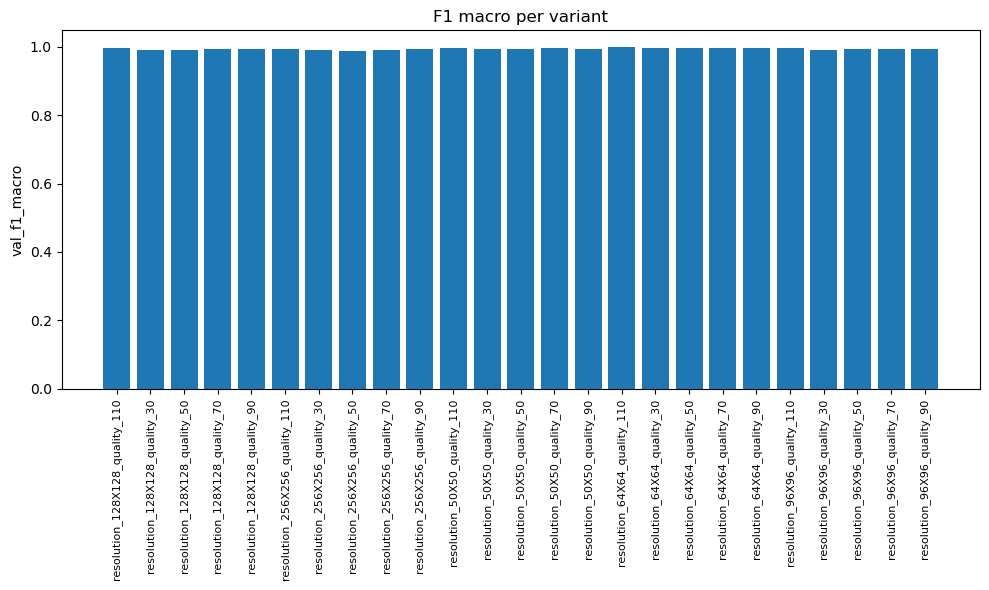

In [5]:
# Quick plot
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,6))
    plt.bar(results_df['variant'], results_df['val_f1_macro'])
    plt.xticks(rotation=90, fontsize=8)
    plt.ylabel('val_f1_macro')
    plt.title('F1 macro per variant')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'f1_per_variant.png')
    plt.show()
except Exception as e:
    print('Plot failed:', e)